</font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

In [1]:
#link python site packages folder
import sys
source_directory = "/Users/pauljacob/Library/Python/3.8/lib/python/site-packages"
sys.path.append(source_directory)

In [2]:
#file structure
!pip3 install cookiecutter

#general
!pip3 install --upgrade pip
!pip3 install ipython-autotime --quiet
!pip3 install watermark

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
%load_ext autotime

time: 256 µs (started: 2023-07-23 21:58:12 -07:00)


## Import Libraries

In [4]:
#get libraries
import pandas as pd
import os
import numpy as np
import itertools
from itertools import combinations
import warnings


#get visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter

#ML preprocessing
from sklearn.preprocessing import StandardScaler

#get ML functions
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import __version__ as sklearn_version
import datetime

#get ML metric functions
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, precision_recall_curve, confusion_matrix

#get icr module and associated common functions
import in_vehicle_coupon_recommendation as icr
from in_vehicle_coupon_recommendation import p, rcp, rpp, rcr, pl, pdc, save_and_return_data_frame, initialize_custom_notebook_settings

time: 1.35 s (started: 2023-07-23 21:58:12 -07:00)


In [5]:
#initialize notebook
st='no'; number_of_replicates=100 if st=='yes' else 10000

filename_version='4dot3'

initialize_custom_notebook_settings()

%load_ext autoreload
%autoreload 1
%aimport in_vehicle_coupon_recommendation 
%load_ext watermark

time: 31.3 ms (started: 2023-07-23 21:58:13 -07:00)


## Get In-Vehicle Coupon Recommendation Dataset

In [6]:
df = pd.read_csv(os.path.join('..', 'data', 'raw', 'in-vehicle-coupon-recommendation.csv'))
df = df.sample(frac=1, random_state=200) #row shuffle DataFrame
#p(df)

time: 43.3 ms (started: 2023-07-23 21:58:13 -07:00)


<font size="5"><a id='[Data_Wrangling]'></a></font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Data_Wrangling]'>**Data Wrangling**</a> </font>

In [7]:
#rename 'passanger' and 'coupon' column
df = df.rename(columns={'passanger':'passenger', 'coupon':'coupon_venue_type'})

#decode string 'age' values to (explicit) string age ranges
column_name_age_value_list = list(df.loc[:, 'age'].unique())
column_name_age_value_list_cleaned_up = ['21-25', '46-49', '26-30', '31-35', '41-45', '50+', '36-40', '<21']
column_name_age_value_dict = dict(zip(column_name_age_value_list, column_name_age_value_list_cleaned_up))
df.loc[:, 'age'] = df.loc[:, 'age'].replace(column_name_age_value_dict)

del column_name_age_value_dict, column_name_age_value_list, column_name_age_value_list_cleaned_up


#drop column 'toCoupon_GEQ5min' because all 1's
column_name_list_not_toCoupon_GEQ5min = [column_name for column_name in df.columns if column_name != 'toCoupon_GEQ5min']
df = df.loc[:, column_name_list_not_toCoupon_GEQ5min]

del column_name_list_not_toCoupon_GEQ5min


#rename values in columns 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', and 'Restaurant20To50' to math language...
#get column name list for column values uniques that are the same as column name 'CarryAway' value uniques
column_name_list_same_unique_values = []
for column_name in df.columns:    
    value = icr.column_name_value_sets_equal(df, column_name1='CarryAway', column_name2=column_name)
    if value == 1:
        column_name_list_same_unique_values = column_name_list_same_unique_values + [column_name]
#rename values in columns 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', and 'Restaurant20To50' to math language
column_name_Bar_value_list = list(df.loc[:, 'Bar'].unique())
column_name_Bar_value_list_cleaned_up = ['never', '<1', '1-3', '>8', np.nan, '4-8']
column_name_Bar_value_dict = dict(zip(column_name_Bar_value_list, column_name_Bar_value_list_cleaned_up))
df.loc[:, column_name_list_same_unique_values] = df.loc[:, column_name_list_same_unique_values].replace(column_name_Bar_value_dict)

del column_name_Bar_value_dict, column_name_Bar_value_list, column_name_Bar_value_list_cleaned_up, column_name_list_same_unique_values


#clean up columns 'direction_same' and 'direction_opp' to 'direction_same_or_opposite'
#drop column 'direction_same'
column_name_list_not_direction_same = [column_name for column_name in df.columns if column_name != 'direction_same']
df = df.loc[:, column_name_list_not_direction_same]

del column_name_list_not_direction_same

#rename 'direction_opp' to 'direction_same_or_opposite'
df = df.rename(columns={'direction_opp':'direction_same_or_opposite'})


#solution1: fill in missing values with 'no response' or 'unknown'
column_name_list = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 'car']
df.loc[:, column_name_list] = df.loc[:, column_name_list].fillna('no response')


#fix income values
income_list = df.loc[:, 'income'].drop_duplicates().to_list()
income_list_fixed = ['\$12500 - \$24999', '\$87500 - \$99999', '\$37500 - \$49999', '\$50000 - \$62499', '\$75000 - \$87499', '\$25000 - \$37499', '\$100000 or More', 'Less than \$12500', '\$62500 - \$74999']
income_dictionary = dict(zip(income_list, income_list_fixed))
df.loc[:, 'income'] = df.loc[:, 'income'].replace(income_dictionary)
p(df)



(12684, 24)


destination passenger weather  temperature  time  \
11199             Home     Alone   Sunny           80   6PM   
1474              Work     Alone   Sunny           55   7AM   
10836             Home     Alone   Sunny           30   6PM   
4567   No Urgent Place     Alone   Sunny           80  10AM   
5658   No Urgent Place     Alone   Sunny           80   2PM   
11343             Work     Alone   Sunny           80   7AM   
9036              Home     Alone   Snowy           30  10PM   
11050             Home     Alone   Sunny           80   6PM   
784               Work     Alone   Sunny           80   7AM   
1818   No Urgent Place    Kid(s)   Sunny           80  10AM   

           coupon_venue_type expiration  gender    age      maritalStatus  \
11199  Carry out & Take away         2h    Male  21-25             Single   
1474                     Bar         1d    Male  46-49    Married partner   
10836  Carry out & Take away         1d    Male  26-30             Single   
4567                     Bar         1d  Female  21-25  Unmarried partner   
5658         Restaurant(<20)         2h  Female  31-35             Single   
11343      Restaurant(20-50)         2h  Female  36-40             Single   
9036         Restaurant(<20)         2h    Male  26-30             Single   
11050      Restaurant(20-50)         1d    Male  46-49             Single   
784    Carry out & Take away         2h  Female  21-25             Single   
1818                     Bar         1d  Female  36-40    Married partner   

       has_children                               education  \
11199             0                        Bachelors degree   
1474              1  Graduate degree (Masters or Doctorate)   
10836             0                Some college - no degree   
4567              0  Graduate degree (Masters or Doctorate)   
5658              1                        Bachelors degree   
11343             1                        Bachelors degree   
9036              0                Some college - no degree   
11050             0                Some college - no degree   
784               0  Graduate degree (Masters or Doctorate)   
1818              1                        Bachelors degree   

                               occupation             income          car  \
11199                             Student  \$12500 - \$24999  no response   
1474                           Management  \$87500 - \$99999  no response   
10836                     Sales & Related  \$37500 - \$49999  no response   
4567           Education&Training&Library  \$37500 - \$49999  no response   
5658               Production Occupations  \$37500 - \$49999  no response   
11343  Food Preparation & Serving Related  \$12500 - \$24999  no response   
9036                              Student  \$12500 - \$24999  no response   
11050                     Sales & Related  Less than \$12500  no response   
784                                 Legal  \$25000 - \$37499  no response   
1818                              Retired  \$50000 - \$62499  no response   

         Bar  CoffeeHouse    CarryAway RestaurantLessThan20 Restaurant20To50  \
11199  never  no response  no response          no response            never   
1474   never           <1           <1                never               <1   
10836     <1  no response           >8                   <1            never   
4567     1-3           <1           <1                   <1            never   
5658   never        never           >8                  4-8            never   
11343    1-3           <1           >8                never            never   
9036      <1        never           >8                never              1-3   
11050     <1           <1           >8                   >8               >8   
784       <1           <1           <1          no response               <1   
1818     1-3        never           >8                   <1            never   

       toCoupon_GEQ15min  toCoupon_GEQ25min  d

time: 90.3 ms (started: 2023-07-23 21:58:13 -07:00)


In [8]:
#takeaway: the most represented scenario is heading to Work, alone, sunny weather, 55 degrees, 7am, bar, 1 day til expiration, >25 minute away in the opposite drive direction of destination
column_name_list_scenario = ['destination', 'passenger', 'weather', 'temperature', 'time', 'coupon_venue_type', 'expiration', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same_or_opposite']
print(df.loc[:, column_name_list_scenario].drop_duplicates().shape)
df.loc[:, column_name_list_scenario].value_counts().to_frame().reset_index().rename(columns={0:'Count'}).head(10)


(201, 10)


destination  passenger weather  temperature  time  \
0             Work      Alone   Sunny           55   7AM   
1  No Urgent Place  Friend(s)   Sunny           55   2PM   
2  No Urgent Place  Friend(s)   Sunny           80   2PM   
3             Work      Alone   Sunny           80   7AM   
4  No Urgent Place      Alone   Sunny           55   2PM   
5  No Urgent Place  Friend(s)   Sunny           80  10AM   
6             Work      Alone   Sunny           80   7AM   
7  No Urgent Place  Friend(s)   Sunny           80   6PM   
8  No Urgent Place  Friend(s)   Sunny           80  10AM   
9             Home      Alone   Sunny           80   6PM   

       coupon_venue_type expiration  toCoupon_GEQ15min  toCoupon_GEQ25min  \
0                    Bar         1d                  1                  1   
1  Carry out & Take away         1d                  1                  0   
2           Coffee House         2h                  1                  0   
3  Carry out & Take away         2h                  0                  0   
4        Restaurant(<20)         1d                  0                  0   
5  Carry out & Take away         2h                  1                  0   
6      Restaurant(20-50)         1d                  1                  0   
7        Restaurant(<20)         2h                  1                  0   
8           Coffee House         2h                  0                  0   
9           Coffee House         2h                  0                  0   

   direction_same_or_opposite  Count  
0                           1    194  
1                           1    181  
2                           1    181  
3                           0    181  
4                           1    181  
5                           1    181  
6                           1    181  
7                           1    181  
8                           1    180  
9                           1    180

time: 22.7 ms (started: 2023-07-23 21:58:13 -07:00)


In [9]:
#takeaway: the most represented demographic is Female, 31-35, Married partner, 0, Some college - no degree	Computer & Mathematical, Income $100000 or More, car no response, Bar never, CoffeeHouse never, Takeout no response, low-cost restaurant >8, mid-range restaurant never
column_name_list_not_demographic=['destination', 'passenger', 'weather', 'temperature', 'time', 'coupon_venue_type', 'expiration', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same_or_opposite', 'Y',]
column_name_list_demographic=[column_name for column_name in df.columns if not column_name in column_name_list_not_demographic]
df.loc[:, column_name_list_demographic].value_counts().reset_index().rename(columns={0:'Count'}).head(10)



gender    age      maritalStatus  has_children  \
0  Female  31-35    Married partner             0   
1    Male  46-49    Married partner             1   
2  Female  26-30    Married partner             1   
3    Male  21-25             Single             0   
4  Female  31-35    Married partner             0   
5  Female  21-25             Single             0   
6  Female  41-45    Married partner             1   
7    Male    <21    Married partner             1   
8  Female    <21           Divorced             1   
9  Female    50+  Unmarried partner             0   

                                education  \
0                Some college - no degree   
1  Graduate degree (Masters or Doctorate)   
2                       Associates degree   
3                    High School Graduate   
4                Some college - no degree   
5                        Bachelors degree   
6  Graduate degree (Masters or Doctorate)   
7                       Associates degree   
8  Graduate degree (Masters or Doctorate)   
9                    High School Graduate   

                                 occupation             income          car  \
0                   Computer & Mathematical   \$100000 or More  no response   
1                                Management  \$87500 - \$99999  no response   
2                                Unemployed  \$50000 - \$62499  no response   
3                                Unemployed  \$37500 - \$49999  no response   
4  Arts Design Entertainment Sports & Media   \$100000 or More  no response   
5                                Unemployed  Less than \$12500  no response   
6                   Computer & Mathematical  \$75000 - \$87499  no response   
7                   Computer & Mathematical   \$100000 or More  no response   
8                                   Student  \$12500 - \$24999  no response   
9                                   Student  Less than \$12500  no response   

           Bar  CoffeeHouse    CarryAway RestaurantLessThan20  \
0        never        never  no response                   >8   
1        never           <1           <1                never   
2          1-3           <1           <1                   <1   
3  no response  no response  no response          no response   
4        never        never  no response                   >8   
5           >8           <1  no response                   >8   
6        never           >8  no response                   <1   
7          1-3        never           >8                   <1   
8          1-3  no response  no response          no response   
9          1-3           >8           <1                   >8   

  Restaurant20To50  Count  
0            never    110  
1               <1     66  
2               <1     66  
3      no response     66  
4            never     44  
5               <1     44  
6            never     44  
7            never     44  
8               <1     44  
9            never     44

time: 21.1 ms (started: 2023-07-23 21:58:13 -07:00)


<font size="5"><a id='[Feature_Engineering]'></a></font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font> 

<font size="6"><a id='[Feature_Engineering]'>**Feature Engineering**</a> </font>

## Get Category Representative Numeric Encoding for Features: expiration, time, age, income

In [10]:
#category representative numeric encoding: expiration, time, age, income

expiration_category_representative_numeric_encoding={'expiration':{'2h':2, '1d':24}}
time_category_representative_numeric_encoding={'time':{'7AM':7,'10AM':10, '2PM':14, '6PM':18, '10PM':22}}
age_category_representative_numeric_encoding={'age':{'<21':18, '21-25':23, '26-30':28, '31-35':33, '36-40':38, '41-45':43, '46-49':48, '50+':56}}
income_category_representative_numeric_encoding={'income':{'Less than \$12500':6250, '\$12500 - \$24999':18749.5, '\$25000 - \$37499':31249.5, '\$37500 - \$49999':43749.5, '\$50000 - \$62499':56249.5, '\$62500 - \$74999':68749.5, '\$75000 - \$87499':81249.5, '\$87500 - \$99999':93749.5,'\$100000 or More':150000}}

#combine category representative numeric encoding dictionaries
category_representative_numeric_encoding_dictionary = expiration_category_representative_numeric_encoding|time_category_representative_numeric_encoding|age_category_representative_numeric_encoding|income_category_representative_numeric_encoding

del expiration_category_representative_numeric_encoding, time_category_representative_numeric_encoding, age_category_representative_numeric_encoding, income_category_representative_numeric_encoding

category_representative_numeric_encoding_key_list = list(category_representative_numeric_encoding_dictionary.keys())

df_category_representative_numeric_encoding = df.loc[:, category_representative_numeric_encoding_key_list].replace(category_representative_numeric_encoding_dictionary)

del category_representative_numeric_encoding_dictionary, 

#rename columns
category_representative_numeric_encoding_substring='_category_representative_numeric_encoding'

column_name_list_category_representative_numeric_encoding = [str(column_name) + category_representative_numeric_encoding_substring for column_name in category_representative_numeric_encoding_key_list]

column_name_dictionary_category_representative_numeric_encoding = dict(zip(category_representative_numeric_encoding_key_list, column_name_list_category_representative_numeric_encoding))

df_category_representative_numeric_encoding = df_category_representative_numeric_encoding.rename(columns=column_name_dictionary_category_representative_numeric_encoding)

del column_name_dictionary_category_representative_numeric_encoding, column_name_list_category_representative_numeric_encoding, category_representative_numeric_encoding_key_list, category_representative_numeric_encoding_substring

#p(df_category_representative_numeric_encoding)

time: 24.8 ms (started: 2023-07-23 21:58:13 -07:00)


## Get Binary Encoding for Features: gender, expiration

In [11]:
#binary encoding: gender, expiration
gender_binary_encoding={'gender':{'Female':0, 'Male':1}}
expiration_binary_encoding={'expiration':{'2h':0, '1d':1}}

binary_encoding_dictionary = gender_binary_encoding|expiration_binary_encoding

del gender_binary_encoding, expiration_binary_encoding

binary_encoding_key_list = list(binary_encoding_dictionary.keys())

df_binary_encoding = df.loc[:, binary_encoding_key_list].replace(binary_encoding_dictionary)

del binary_encoding_dictionary


#rename columns
binary_encoding_substring = '_binary_encoding'
column_name_list_binary_encoding = [str(column_name) + binary_encoding_substring for column_name in binary_encoding_key_list]
column_name_dictionary_binary_encoding = dict(zip(binary_encoding_key_list, column_name_list_binary_encoding))
df_binary_encoding = df_binary_encoding.rename(columns=column_name_dictionary_binary_encoding)

del column_name_dictionary_binary_encoding, column_name_list_binary_encoding, binary_encoding_key_list, binary_encoding_substring

#p(df_binary_encoding)

time: 11.2 ms (started: 2023-07-23 21:58:13 -07:00)


## Get Ordinal Integer Encoding for Features: coupon_venue_type, education, income, age, time, temperature

In [12]:
#ordinal integer encoding: coupon_venue_type, education, income, age, time, temperature

#category ordinal features to ordinal integer encoding
coupon_venue_type_ordinal_integer_encoding={'coupon_venue_type':{'Coffee House':1, 'Bar':2, 'Carry out & Take away':3, 'Restaurant(<20)':4, 'Restaurant(20-50)':5}}
education_ordinal_integer_encoding={'education':{'Some High School':1, 'High School Graduate':2, 'Some college - no degree':3, 'Associates degree':4, 'Bachelors degree':5,'Graduate degree (Masters or Doctorate)':6}}
income_ordinal_integer_encoding={'income':{'Less than \$12500':1, '\$12500 - \$24999':2, '\$25000 - \$37499':3, '\$37500 - \$49999':4, '\$50000 - \$62499':5, '\$62500 - \$74999':6, '\$75000 - \$87499':7, '\$87500 - \$99999':8, '\$100000 or More':9}}
age_ordinal_integer_encoding={'age':{'<21':1, '21-25':2, '26-30':3, '31-35':4, '36-40':5, '41-45':6, '46-49':7, '50+':8}}
time_ordinal_integer_encoding={'time':{'7AM':1, '10AM':2, '2PM':3, '6PM':4, '10PM':5}}

#numeric to ordinal integer encoding
temperature_ordinal_integer_encoding={'temperature':{30:1, 55:2, 80:3}}


ordinal_integer_encoding_dictionary = coupon_venue_type_ordinal_integer_encoding|education_ordinal_integer_encoding|income_ordinal_integer_encoding|age_ordinal_integer_encoding|time_ordinal_integer_encoding|temperature_ordinal_integer_encoding

del coupon_venue_type_ordinal_integer_encoding, education_ordinal_integer_encoding, income_ordinal_integer_encoding, age_ordinal_integer_encoding, time_ordinal_integer_encoding, temperature_ordinal_integer_encoding

ordinal_integer_encoding_key_list = list(ordinal_integer_encoding_dictionary.keys())

df_ordinal_integer_encoding = df.loc[:, ordinal_integer_encoding_key_list].replace(ordinal_integer_encoding_dictionary)

del ordinal_integer_encoding_dictionary

#rename columns
ordinal_integer_encoding_substring='_ordinal_integer_encoding'
column_name_list_ordinal_integer_encoding=[str(column_name) + ordinal_integer_encoding_substring for column_name in ordinal_integer_encoding_key_list]
column_name_dictionary_ordinal_integer_encoding=dict(zip(ordinal_integer_encoding_key_list,column_name_list_ordinal_integer_encoding))
df_ordinal_integer_encoding=df_ordinal_integer_encoding.rename(columns=column_name_dictionary_ordinal_integer_encoding)

del column_name_dictionary_ordinal_integer_encoding, column_name_list_ordinal_integer_encoding, ordinal_integer_encoding_key_list, ordinal_integer_encoding_substring

#p(df_ordinal_integer_encoding)

time: 33.7 ms (started: 2023-07-23 21:58:13 -07:00)


## Get Venue Type Visits Per Month Yes Response to Ordinal Integer Encoding for Features: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50

In [13]:
#venue type visits per month yes response to ordinal integer encoding: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50
bar_venue_visit_frequency_yes_response_ordinal_integer_encoding={'Bar':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
coffeehouse_venue_visit_frequency_yes_response_ordinal_integer_encoding={'CoffeeHouse':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
carryaway_venue_visit_frequency_yes_response_ordinal_integer_encoding={'CarryAway':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
restaurantlessthan20_venue_visit_frequency_yes_response_ordinal_integer_encoding={'RestaurantLessThan20':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
restaurant20to50_venue_visit_frequency_yes_response_ordinal_integer_encoding={'Restaurant20To50':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}


venue_visit_frequency_yes_response_ordinal_integer_encoding_dictionary=bar_venue_visit_frequency_yes_response_ordinal_integer_encoding|coffeehouse_venue_visit_frequency_yes_response_ordinal_integer_encoding|carryaway_venue_visit_frequency_yes_response_ordinal_integer_encoding|restaurantlessthan20_venue_visit_frequency_yes_response_ordinal_integer_encoding|restaurant20to50_venue_visit_frequency_yes_response_ordinal_integer_encoding

del bar_venue_visit_frequency_yes_response_ordinal_integer_encoding, carryaway_venue_visit_frequency_yes_response_ordinal_integer_encoding, restaurantlessthan20_venue_visit_frequency_yes_response_ordinal_integer_encoding, restaurant20to50_venue_visit_frequency_yes_response_ordinal_integer_encoding
#del bar_venue_visit_frequency_yes_response_ordinal_integer_encoding, coffeehouse_venue_visit_frequency_yes_response_ordinal_integer_encoding, carryaway_venue_visit_frequency_yes_response_ordinal_integer_encoding, restaurantlessthan20_venue_visit_frequency_yes_response_ordinal_integer_encoding, restaurant20to50_venue_visit_frequency_yes_response_ordinal_integer_encoding

venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list=list(venue_visit_frequency_yes_response_ordinal_integer_encoding_dictionary.keys())

df_venue_visit_frequency_yes_response_ordinal_integer_encoding = df.loc[:, venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list].replace(venue_visit_frequency_yes_response_ordinal_integer_encoding_dictionary)

del venue_visit_frequency_yes_response_ordinal_integer_encoding_dictionary

#rename columns
venue_visit_frequency_yes_response_ordinal_integer_encoding_substring='_venue_visit_frequency_yes_response_ordinal_integer_encoding'
column_name_list_venue_visit_frequency_yes_response_ordinal_integer_encoding=[str(column_name) + venue_visit_frequency_yes_response_ordinal_integer_encoding_substring for column_name in venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list]
column_name_dictionary_venue_visit_frequency_yes_response_ordinal_integer_encoding=dict(zip(venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list, column_name_list_venue_visit_frequency_yes_response_ordinal_integer_encoding))
df_venue_visit_frequency_yes_response_ordinal_integer_encoding = df_venue_visit_frequency_yes_response_ordinal_integer_encoding.rename(columns=column_name_dictionary_venue_visit_frequency_yes_response_ordinal_integer_encoding)

del column_name_dictionary_venue_visit_frequency_yes_response_ordinal_integer_encoding, venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list, venue_visit_frequency_yes_response_ordinal_integer_encoding_substring, column_name_list_venue_visit_frequency_yes_response_ordinal_integer_encoding

#p(df_venue_visit_frequency_yes_response_ordinal_integer_encoding)

time: 29.3 ms (started: 2023-07-23 21:58:13 -07:00)


## Get Venue Type Visits Per Month No Response to Indicator Variable for Features: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50

In [14]:
#venue type visits per month no response to indicator variable: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50
bar_venue_visit_frequency_no_response_indicator_variable={'Bar':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
coffeehouse_venue_visit_frequency_no_response_indicator_variable={'CoffeeHouse':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
carryaway_venue_visit_frequency_no_response_indicator_variable={'CarryAway':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
restaurantlessthan20_venue_visit_frequency_no_response_indicator_variable={'RestaurantLessThan20':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
restaurant20to50_venue_visit_frequency_no_response_indicator_variable={'Restaurant20To50':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}

venue_visit_frequency_no_response_indicator_variable_dictionary=bar_venue_visit_frequency_no_response_indicator_variable|coffeehouse_venue_visit_frequency_no_response_indicator_variable|carryaway_venue_visit_frequency_no_response_indicator_variable|restaurantlessthan20_venue_visit_frequency_no_response_indicator_variable|restaurant20to50_venue_visit_frequency_no_response_indicator_variable

del bar_venue_visit_frequency_no_response_indicator_variable, coffeehouse_venue_visit_frequency_no_response_indicator_variable, carryaway_venue_visit_frequency_no_response_indicator_variable, restaurantlessthan20_venue_visit_frequency_no_response_indicator_variable, restaurant20to50_venue_visit_frequency_no_response_indicator_variable

venue_visit_frequency_no_response_indicator_variable_key_list=list(venue_visit_frequency_no_response_indicator_variable_dictionary.keys())

df_venue_visit_frequency_no_response_indicator_variable=df.loc[:, venue_visit_frequency_no_response_indicator_variable_key_list].replace(venue_visit_frequency_no_response_indicator_variable_dictionary)

del venue_visit_frequency_no_response_indicator_variable_dictionary

#rename columns
venue_visit_frequency_no_response_indicator_variable='_venue_visit_frequency_no_response_indicator'
column_name_list_venue_visit_frequency_no_response_indicator_variable=[str(column_name) + venue_visit_frequency_no_response_indicator_variable for column_name in venue_visit_frequency_no_response_indicator_variable_key_list]
column_name_dictionary_venue_visit_frequency_no_response_indicator_variable=dict(zip(venue_visit_frequency_no_response_indicator_variable_key_list, column_name_list_venue_visit_frequency_no_response_indicator_variable))
df_venue_visit_frequency_no_response_indicator_variable=df_venue_visit_frequency_no_response_indicator_variable.rename(columns=column_name_dictionary_venue_visit_frequency_no_response_indicator_variable)

del column_name_dictionary_venue_visit_frequency_no_response_indicator_variable, column_name_list_venue_visit_frequency_no_response_indicator_variable, venue_visit_frequency_no_response_indicator_variable_key_list, venue_visit_frequency_no_response_indicator_variable

#p(df_venue_visit_frequency_no_response_indicator_variable)

time: 31 ms (started: 2023-07-23 21:58:13 -07:00)


## Concatenate the Data Frames

In [15]:
#concatenate the data frames

#get data frame list
data_frame_list=[df, df_category_representative_numeric_encoding, df_binary_encoding, df_ordinal_integer_encoding, df_venue_visit_frequency_yes_response_ordinal_integer_encoding, df_venue_visit_frequency_no_response_indicator_variable]
del df_category_representative_numeric_encoding, df_binary_encoding, df_ordinal_integer_encoding, df_venue_visit_frequency_yes_response_ordinal_integer_encoding, df_venue_visit_frequency_no_response_indicator_variable

#concat data frames
df = pd.concat(data_frame_list, axis=1)
del data_frame_list

p(df)

(12684, 46)


destination passenger weather  temperature  time  \
11199             Home     Alone   Sunny           80   6PM   
1474              Work     Alone   Sunny           55   7AM   
10836             Home     Alone   Sunny           30   6PM   
4567   No Urgent Place     Alone   Sunny           80  10AM   
5658   No Urgent Place     Alone   Sunny           80   2PM   
11343             Work     Alone   Sunny           80   7AM   
9036              Home     Alone   Snowy           30  10PM   
11050             Home     Alone   Sunny           80   6PM   
784               Work     Alone   Sunny           80   7AM   
1818   No Urgent Place    Kid(s)   Sunny           80  10AM   

           coupon_venue_type expiration  gender    age      maritalStatus  \
11199  Carry out & Take away         2h    Male  21-25             Single   
1474                     Bar         1d    Male  46-49    Married partner   
10836  Carry out & Take away         1d    Male  26-30             Single   
4567                     Bar         1d  Female  21-25  Unmarried partner   
5658         Restaurant(<20)         2h  Female  31-35             Single   
11343      Restaurant(20-50)         2h  Female  36-40             Single   
9036         Restaurant(<20)         2h    Male  26-30             Single   
11050      Restaurant(20-50)         1d    Male  46-49             Single   
784    Carry out & Take away         2h  Female  21-25             Single   
1818                     Bar         1d  Female  36-40    Married partner   

       has_children                               education  \
11199             0                        Bachelors degree   
1474              1  Graduate degree (Masters or Doctorate)   
10836             0                Some college - no degree   
4567              0  Graduate degree (Masters or Doctorate)   
5658              1                        Bachelors degree   
11343             1                        Bachelors degree   
9036              0                Some college - no degree   
11050             0                Some college - no degree   
784               0  Graduate degree (Masters or Doctorate)   
1818              1                        Bachelors degree   

                               occupation             income          car  \
11199                             Student  \$12500 - \$24999  no response   
1474                           Management  \$87500 - \$99999  no response   
10836                     Sales & Related  \$37500 - \$49999  no response   
4567           Education&Training&Library  \$37500 - \$49999  no response   
5658               Production Occupations  \$37500 - \$49999  no response   
11343  Food Preparation & Serving Related  \$12500 - \$24999  no response   
9036                              Student  \$12500 - \$24999  no response   
11050                     Sales & Related  Less than \$12500  no response   
784                                 Legal  \$25000 - \$37499  no response   
1818                              Retired  \$50000 - \$62499  no response   

         Bar  CoffeeHouse    CarryAway RestaurantLessThan20 Restaurant20To50  \
11199  never  no response  no response          no response            never   
1474   never           <1           <1                never               <1   
10836     <1  no response           >8                   <1            never   
4567     1-3           <1           <1                   <1            never   
5658   never        never           >8                  4-8            never   
11343    1-3           <1           >8                never            never   
9036      <1        never           >8                never              1-3   
11050     <1           <1           >8                   >8               >8   
784       <1           <1           <1          no response               <1   
1818     1-3        never           >8                   <1            never   

       toCoupon_GEQ15min  toCoupon_GEQ25min  d

time: 20.4 ms (started: 2023-07-23 21:58:13 -07:00)


In [16]:
#save df collection with four object train test splits before preprocessed DataFrame
df_collection_filename='df_collection_train_test_v' + filename_version + '.pkl'


df_readback = icr.return_processed_collection_if_it_exists(filename=df_collection_filename)
if df_readback != None:
    df_collection = df_readback
else:
    df_collection = {}
    
    #split the data into train and test
    df_collection['X_train'], df_collection['X_test'], df_collection['Y_train'], df_collection['Y_test'] = \
    train_test_split(df.drop(columns=['Y']), df.loc[:, 'Y'], test_size=.2, random_state=200)
    
    #save preprocessed data frame collection
    df_collection = icr.save_and_return_collection(data_frame_collection=df_collection, filename=df_collection_filename)

p(df_collection['X_train'])

This file already exists
(10147, 45)


destination  passenger weather  temperature  time  \
8630   No Urgent Place  Friend(s)   Sunny           80   6PM   
2418   No Urgent Place  Friend(s)   Sunny           55   2PM   
10804  No Urgent Place      Alone   Rainy           55   2PM   
747    No Urgent Place  Friend(s)   Sunny           80   2PM   
7333   No Urgent Place  Friend(s)   Sunny           80   6PM   
10949  No Urgent Place     Kid(s)   Snowy           30   6PM   
11937  No Urgent Place      Alone   Rainy           55  10AM   
735               Home      Alone   Sunny           55   6PM   
67     No Urgent Place  Friend(s)   Sunny           80  10AM   
3251   No Urgent Place  Friend(s)   Sunny           80  10AM   

           coupon_venue_type expiration  gender    age      maritalStatus  \
8630            Coffee House         1d  Female  21-25    Married partner   
2418            Coffee House         2h  Female  26-30             Single   
10804  Carry out & Take away         2h  Female  31-35             Single   
747             Coffee House         1d  Female  36-40    Married partner   
7333            Coffee House         1d    Male    <21  Unmarried partner   
10949                    Bar         1d  Female  31-35    Married partner   
11937                    Bar         1d  Female  31-35    Married partner   
735        Restaurant(20-50)         1d    Male  41-45             Single   
67              Coffee House         2h    Male  46-49    Married partner   
3251            Coffee House         2h  Female  26-30    Married partner   

       has_children                               education  \
8630              0                        Bachelors degree   
2418              0                        Bachelors degree   
10804             0  Graduate degree (Masters or Doctorate)   
747               0                Some college - no degree   
7333              1                Some college - no degree   
10949             1                        Bachelors degree   
11937             0                Some college - no degree   
735               0                Some college - no degree   
67                1                        Bachelors degree   
3251              1                Some college - no degree   

                                      occupation             income  \
8630                                  Unemployed  \$87500 - \$99999   
2418    Arts Design Entertainment Sports & Media  \$12500 - \$24999   
10804                                      Legal  \$75000 - \$87499   
747                           Healthcare Support  \$25000 - \$37499   
7333   Building & Grounds Cleaning & Maintenance  \$25000 - \$37499   
10949                                    Student  \$37500 - \$49999   
11937                    Computer & Mathematical   \$100000 or More   
735                              Sales & Related  \$37500 - \$49999   
67                    Education&Training&Library  \$75000 - \$87499   
3251                                  Unemployed  \$25000 - \$37499   

               car          Bar CoffeeHouse    CarryAway RestaurantLessThan20  \
8630   no response           <1       never          4-8                never   
2418   no response           >8          >8           >8                   >8   
10804  no response  no response          >8           >8                   >8   
747    no response           <1          <1           >8                   >8   
7333   no response           <1       never           <1                   <1   
10949  no response          1-3       never  no response                   >8   
11937  no response        never       never  no response                   >8   
735    no response          1-3         1-3           >8                   <1   
67     no response        never          <1           <1                   <1   
3251   no response          1-3       never           <1                never   

      Restaurant20To50  toCoupon_GEQ15min  toCoupon_GEQ25min  \
8630             never    

time: 32.2 ms (started: 2023-07-23 21:58:13 -07:00)


<font size="5"><a id='[Exploratory_Data_Analysis]'></a></font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font> 

<font size="6"><a id='[Exploratory_Data_Analysis]'>**Exploratory Data Analysis**</a> </font>

#### Initialize Variables

In [17]:
color_list = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']

time: 485 µs (started: 2023-07-23 21:58:13 -07:00)


#### Coupon Acceptance Percentage and Frequency Distribution (Vertical Bar Plot)

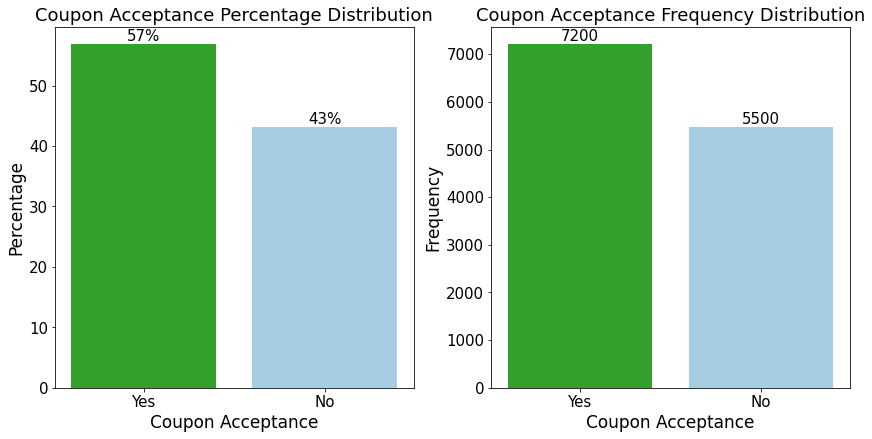

time: 263 ms (started: 2023-07-23 21:58:13 -07:00)


In [18]:
bar_orientation='vertical'
dpi=100
figure_filename = '../reports/figures/figure_coupon_acceptance_percentage_and_frequency_distribution_'+ str(bar_orientation) + '_bar_plot_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'
figure_filename_axes1 = '../reports/figures/figure_coupon_acceptance_percentage_and_frequency_distribution_'+ str(bar_orientation) + '_bar_plot_axes1_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'
figure_filename_axes2 = '../reports/figures/figure_coupon_acceptance_percentage_and_frequency_distribution_'+ str(bar_orientation) + '_bar_plot_axes2_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

plot_save_together_separate = 'together'

figsize=(12, 6.2)
bar_width=0.8

xlabel = 'Coupon Acceptance'
ylabel = 'Percentage'
title = 'Coupon Acceptance '+ str(ylabel) + ' Distribution'

target_value_dictionary = {1: 'Yes', 0:'No'}

df_Y_frequency = df.loc[:, ['Y']].value_counts().reset_index().rename(columns={0:'frequency'})
df_Y_frequency.loc[:, 'percentage'] = df_Y_frequency.loc[:, 'frequency'] / df_Y_frequency.loc[:, 'frequency'].sum(axis=0) * 100
df_Y_frequency_percentage = df_Y_frequency
del df_Y_frequency

x_label_list = df_Y_frequency_percentage.loc[:, 'Y'].replace(target_value_dictionary).to_list()


if plot_save_together_separate == 'together':
    figure, (axes1, axes2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
elif plot_save_together_separate == 'separate':
    figure1, axes1 = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    figure2, axes2 = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    

#make percentage subplot
annotation_round_by_number = 0

percentage_list = df_Y_frequency_percentage.loc[:, 'percentage'].to_list()

axes1.bar(x=x_label_list, height=percentage_list, width=bar_width, color=[color_list[3], color_list[0]])

axes1.set_title(label=title, fontsize=18)
axes1.set_xlabel(xlabel=xlabel, fontsize=17)
axes1.set_ylabel(ylabel=ylabel, fontsize=17)
axes1.tick_params(axis='both', which='major', labelsize=15)

for rectangle, annotation in zip(axes1.patches, percentage_list):
    axes1.text(rectangle.get_x() + rectangle.get_width() / 2, rectangle.get_height(), format(round(annotation, annotation_round_by_number), '.0f') + '%', ha="center", va="bottom", fontsize=15)

#make frequency subplot
ylabel = 'Frequency'
title = 'Coupon Acceptance '+ str(ylabel) + ' Distribution'
annotation_round_by_number = -2

frequency_list = df_Y_frequency_percentage.loc[:, 'frequency'].to_list()

axes2.bar(x=x_label_list, height=frequency_list, width=bar_width, color=[color_list[3], color_list[0]])

axes2.set_title(label=title, fontsize=18)
axes2.set_xlabel(xlabel=xlabel, fontsize=17)
axes2.set_ylabel(ylabel=ylabel, fontsize=17)
axes2.tick_params(axis='both', which='major', labelsize=15)

for rectangle, annotation in zip(axes2.patches, frequency_list):
    axes2.text(rectangle.get_x() + rectangle.get_width() / 2, rectangle.get_height() + 5, round(annotation, annotation_round_by_number), ha="center", va="bottom", fontsize=15)

plt.tight_layout()

if plot_save_together_separate == 'together':
    figure.savefig(figure_filename, bbox_inches='tight', dpi=dpi)
elif plot_save_together_separate == 'separate':
    figure1.savefig(figure_filename_axes1, bbox_inches='tight', dpi=dpi)
    figure2.savefig(figure_filename_axes2, bbox_inches='tight', dpi=dpi)


plt.show()

In [19]:
#sample size, population size, margin of error, confidence interval

#intialize parameters
z_score = 1.96; confidence_interval = .95

p_value = 0.5684326710816777
margin_of_error = .0381
N_population_size = 2.4 * 10**8

#known 652 surveys acceptance, https://jmlr.org/papers/volume18/16-003/16-003.pdf

#calculate sample size
sample_size = (z_score**2*p_value*(1-p_value)/margin_of_error**2)/(1+(z_score**2*p_value*(1-p_value)/margin_of_error**2/N_population_size))
print('Sample size ' + str(round(sample_size)) + ' for a '+ str(round(confidence_interval*100, None)) +'% confidence interval, margin of error ' \
      + str(margin_of_error) + ', population size ' + str(round(N_population_size)) + ', p-value ' + str(round(p_value, 5))
      + ' is less than known 652 surveys.\n')

round_by_number = None
print('Therefore, '+ str(round(confidence_interval*100, None)) +'% of the time, we expect a coupon acceptance rate between ' \
      + str(round((p_value-margin_of_error/2)*100, round_by_number)) + '% and ' \
      + str(round((p_value+margin_of_error/2)*100, round_by_number)) + '%')

Sample size 649 for a 95% confidence interval, margin of error 0.0381, population size 240000000, p-value 0.56843 is less than known 652 surveys.

Therefore, 95% of the time, we expect a coupon acceptance rate between 55% and 59%
time: 1.73 ms (started: 2023-07-23 21:58:14 -07:00)


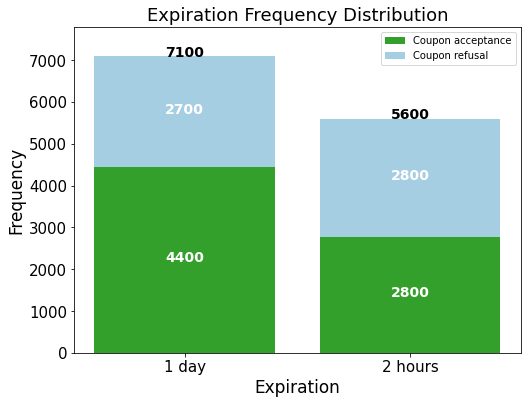

time: 173 ms (started: 2023-07-23 21:58:14 -07:00)


In [20]:
feature_column_name = 'expiration'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'frequency'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['1d', '2h']
xtick_dictionary = {'1d':'1 day', '2h':'2 hours'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]


figsize=(8,8)


#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number)

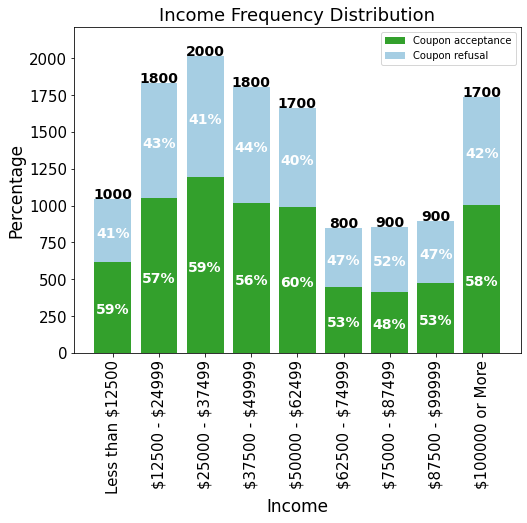

time: 305 ms (started: 2023-07-23 21:58:14 -07:00)


In [21]:
feature_column_name = 'income'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Percentage'

xtick_rotation=90
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2
rectangle_annotation_y_offset = -45

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Less than \$12500', '\$12500 - \$24999', '\$25000 - \$37499', '\$37500 - \$49999', '\$50000 - \$62499', '\$62500 - \$74999',  '\$75000 - \$87499', '\$87500 - \$99999', '\$100000 or More',]
xtick_dictionary = None

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]


figsize=(8,8)


#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, rectangle_annotation_y_offset=rectangle_annotation_y_offset)


#### Coupon Venue Drive Direction Frequency Distribution (Stacked Bar Plot Percentage Annotation)

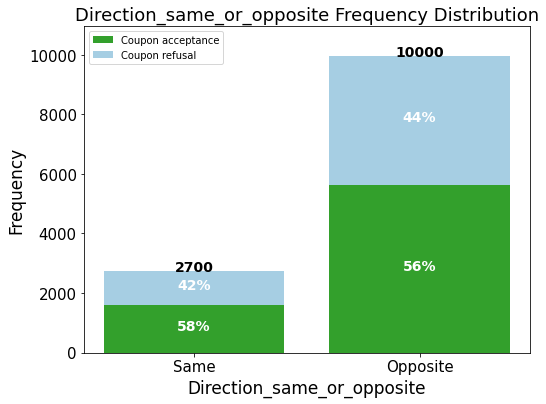

time: 149 ms (started: 2023-07-23 21:58:14 -07:00)


In [22]:
feature_column_name = 'direction_same_or_opposite'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [0,1]
xtick_dictionary = {0:'Same', 1:'Opposite'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)


#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit)

#### Expiration Frequency Distribution (Stacked Bar Plot Percentage Annotation)

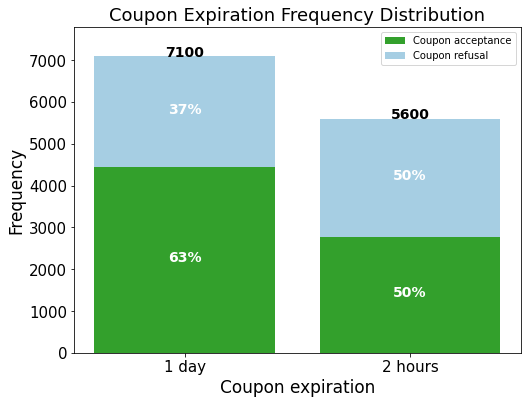

time: 163 ms (started: 2023-07-23 21:58:14 -07:00)


In [23]:
feature_column_name = 'expiration'
feature_column_name_label='Coupon '+feature_column_name.capitalize()
xlabel='Coupon '+feature_column_name
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['1d', '2h']
xtick_dictionary = {'1d':'1 day', '2h':'2 hours'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)


#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit)

#### Gender Frequency Distribution (Stacked Bar Plot Percentage Annotation)

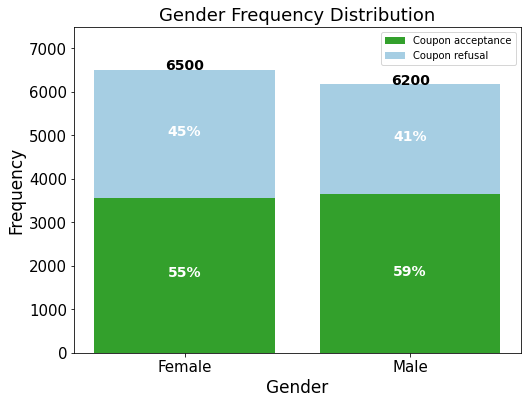

time: 165 ms (started: 2023-07-23 21:58:15 -07:00)


In [24]:
feature_column_name = 'gender'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Female','Male', ]
xtick_dictionary = None

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=7500

figsize=(8,8)


#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit)

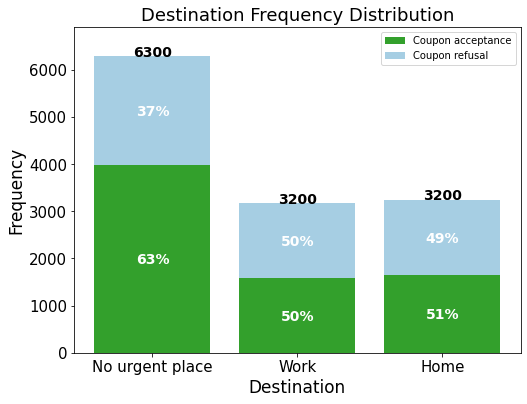

time: 182 ms (started: 2023-07-23 21:58:15 -07:00)


In [25]:
feature_column_name = 'destination'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['No Urgent Place', 'Work', 'Home']
xtick_dictionary = {'No Urgent Place':'No urgent place', 'Work':'Work', 'Home':'Home'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)
rectangle_annotation_y_offset = -100


#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset)

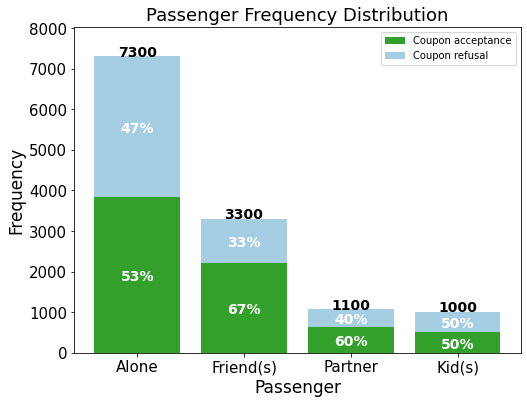

time: 196 ms (started: 2023-07-23 21:58:15 -07:00)


In [26]:
feature_column_name = 'passenger'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Alone', 'Friend(s)', 'Partner', 'Kid(s)', ]
xtick_dictionary = None

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)

rectangle_annotation_y_offset=-140

#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset)

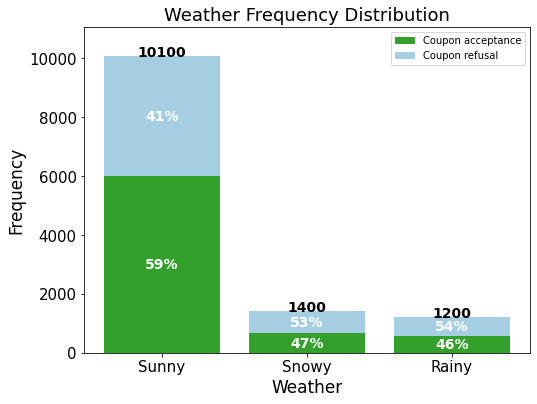

time: 168 ms (started: 2023-07-23 21:58:15 -07:00)


In [27]:
feature_column_name = 'weather'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Sunny', 'Snowy', 'Rainy', ]
xtick_dictionary = None

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)

rectangle_annotation_y_offset=-140

#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset)

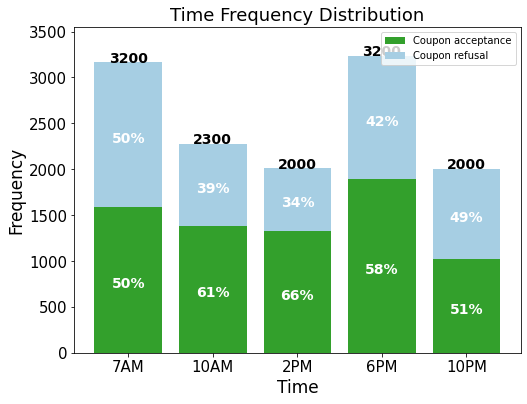

time: 200 ms (started: 2023-07-23 21:58:15 -07:00)


In [28]:
feature_column_name = 'time'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['7AM', '10AM', '2PM', '6PM', '10PM']
xtick_dictionary = None

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)

rectangle_annotation_y_offset=-80

#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset)

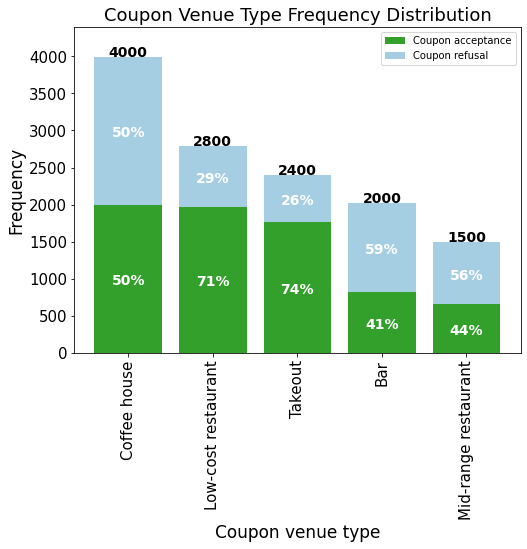

time: 230 ms (started: 2023-07-23 21:58:15 -07:00)


In [29]:
feature_column_name = 'coupon_venue_type'
feature_column_name_label='Coupon Venue Type'#feature_column_name.capitalize()
xlabel='Coupon venue type'#feature_column_name_label
ylabel='Frequency'

xtick_rotation=90
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Coffee House', 'Restaurant(<20)', 'Carry out & Take away', 'Bar', 'Restaurant(20-50)']
xtick_dictionary = {'Coffee House':'Coffee house', 'Restaurant(<20)':'Low-cost restaurant', 'Carry out & Take away':'Takeout', 'Bar':'Bar', 'Restaurant(20-50)':'Mid-range restaurant'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-80

#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize)

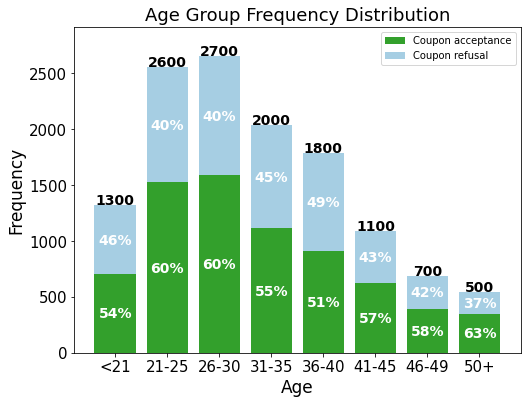

time: 244 ms (started: 2023-07-23 21:58:16 -07:00)


In [30]:
feature_column_name = 'age'
feature_column_name_label='Age Group'#feature_column_name.capitalize()
xlabel='Age'#feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['<21', '21-25', '26-30', '31-35', '36-40', '41-45', '46-49', '50+']
xtick_dictionary = None #{}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-40

#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize)

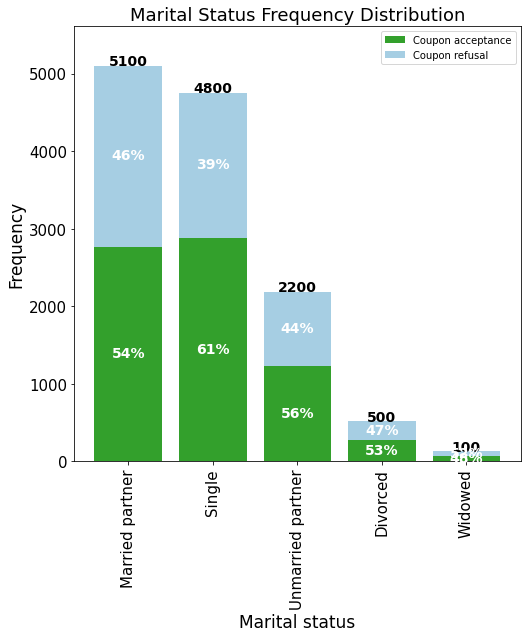

time: 223 ms (started: 2023-07-23 21:58:16 -07:00)


In [31]:
feature_column_name = 'maritalStatus'
feature_column_name_label='Marital Status'#feature_column_name.capitalize()
xlabel='Marital status'#feature_column_name_label
ylabel='Frequency'

xtick_rotation=90
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Married partner', 'Single', 'Unmarried partner', 'Divorced', 'Widowed']
xtick_dictionary = None #{}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)

rectangle_annotation_y_offset=-40

#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize)

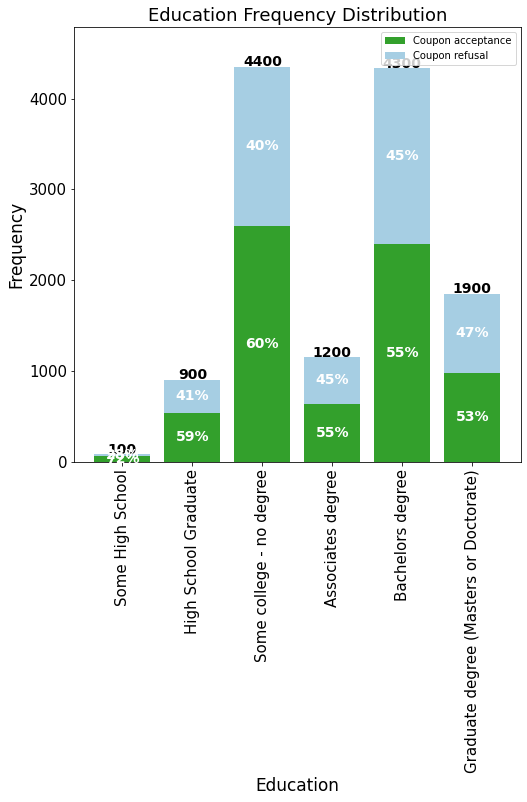

time: 240 ms (started: 2023-07-23 21:58:16 -07:00)


In [32]:
feature_column_name = 'education'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=90
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Some High School', 'High School Graduate', 'Some college - no degree', 'Associates degree', 'Bachelors degree', 'Graduate degree (Masters or Doctorate)',]
xtick_dictionary = None #{}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)

rectangle_annotation_y_offset=-40

#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize)

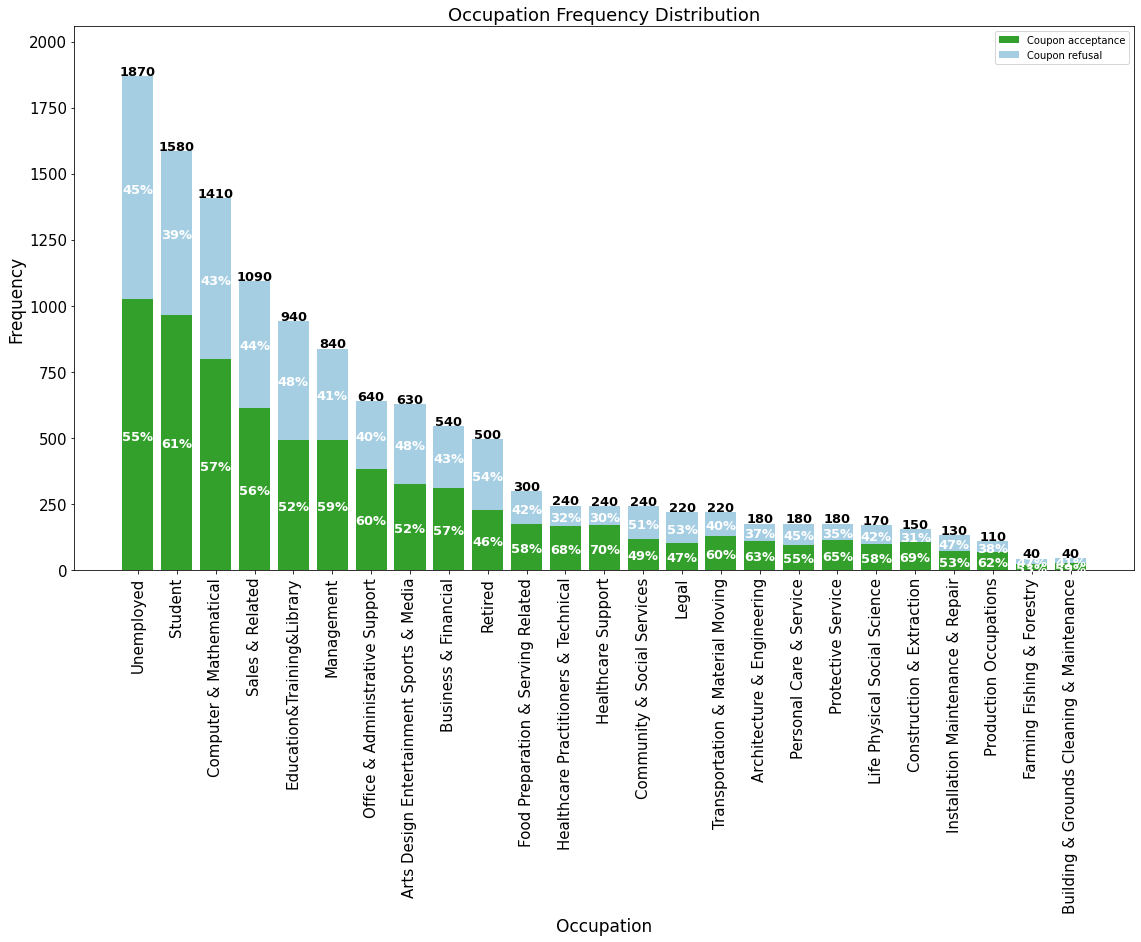

time: 797 ms (started: 2023-07-23 21:58:16 -07:00)


In [33]:
feature_column_name = 'occupation'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=90
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-1

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = \
['Unemployed', 'Student', 'Computer & Mathematical', 'Sales & Related', 'Education&Training&Library', 'Management', 
 'Office & Administrative Support', 'Arts Design Entertainment Sports & Media',
 'Business & Financial', 'Retired', 'Food Preparation & Serving Related', 'Healthcare Practitioners & Technical',
 'Healthcare Support', 'Community & Social Services', 'Legal', 'Transportation & Material Moving',
 'Architecture & Engineering', 'Personal Care & Service', 'Protective Service', 'Life Physical Social Science',
 'Construction & Extraction', 'Installation Maintenance & Repair', 'Production Occupations', 'Farming Fishing & Forestry',
 'Building & Grounds Cleaning & Maintenance']

xtick_dictionary = None #{}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(19,10)

rectangle_annotation_y_offset=-20


#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)

#### Bar Monthly Visit Frequency Frequency Distribution

In [34]:
icr.reverse_key_value_of_dictionary({'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0})

{1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

time: 1.61 ms (started: 2023-07-23 21:58:17 -07:00)


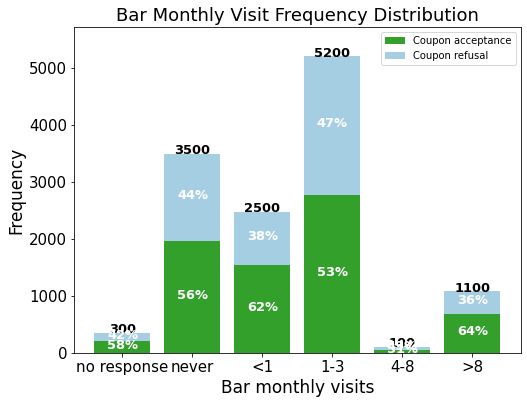

time: 207 ms (started: 2023-07-23 21:58:17 -07:00)


In [35]:
feature_column_name = 'Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding'
feature_column_name_label='Bar Monthly Visit'
xlabel='Bar monthly visits'
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [0, 1, 2, 3, 4, 5]
xtick_dictionary = {1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-20


#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)

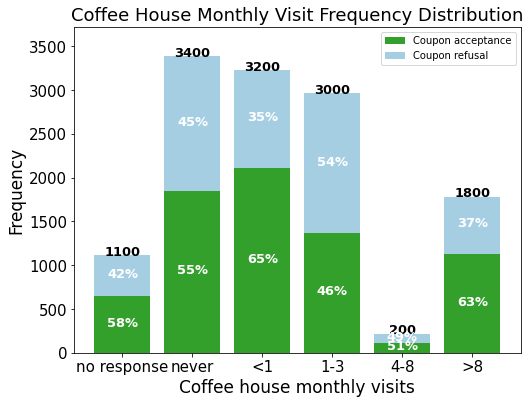

time: 202 ms (started: 2023-07-23 21:58:17 -07:00)


In [36]:
feature_column_name = 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'
feature_column_name_label='Coffee House Monthly Visit'
xlabel='Coffee house monthly visits'
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [0, 1, 2, 3, 4, 5]
xtick_dictionary = {1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-20


#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)

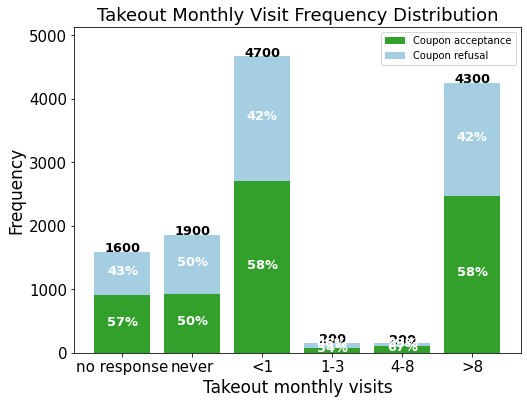

time: 204 ms (started: 2023-07-23 21:58:18 -07:00)


In [37]:
feature_column_name = 'CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding'
feature_column_name_label='Takeout Monthly Visit'
xlabel='Takeout monthly visits'
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [0, 1, 2, 3, 4, 5]
xtick_dictionary = {1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-20


#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)

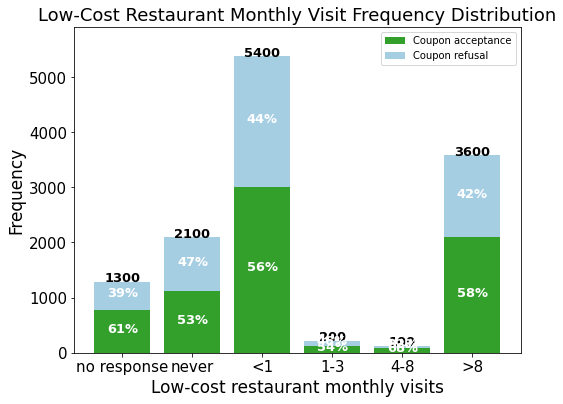

time: 201 ms (started: 2023-07-23 21:58:18 -07:00)


In [38]:
feature_column_name = 'RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding'
feature_column_name_label='Low-Cost Restaurant Monthly Visit'
xlabel='Low-cost restaurant monthly visits'
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [0, 1, 2, 3, 4, 5]
xtick_dictionary = {1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-20


#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)

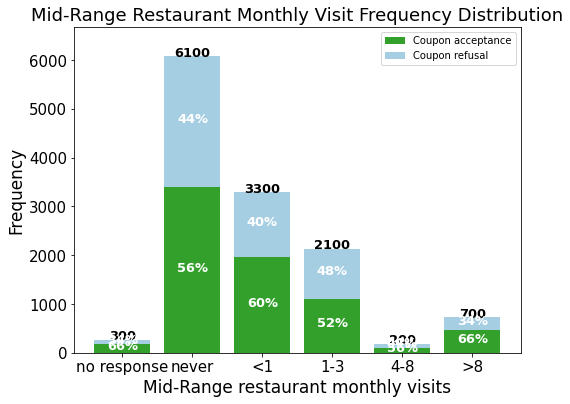

time: 204 ms (started: 2023-07-23 21:58:18 -07:00)


In [39]:
feature_column_name = 'Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding'
feature_column_name_label='Mid-Range Restaurant Monthly Visit'
xlabel='Mid-Range restaurant monthly visits'
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [0, 1, 2, 3, 4, 5]
xtick_dictionary = {1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-20


#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)

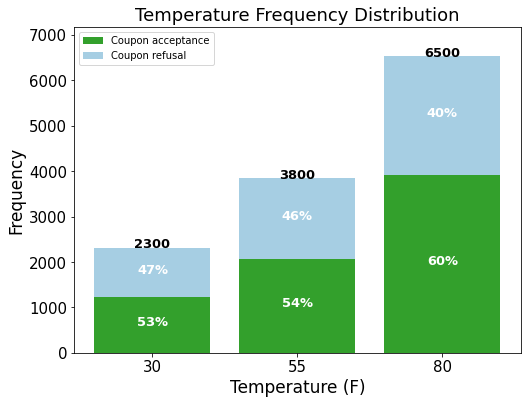

time: 159 ms (started: 2023-07-23 21:58:18 -07:00)


In [40]:
feature_column_name = 'temperature_ordinal_integer_encoding'
feature_column_name_label='Temperature'
xlabel='Temperature (F)'
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_acceptance_coupon_refusal_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [1, 2, 3,]
xtick_dictionary = {1: 30, 2: 55, 3: 80,}


title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-20


#get column name, coupon acceptance (frequency), coupon refusal (frequency)
df_income_coupon_acceptance_coupon_refusal = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_acceptance_coupon_refusal = icr.sort_data_frame(df=df_income_coupon_acceptance_coupon_refusal, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refusal_coupon_acceptance = df_income_coupon_acceptance_coupon_refusal.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refusal_coupon_acceptance, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)

<font size="5"><a id='[Data_Preprocessing]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Data_Preprocessing]'>**Data Preprocessing**</a> </font>

## Convert to Indicator Variables from Categorical Variables and Add Back to Numeric Variables

In [41]:
#get column name lists
column_name_list_numeric = list(df.select_dtypes('number').columns)
column_name_list_not_numeric = [column_name for column_name in df.columns if not column_name in column_name_list_numeric]

#get categorical features, numeric features, and target data frame
df_categorical_features = df.loc[:, column_name_list_not_numeric]
df_numeric_features = df.loc[:, column_name_list_numeric].drop(columns='Y')
df_target = df.loc[:, ['Y']]

#get category indicators data frame from df_categorical_features
df_category_indicator_features = pd.get_dummies(df_categorical_features)

del df_categorical_features

#combine category indicator features and numeric features
df_indicator_numeric_features = pd.concat([df_category_indicator_features, df_numeric_features], axis=1)

del df_numeric_features, 

p(df_indicator_numeric_features)

(12684, 140)


destination_Home  destination_No Urgent Place  destination_Work  \
11199                 1                            0                 0   
1474                  0                            0                 1   
10836                 1                            0                 0   
4567                  0                            1                 0   
5658                  0                            1                 0   
11343                 0                            0                 1   
9036                  1                            0                 0   
11050                 1                            0                 0   
784                   0                            0                 1   
1818                  0                            1                 0   

       passenger_Alone  passenger_Friend(s)  passenger_Kid(s)  \
11199                1                    0                 0   
1474                 1                    0                 0   
10836                1                    0                 0   
4567                 1                    0                 0   
5658                 1                    0                 0   
11343                1                    0                 0   
9036                 1                    0                 0   
11050                1                    0                 0   
784                  1                    0                 0   
1818                 0                    0                 1   

       passenger_Partner  weather_Rainy  weather_Snowy  weather_Sunny  \
11199                  0              0              0              1   
1474                   0              0              0              1   
10836                  0              0              0              1   
4567                   0              0              0              1   
5658                   0              0              0              1   
11343                  0              0              0              1   
9036                   0              0              1              0   
11050                  0              0              0              1   
784                    0              0              0              1   
1818                   0              0              0              1   

       time_10AM  time_10PM  time_2PM  time_6PM  time_7AM  \
11199          0          0         0         1         0   
1474           0          0         0         0         1   
10836          0          0         0         1         0   
4567           1          0         0         0         0   
5658           0          0         1         0         0   
11343          0          0         0         0         1   
9036           0          1         0         0         0   
11050          0          0         0         1         0   
784            0          0         0         0         1   
1818           1          0         0         0         0   

       coupon_venue_type_Bar  coupon_venue_type_Carry out & Take away  \
11199                      0                                        1   
1474                       1                                        0   
10836                      0                                        1   
4567                       1                                        0   
5658                       0                                        0   
11343                      0                                        0   
9036                       0                                        0   
11050                      0                                        0   
784                        0                                        1   
1818                       1                                        0   

       coupon_venue_type_Coffee House  coupon_venue_type_Restaurant(20-50)  \
11199                               0                                    0   
1474                                0   

time: 59.6 ms (started: 2023-07-23 21:58:18 -07:00)


## Get Data Frame Collection With Train and Test Features

In [42]:
data_frame_collection_filename='data_frame_collection_train_test_v' + filename_version + '.pkl'

df_readback = icr.return_processed_collection_if_it_exists(filename=data_frame_collection_filename, parse_dates=False)
if df_readback != None:
    data_frame_collection = df_readback
else:
    data_frame_collection = {}

    #split the data into train and test
    data_frame_collection['X_train'], data_frame_collection['X_test'], data_frame_collection['Y_train'], data_frame_collection['Y_test'] = \
    train_test_split(df_indicator_numeric_features, df_target, test_size=.2, random_state=200)

    del df_indicator_numeric_features

    #save preprocessed data frame collection
    data_frame_collection = icr.save_and_return_collection(data_frame_collection=data_frame_collection, filename=data_frame_collection_filename)

p(data_frame_collection['X_train'])

This file already exists
(10147, 140)


destination_Home  destination_No Urgent Place  destination_Work  \
8630                  0                            1                 0   
2418                  0                            1                 0   
10804                 0                            1                 0   
747                   0                            1                 0   
7333                  0                            1                 0   
10949                 0                            1                 0   
11937                 0                            1                 0   
735                   1                            0                 0   
67                    0                            1                 0   
3251                  0                            1                 0   

       passenger_Alone  passenger_Friend(s)  passenger_Kid(s)  \
8630                 0                    1                 0   
2418                 0                    1                 0   
10804                1                    0                 0   
747                  0                    1                 0   
7333                 0                    1                 0   
10949                0                    0                 1   
11937                1                    0                 0   
735                  1                    0                 0   
67                   0                    1                 0   
3251                 0                    1                 0   

       passenger_Partner  weather_Rainy  weather_Snowy  weather_Sunny  \
8630                   0              0              0              1   
2418                   0              0              0              1   
10804                  0              1              0              0   
747                    0              0              0              1   
7333                   0              0              0              1   
10949                  0              0              1              0   
11937                  0              1              0              0   
735                    0              0              0              1   
67                     0              0              0              1   
3251                   0              0              0              1   

       time_10AM  time_10PM  time_2PM  time_6PM  time_7AM  \
8630           0          0         0         1         0   
2418           0          0         1         0         0   
10804          0          0         1         0         0   
747            0          0         1         0         0   
7333           0          0         0         1         0   
10949          0          0         0         1         0   
11937          1          0         0         0         0   
735            0          0         0         1         0   
67             1          0         0         0         0   
3251           1          0         0         0         0   

       coupon_venue_type_Bar  coupon_venue_type_Carry out & Take away  \
8630                       0                                        0   
2418                       0                                        0   
10804                      0                                        1   
747                        0                                        0   
7333                       0                                        0   
10949                      1                                        0   
11937                      1                                        0   
735                        0                                        0   
67                         0                                        0   
3251                       0                                        0   

       coupon_venue_type_Coffee House  coupon_venue_type_Restaurant(20-50)  \
8630                                1                                    0   
2418                                1   

time: 37.5 ms (started: 2023-07-23 21:58:19 -07:00)


## Get Stratified 5-Fold Cross Validation X_train, X_test, Y_train, Y_test Collection

In [43]:
#stratified 5-fold cross validation train-test data row selection

#Stratified 5-Fold object
StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

#get stratified 5-fold data frame splits
stratified_fold_number_X_train_X_test_Y_train_Y_test_collection = {}


for index, (train_index, test_index) in enumerate(StratifiedKFold_5_splits.split(data_frame_collection['X_train'], data_frame_collection['Y_train'].loc[:, 'Y'])):
    print('fold ' + str(index) + " TRAIN:", train_index, "TEST:", test_index)
    stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)] = \
    {'X_train' : data_frame_collection['X_train'].iloc[train_index, :], \
     'X_test' : data_frame_collection['X_train'].iloc[test_index, :], \
     'Y_train' : data_frame_collection['Y_train'].loc[:, 'Y'].iloc[train_index], \
     'Y_test' : data_frame_collection['Y_train'].loc[:, 'Y'].iloc[test_index]}

#use .loc for selection by index label, .iloc for selection by index location

print()
p(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['X_train'])

fold 0 TRAIN: [ 2028  2030  2031 ... 10144 10145 10146] TEST: [   0    1    2 ... 2027 2029 2032]
fold 1 TRAIN: [    0     1     2 ... 10144 10145 10146] TEST: [2028 2030 2031 ... 4095 4101 4102]
fold 2 TRAIN: [    0     1     2 ... 10144 10145 10146] TEST: [4009 4010 4012 ... 6131 6133 6135]
fold 3 TRAIN: [    0     1     2 ... 10144 10145 10146] TEST: [6036 6037 6043 ... 8126 8127 8128]
fold 4 TRAIN: [   0    1    2 ... 8126 8127 8128] TEST: [ 8099  8105  8109 ... 10144 10145 10146]

(8117, 140)


destination_Home  destination_No Urgent Place  destination_Work  \
11981                 0                            1                 0   
3996                  0                            0                 1   
1301                  0                            0                 1   
9720                  1                            0                 0   
752                   0                            1                 0   
10949                 0                            1                 0   
11937                 0                            1                 0   
735                   1                            0                 0   
67                    0                            1                 0   
3251                  0                            1                 0   

       passenger_Alone  passenger_Friend(s)  passenger_Kid(s)  \
11981                0                    1                 0   
3996                 1                    0                 0   
1301                 1                    0                 0   
9720                 1                    0                 0   
752                  0                    0                 0   
10949                0                    0                 1   
11937                1                    0                 0   
735                  1                    0                 0   
67                   0                    1                 0   
3251                 0                    1                 0   

       passenger_Partner  weather_Rainy  weather_Snowy  weather_Sunny  \
11981                  0              0              0              1   
3996                   0              0              0              1   
1301                   0              0              0              1   
9720                   0              1              0              0   
752                    1              0              0              1   
10949                  0              0              1              0   
11937                  0              1              0              0   
735                    0              0              0              1   
67                     0              0              0              1   
3251                   0              0              0              1   

       time_10AM  time_10PM  time_2PM  time_6PM  time_7AM  \
11981          1          0         0         0         0   
3996           0          0         0         0         1   
1301           0          0         0         0         1   
9720           0          0         0         1         0   
752            1          0         0         0         0   
10949          0          0         0         1         0   
11937          1          0         0         0         0   
735            0          0         0         1         0   
67             1          0         0         0         0   
3251           1          0         0         0         0   

       coupon_venue_type_Bar  coupon_venue_type_Carry out & Take away  \
11981                      0                                        1   
3996                       0                                        0   
1301                       0                                        0   
9720                       1                                        0   
752                        1                                        0   
10949                      1                                        0   
11937                      1                                        0   
735                        0                                        0   
67                         0                                        0   
3251                       0                                        0   

       coupon_venue_type_Coffee House  coupon_venue_type_Restaurant(20-50)  \
11981                               0                                    0   
3996                                0   

time: 70.4 ms (started: 2023-07-23 21:58:19 -07:00)


## Standardize and Scale Features of Stratified Data Frame Collection for Hyperparameter Tuning

In [44]:
#standardize and scale fold 0 thru 4 train and test sets

number_of_folds=5

for fold_number in range(number_of_folds):
    
    standard_scaler = StandardScaler()
    standardized_scaled_stratified_fold_number_X_train_ndarray=standard_scaler.fit_transform(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(fold_number)]['X_train'])
    

    stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(fold_number)]['X_train'] = \
    pd.DataFrame(standardized_scaled_stratified_fold_number_X_train_ndarray, 
                 columns=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(fold_number)]['X_train'].columns, 
                 index=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(fold_number)]['X_train'].index)
    
    
    standardized_scaled_stratified_fold_number_X_test_ndarray=standard_scaler.transform(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(fold_number)]['X_test'])
    
    stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(fold_number)]['X_test'] = \
    pd.DataFrame(standardized_scaled_stratified_fold_number_X_test_ndarray, 
                 columns=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(fold_number)]['X_test'].columns, 
                 index=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(fold_number)]['X_test'].index)

print()
p(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['X_test'])


(2030, 140)


destination_Home  destination_No Urgent Place  destination_Work  \
8630          -0.587167                     1.005312         -0.571612   
2418          -0.587167                     1.005312         -0.571612   
10804         -0.587167                     1.005312         -0.571612   
747           -0.587167                     1.005312         -0.571612   
7333          -0.587167                     1.005312         -0.571612   
1460          -0.587167                     1.005312         -0.571612   
8449          -0.587167                    -0.994716          1.749437   
11224          1.703094                    -0.994716         -0.571612   
5085          -0.587167                     1.005312         -0.571612   
7156          -0.587167                     1.005312         -0.571612   

       passenger_Alone  passenger_Friend(s)  passenger_Kid(s)  \
8630         -1.159860             1.683508         -0.296765   
2418         -1.159860             1.683508         -0.296765   
10804         0.862173            -0.593998         -0.296765   
747          -1.159860             1.683508         -0.296765   
7333         -1.159860             1.683508         -0.296765   
1460         -1.159860             1.683508         -0.296765   
8449          0.862173            -0.593998         -0.296765   
11224         0.862173            -0.593998         -0.296765   
5085         -1.159860             1.683508         -0.296765   
7156         -1.159860             1.683508         -0.296765   

       passenger_Partner  weather_Rainy  weather_Snowy  weather_Sunny  \
8630           -0.304077      -0.325822      -0.350262       0.508187   
2418           -0.304077      -0.325822      -0.350262       0.508187   
10804          -0.304077       3.069164      -0.350262      -1.967778   
747            -0.304077      -0.325822      -0.350262       0.508187   
7333           -0.304077      -0.325822      -0.350262       0.508187   
1460           -0.304077      -0.325822      -0.350262       0.508187   
8449           -0.304077      -0.325822       2.855008      -1.967778   
11224          -0.304077       3.069164      -0.350262      -1.967778   
5085           -0.304077      -0.325822      -0.350262       0.508187   
7156           -0.304077      -0.325822      -0.350262       0.508187   

       time_10AM  time_10PM  time_2PM  time_6PM  time_7AM  \
8630   -0.469292  -0.434891 -0.434490  1.707507 -0.571612   
2418   -0.469292  -0.434891  2.301549 -0.585649 -0.571612   
10804  -0.469292  -0.434891  2.301549 -0.585649 -0.571612   
747    -0.469292  -0.434891  2.301549 -0.585649 -0.571612   
7333   -0.469292  -0.434891 -0.434490  1.707507 -0.571612   
1460   -0.469292  -0.434891  2.301549 -0.585649 -0.571612   
8449   -0.469292  -0.434891 -0.434490 -0.585649  1.749437   
11224  -0.469292   2.299429 -0.434490 -0.585649 -0.571612   
5085   -0.469292  -0.434891  2.301549 -0.585649 -0.571612   
7156   -0.469292  -0.434891  2.301549 -0.585649 -0.571612   

       coupon_venue_type_Bar  coupon_venue_type_Carry out & Take away  \
8630               -0.438291                                -0.481562   
2418               -0.438291                                -0.481562   
10804              -0.438291                                 2.076577   
747                -0.438291                                -0.481562   
7333               -0.438291                                -0.481562   
1460               -0.438291                                -0.481562   
8449               -0.438291                                -0.481562   
11224              -0.438291                                -0.481562   
5085               -0.438291                                -0.481562   
7156               -0.438291                                -0.481562   

       coupon_venue_type_Coffee House  coupon_venue_type_Restaurant(20-50)  \
8630                         1.466632                            -0.363860   
2418                         1.466632   

time: 133 ms (started: 2023-07-23 21:58:19 -07:00)


## Standardize and Scale Features of Data Frame Collection for Campaign Model Train and Test

In [45]:
data_frame_collection_filename='data_frame_collection_train_test_standardize_scale_v' + filename_version + '.pkl'

df_readback = icr.return_processed_collection_if_it_exists(filename=data_frame_collection_filename, parse_dates=False)
if df_readback != None:
    data_frame_collection = df_readback
else:
    #standardize and scale feature data frame
    standard_scaler = StandardScaler()
    standardized_scaled_data_frame_collection_X_train_ndarray = standard_scaler.fit_transform(data_frame_collection['X_train'])
    data_frame_collection['X_train'] = pd.DataFrame(standardized_scaled_data_frame_collection_X_train_ndarray, columns=data_frame_collection['X_train'].columns, index=data_frame_collection['X_train'].index)


    standardized_scaled_df_collection_X_test_ndarray = standard_scaler.transform(data_frame_collection['X_test'])
    data_frame_collection['X_test'] = pd.DataFrame(standardized_scaled_df_collection_X_test_ndarray, columns=data_frame_collection['X_test'].columns, index=data_frame_collection['X_test'].index)

    data_frame_collection = icr.save_and_return_collection(data_frame_collection=data_frame_collection, filename=data_frame_collection_filename)

    del standardized_scaled_data_frame_collection_X_train_ndarray, standardized_scaled_df_collection_X_test_ndarray, standard_scaler

print(data_frame_collection['X_train'].shape, data_frame_collection['X_test'].shape, data_frame_collection['Y_train'].shape, data_frame_collection['Y_test'].shape)
p(data_frame_collection['X_train'])

This file already exists
(10147, 140) (2537, 140) (10147, 1) (2537, 1)
(10147, 140)


destination_Home  destination_No Urgent Place  destination_Work  \
8630          -0.587858                     1.003257         -0.569346   
2418          -0.587858                     1.003257         -0.569346   
10804         -0.587858                     1.003257         -0.569346   
747           -0.587858                     1.003257         -0.569346   
7333          -0.587858                     1.003257         -0.569346   
10949         -0.587858                     1.003257         -0.569346   
11937         -0.587858                     1.003257         -0.569346   
735            1.701090                    -0.996753         -0.569346   
67            -0.587858                     1.003257         -0.569346   
3251          -0.587858                     1.003257         -0.569346   

       passenger_Alone  passenger_Friend(s)  passenger_Kid(s)  \
8630         -1.154170             1.678978         -0.298862   
2418         -1.154170             1.678978         -0.298862   
10804         0.866424            -0.595600         -0.298862   
747          -1.154170             1.678978         -0.298862   
7333         -1.154170             1.678978         -0.298862   
10949        -1.154170            -0.595600          3.346030   
11937         0.866424            -0.595600         -0.298862   
735           0.866424            -0.595600         -0.298862   
67           -1.154170             1.678978         -0.298862   
3251         -1.154170             1.678978         -0.298862   

       passenger_Partner  weather_Rainy  weather_Snowy  weather_Sunny  \
8630           -0.304693      -0.327333      -0.350292       0.509468   
2418           -0.304693      -0.327333      -0.350292       0.509468   
10804          -0.304693       3.054995      -0.350292      -1.962830   
747            -0.304693      -0.327333      -0.350292       0.509468   
7333           -0.304693      -0.327333      -0.350292       0.509468   
10949          -0.304693      -0.327333       2.854765      -1.962830   
11937          -0.304693       3.054995      -0.350292      -1.962830   
735            -0.304693      -0.327333      -0.350292       0.509468   
67             -0.304693      -0.327333      -0.350292       0.509468   
3251           -0.304693      -0.327333      -0.350292       0.509468   

       time_10AM  time_10PM  time_2PM  time_6PM  time_7AM  \
8630   -0.468919  -0.436673 -0.434912  1.705934 -0.569346   
2418   -0.468919  -0.436673  2.299318 -0.586189 -0.569346   
10804  -0.468919  -0.436673  2.299318 -0.586189 -0.569346   
747    -0.468919  -0.436673  2.299318 -0.586189 -0.569346   
7333   -0.468919  -0.436673 -0.434912  1.705934 -0.569346   
10949  -0.468919  -0.436673 -0.434912  1.705934 -0.569346   
11937   2.132567  -0.436673 -0.434912 -0.586189 -0.569346   
735    -0.468919  -0.436673 -0.434912  1.705934 -0.569346   
67      2.132567  -0.436673 -0.434912 -0.586189 -0.569346   
3251    2.132567  -0.436673 -0.434912 -0.586189 -0.569346   

       coupon_venue_type_Bar  coupon_venue_type_Carry out & Take away  \
8630               -0.435552                                -0.480608   
2418               -0.435552                                -0.480608   
10804              -0.435552                                 2.080699   
747                -0.435552                                -0.480608   
7333               -0.435552                                -0.480608   
10949               2.295936                                -0.480608   
11937               2.295936                                -0.480608   
735                -0.435552                                -0.480608   
67                 -0.435552                                -0.480608   
3251               -0.435552                                -0.480608   

       coupon_venue_type_Coffee House  coupon_venue_type_Restaurant(20-50)  \
8630                         1.478469                            -0.364148   
2418                         1.478469   

time: 70 ms (started: 2023-07-23 21:58:19 -07:00)


## Convert to Y Train Data Frame from Y Test Data Frame Collection

In [46]:
#convert to y_actual data frame from y_actual data frame collection
data_frame_list_stratified_fold_number_Y_test = [stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(fold_number)]['Y_test'] for fold_number in range(5)]

df_stratified_fold_number_y_test = pd.concat(data_frame_list_stratified_fold_number_Y_test, axis=0, join='outer', ignore_index=False, copy=True).to_frame()
p(df_stratified_fold_number_y_test)

(10147, 1)


Y
8630   1
2418   1
10804  0
747    1
7333   1
10949  0
11937  0
735    1
67     1
3251   1

time: 4.82 ms (started: 2023-07-23 21:58:19 -07:00)


<font size="5"><a id='[Modeling]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font> 

<font size="6"><a id='[Modeling]'>**Modeling**</a> </font>

## Initialize Filename & Results Collection Variables

In [47]:
classifier_name_list = ['random_forest_classifier', 'gradient_boosting_classifier']

#filename
grid_search_models_filename_collection={}
grid_search_models_local_optimum_filename_collection={}

model_filename_collection = {}
model_cross_validation_results_filename_collection = {}

cross_validation_model_collection_filename_collection = {}
model_cross_validation_prediction_probability_collection_filename_collection = {}
model_cross_validation_prediction_collection_filename_collection = {}

learning_curve_results_filename_collection = {}

for classifier_name in classifier_name_list:
    grid_search_models_filename_collection[classifier_name]='stratified_5_fold_grid_search_cross_validation_' + classifier_name + '_v' + filename_version + '.pkl'
    grid_search_models_local_optimum_filename_collection[classifier_name]='stratified_5_fold_grid_search_cross_validation_' + classifier_name + '_local_optimum_v' + filename_version + '.pkl'
    
    model_filename_collection[classifier_name]='best_stratified_5_fold_grid_search_cross_validation_'+ classifier_name + '_v' + filename_version + '.pkl'
    model_cross_validation_results_filename_collection[classifier_name]='best_' + classifier_name + '_stratified_5_fold_cross_validation_results_v' + filename_version + '.pkl'

    cross_validation_model_collection_filename_collection[classifier_name] = 'stratified_5_fold_cross_validation_' + str(classifier_name) + '_collection_v' + filename_version + '.pkl'
    model_cross_validation_prediction_probability_collection_filename_collection[classifier_name] = 'stratified_5_fold_cross_validation_' + str(classifier_name) + '_prediction_probability_collection_v' + filename_version + '.pkl'
    model_cross_validation_prediction_collection_filename_collection[classifier_name] = 'stratified_5_fold_cross_validation_' + str(classifier_name) + '_prediction_collection_v' + filename_version + '.pkl'
    
    learning_curve_results_filename_collection[classifier_name]='learning_curve_results_best_' + classifier_name + '_v' + filename_version + '.pkl'


test_random_forest_metric_replicate_filename_collection={}; column_name_list=['Coffee House', 'Bar', 'Takeout', 'Low-Cost Restaurant', 'Mid-Range Restaurant']; model_name='random_forest'
for column_name in column_name_list:
    test_random_forest_metric_replicate_filename_collection[column_name]='df_test_'+str(model_name)+'_number_metric_estimated_'+str(number_of_replicates)+'_metric_replicates_from_'+str(number_of_replicates)+'_nonparametric_subsamples_'+str(column_name.lower().replace(' ','_'))+'_v'+str(filename_version)+'.csv'

model_version=filename_version


time: 1.74 ms (started: 2023-07-23 21:58:19 -07:00)


## Initialize Other Variables

In [48]:
StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection = {}

stratified_5_fold_cross_validation_model_classifier_prediction_probability_data_frame_collection = {}

stratified_5_fold_cross_validation_model_classifier_prediction_data_frame_collection = {}

model_stratified_5_fold_cross_validation_results_collection = {}

time: 745 µs (started: 2023-07-23 21:58:19 -07:00)


<font size="5"><a id='[Modeling_1]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Modeling_1]'>**Modeling 1**</a> </font>

## Get Random Forest Classifier Stratified 5-Fold Cross Validation Grid Search by Accuracy

In [49]:
#get grid search stratified 5-fold cross validation results
models_readback = icr.return_saved_model_if_it_exists(filename=grid_search_models_filename_collection['random_forest_classifier'])
if models_readback != None:
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier = models_readback
else:
    #random forest hyperparameter tuning using 5-fold cross validation

    # Create the parameter grid based on the results of random search
    param_grid = {
        'n_estimators': [200], #more is better, otherwise these are just random variation
        'criterion':['gini'],
        'max_depth': [3, 5, 10, 20, 25, None],
        'min_samples_split': [1, 10, 50, 100],
        'min_samples_leaf':[1],
        'min_weight_fraction_leaf':[0.0],
        'max_features':['auto'],
        'max_leaf_nodes':[None],
        'min_impurity_decrease':[0.0],
        'bootstrap': [False ,True],
        'oob_score': [False],
        'n_jobs': [None],
        'warm_start':[False],
        'class_weight':[None],
        'ccp_alpha':[0.0],
        'max_samples':[None],
    }

    # Create a base model
    random_forest_classifier = RandomForestClassifier(random_state=200)

    # Instantiate the Stratified 5-Fold Grid Search Cross Validation
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier = GridSearchCV(estimator=random_forest_classifier, 
                                                                                           param_grid=param_grid, 
                                                                                           cv=StratifiedKFold_5_splits,
                                                                                           n_jobs=-1, 
                                                                                           verbose=0,
                                                                                           scoring=None)
    # Fit the grid search to the data
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier.fit(data_frame_collection['X_train'], data_frame_collection['Y_train'].loc[:, 'Y'])

    #save it
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier = icr.save_and_return_model(stratified_5_fold_grid_search_cross_validation_random_forest_classifier, 
                                                                                                        filename=grid_search_models_filename_collection['random_forest_classifier'])

print()
print('Global Optimum Grid Search Cross Validation Object:')
print(stratified_5_fold_grid_search_cross_validation_random_forest_classifier)
print()
print('Best Random Forest Classifier by GridSearchCV Global Optimum:')
print(stratified_5_fold_grid_search_cross_validation_random_forest_classifier.best_estimator_)

This file already exists

Global Optimum Grid Search Cross Validation Object:
GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=200), n_jobs=-1,
             param_grid={'bootstrap': [False, True], 'ccp_alpha': [0.0],
                         'class_weight': [None], 'criterion': ['gini'],
                         'max_depth': [3, 5, 10, 20, 25, None],
                         'max_features': ['auto'], 'max_leaf_nodes': [None],
                         'max_samples': [None], 'min_impurity_decrease': [0.0],
                         'min_samples_leaf': [1],
                         'min_samples_split': [1, 10, 50, 100],
                         'min_weight_fraction_leaf': [0.0],
                         'n_estimators': [200], 'n_jobs': [None],
                         'oob_score': [False], 'warm_start': [False]})

Best Random Forest Classifier by GridSearchCV Global Optimum:
RandomForestClassifier(boot

## Get Random Forest Classifier Stratified 5-Fold Cross Validation Grid Search by Accuracy For Local Optimum

In [50]:
models_readback = icr.return_saved_model_if_it_exists(filename=grid_search_models_local_optimum_filename_collection['random_forest_classifier'])
if models_readback != None:
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum = models_readback
else:
    #random forest hyperparameter tuning using 5-fold cross validation
    param_grid = {
        'bootstrap': [False ,True],
        'criterion':['gini'],
        'max_features':['auto'],
        'max_depth': [3, 5, 10, 20, 25, None], # lower numbers reduce growth
        'min_samples_split': [1, 5, 10, 15, 20], # higher numbers reduce growth
        'min_samples_leaf':[1],
        'n_estimators': [200], #more is better, otherwise these are just random variation
        'warm_start':[False]
    }
    #min_samples_leaf can be used as an alternative to 'min_samples_split'

    
    # Create a base model
    random_forest_classifier = RandomForestClassifier(random_state=200)

    # Instantiate the Stratified 5-Fold Grid Search Cross Validation
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum = GridSearchCV(estimator=random_forest_classifier, 
                                                                                                         param_grid=param_grid, 
                                                                                                         cv=StratifiedKFold_5_splits,
                                                                                                         n_jobs=-1, 
                                                                                                         verbose=0,
                                                                                                         scoring=None)
    # Fit the grid search to the data
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum.fit(data_frame_collection['X_train'], data_frame_collection['Y_train'].loc[:, 'Y'])

    #save it
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum = icr.save_and_return_model(stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum, 
                                                                                                                      filename=grid_search_models_local_optimum_filename_collection['random_forest_classifier'])

#del stratified_5_fold_grid_search_cross_validation_random_forest_classifier

print()
print('Local Optimum Grid Search Cross Validation Object:')
print(stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum)

print()
print('Best Random Forest Classifier by GridSearchCV Local Optimum:')
print(stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum.best_estimator_)

This file already exists

Local Optimum Grid Search Cross Validation Object:
GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=200), n_jobs=-1,
             param_grid={'bootstrap': [False, True], 'criterion': ['gini'],
                         'max_depth': [3, 5, 10, 20, 25, None],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [1, 5, 10, 15, 20],
                         'n_estimators': [200], 'warm_start': [False]})

Best Random Forest Classifier by GridSearchCV Local Optimum:
RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=5,
                       n_estimators=200, random_state=200)
time: 59.8 ms (started: 2023-07-23 21:58:19 -07:00)


In [51]:
stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=5,
                       n_estimators=200, random_state=200)

time: 2.52 ms (started: 2023-07-23 21:58:19 -07:00)


In [52]:
stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=200), n_jobs=-1,
             param_grid={'bootstrap': [False, True], 'criterion': ['gini'],
                         'max_depth': [3, 5, 10, 20, 25, None],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [1, 5, 10, 15, 20],
                         'n_estimators': [200], 'warm_start': [False]})>

time: 2.76 ms (started: 2023-07-23 21:58:19 -07:00)


## Get Best Random Forest Classifier by Accuracy

In [53]:
#get best random forest classifier
model_readback = icr.return_saved_model_if_it_exists(filename=model_filename_collection['random_forest_classifier'])
if model_readback != None:
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier = model_readback
else:   
    #add model environment data to model

    #get best random forest classifier from grid search cross validation
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier = stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum.best_estimator_

    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.version = model_version
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.pandas_version = pd.__version__
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.numpy_version = np.__version__
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.sklearn_version = sklearn_version
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.X_columns = [column_name for column_name in data_frame_collection['X_train'].columns]
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.build_datetime = datetime.datetime.now()

    
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier = icr.save_and_return_model(best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier, 
                                                                                                              filename=model_filename_collection['random_forest_classifier'])
    
best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier

This file already exists


RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=5,
                       n_estimators=200, random_state=200)

time: 57.9 ms (started: 2023-07-23 21:58:19 -07:00)


## Get Stratified 5-Fold Cross Validation Random Forest Classifier Collection

In [54]:
models_readback = icr.return_saved_model_if_it_exists(filename=cross_validation_model_collection_filename_collection['random_forest_classifier'])
if models_readback != None:
    stratified_5_fold_cross_validation_random_forest_classifier_collection = models_readback
else:
    stratified_5_fold_cross_validation_random_forest_classifier_collection = {}
    for index in range(5):

        #create random forest classifier
        random_forest_classifier=RandomForestClassifier(bootstrap=False, 
                                                        max_depth=25, 
                                                        min_samples_split=5, 
                                                        n_estimators=200,
                                                        min_samples_leaf=1,
                                                        max_features='auto',
                                                        criterion='gini',
                                                        warm_start='False',
                                                        random_state=200)

        #train random forest classifier and save random forest classifer per fold
        random_forest_classifier.fit(X=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_train'],
                                     y=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['Y_train'])

        stratified_5_fold_cross_validation_random_forest_classifier_collection['fold ' + str(index)] = random_forest_classifier

    #save stratified 5-fold cross validation random forest classifier collection
    stratified_5_fold_cross_validation_random_forest_classifier_collection = icr.save_and_return_model(stratified_5_fold_cross_validation_random_forest_classifier_collection, 
                                                                                                       filename=cross_validation_model_collection_filename_collection['random_forest_classifier'])
stratified_5_fold_cross_validation_random_forest_classifier_collection

This file already exists


{'fold 0': RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=5,
                        n_estimators=200, random_state=200, warm_start='False'),
 'fold 1': RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=5,
                        n_estimators=200, random_state=200, warm_start='False'),
 'fold 2': RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=5,
                        n_estimators=200, random_state=200, warm_start='False'),
 'fold 3': RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=5,
                        n_estimators=200, random_state=200, warm_start='False'),
 'fold 4': RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=5,
                        n_estimators=200, random_state=200, warm_start='False')}

time: 217 ms (started: 2023-07-23 21:58:19 -07:00)


## Get Stratified 5-Fold Cross Validation Random Forest Classifier Prediction Probability Collection

In [55]:
prediction_probability_ndarray_collection = icr.return_processed_collection_if_it_exists(filename=model_cross_validation_prediction_probability_collection_filename_collection['random_forest_classifier'])
if prediction_probability_ndarray_collection != None:
    stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection = prediction_probability_ndarray_collection
else:
    stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection = {}
    for index in range(5):
        #get predictions for test per fold
        stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection['fold ' + str(index)] = \
        stratified_5_fold_cross_validation_random_forest_classifier_collection['fold ' + str(index)]\
        .predict_proba(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_test'])

    #save stratified 5-fold cross validation random forest classifier prediction collection
    stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection = icr.save_and_return_collection(data_frame_collection=stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection, 
                                                                                                                                   filename=model_cross_validation_prediction_probability_collection_filename_collection['random_forest_classifier'])
stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection['fold 0']

This file already exists


array([[0.22768785, 0.77231215],
       [0.28875   , 0.71125   ],
       [0.59625   , 0.40375   ],
       ...,
       [0.75791667, 0.24208333],
       [0.14683716, 0.85316284],
       [0.51916667, 0.48083333]])

time: 4.61 ms (started: 2023-07-23 21:58:19 -07:00)


## Get Stratified 5-Fold Cross Validation Random Forest Classifier Prediction Probability Series

In [56]:
#get data frame list
data_frame_list_stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability = \
[pd.DataFrame(stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection['fold ' + str(number)]).loc[:, 1] for number in range(5)]

stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['random_forest_classifier'] = \
pd.concat(data_frame_list_stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability)

p(stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['random_forest_classifier'])

(10147,)


0       0.772312
1       0.711250
2       0.403750
3       0.824488
4       0.710913
2024    0.261250
2025    0.652119
2026    0.669310
2027    0.911190
2028    0.640171
Name: 1, dtype: float64

time: 3.89 ms (started: 2023-07-23 21:58:19 -07:00)


In [57]:
warnings.filterwarnings('ignore')

time: 476 µs (started: 2023-07-23 21:58:19 -07:00)


<font size="5"><a id='[Modeling_2]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Modeling_2]'>**Modeling 2**</a> </font>

## Get Gradient Boosting Classifier Stratified 5-Fold Grid Seach Cross Validation by Accuracy Score

In [58]:
#get grid search stratified 5-fold cross validation results
models_readback = icr.return_saved_model_if_it_exists(filename=grid_search_models_filename_collection['gradient_boosting_classifier'])
if models_readback != None:
    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = models_readback
else:
    gradient_boosting_classifier = GradientBoostingClassifier(random_state=200)
    param_grid = {'loss' : ['log_loss', 'exponential'],
                  'learning_rate' : [0.01, 0.1, 1, 10, 100],
                  'n_estimators' : [5, 50, 250, 500],
                  'subsample' : [1.0],
                  'criterion' : ['friedman_mse', 'squared_error'],
                  'min_samples_split' : [2],
                  'min_samples_leaf' : [1],
                  'min_weight_fraction_leaf' : [0.0],
                  'max_depth' : [1, 3, 5, 7, 9, None],
                  'min_impurity_decrease' : [0.0],
                  'init' : [None],
                  'max_features' : [None],
                  'max_leaf_nodes' : [None],
                  'warm_start' : [False],
                  'n_iter_no_change' : [None],
                 }

    # Instantiate the Stratified 5-Fold Grid Search Cross Validation
    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = GridSearchCV(estimator=gradient_boosting_classifier, 
                                                                                               param_grid=param_grid, 
                                                                                               cv=StratifiedKFold_5_splits,
                                                                                               n_jobs=-1, 
                                                                                               verbose=0,
                                                                                               scoring=None,
                                                                                               pre_dispatch="2*n_jobs")

    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.fit(X=data_frame_collection['X_train'], 
                                                                                    y=data_frame_collection['Y_train'].loc[:, 'Y'],
                                                                                    groups=None)

    #save it
    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = icr.save_and_return_model(stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier, 
                                                                                                             filename=grid_search_models_filename_collection['gradient_boosting_classifier'],
                                                                                                             add_compressed_file=False)
    
stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier

This file already exists


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(random_state=200), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'init': [None],
                         'learning_rate': [0.01, 0.1, 1, 10, 100],
                         'loss': ['log_loss', 'exponential'],
                         'max_depth': [1, 3, 5, 7, 9, None],
                         'max_features': [None], 'max_leaf_nodes': [None],
                         'min_impurity_decrease': [0.0],
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'min_weight_fraction_leaf': [0.0],
                         'n_estimators': [5, 50, 250, 500],
                         'n_iter_no_change': [None], 'subsample': [1.0],
                         'warm_start': [False]})

time: 16.7 ms (started: 2023-07-23 21:58:19 -07:00)


## Get Best Gradient Boosting Classifier by Accuracy Score

In [59]:
model_readback = icr.return_saved_model_if_it_exists(filename=model_filename_collection['gradient_boosting_classifier'])
if model_readback != None:
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = model_readback
else:   
    #add model environment data to model

    #get best random forest classifier from grid search cross validation
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.best_estimator_

    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.version = model_version
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.pandas_version = pd.__version__
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.numpy_version = np.__version__
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.sklearn_version = sklearn_version
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.X_columns = [column_name for column_name in data_frame_collection['X_train'].columns]
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.build_datetime = datetime.datetime.now()    

    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = icr.save_and_return_model(best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier, 
                                                                                                                  filename=model_filename_collection['gradient_boosting_classifier'],
                                                                                                                  add_compressed_file=False)
    
best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier

This file already exists


GradientBoostingClassifier(loss='exponential', max_depth=9, n_estimators=250,
                           random_state=200)

time: 15.7 ms (started: 2023-07-23 21:58:19 -07:00)


## Get Stratified 5-Fold Cross Validation Gradient Boosting Classifier Collection

In [60]:
models_readback = icr.return_saved_model_if_it_exists(filename=cross_validation_model_collection_filename_collection['gradient_boosting_classifier'])
if models_readback != None:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_collection = models_readback
else:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_collection = {}
    for index in range(5):

        #create gradient boosting classifier
        gradient_boosting_classifier = GradientBoostingClassifier(criterion='squared_error',
                                                                  loss='exponential',
                                                                  learning_rate = 0.1, 
                                                                  max_depth = 9, 
                                                                  n_estimators = 250,
                                                                  random_state=200,
                                                                  subsample=1.0,
                                                                  min_samples_split=2,
                                                                  min_samples_leaf=1,
                                                                  min_weight_fraction_leaf=0.0,
                                                                  min_impurity_decrease=0.0,
                                                                  init=None,
                                                                  max_features=None,
                                                                  verbose=0,
                                                                  max_leaf_nodes=None,
                                                                  warm_start=False,
                                                                  n_iter_no_change=None)

        
        #train gradient boosting classifier and save gradient boosting classifer per fold
        gradient_boosting_classifier.fit(X=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_train'],
                                         y=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['Y_train'])

        stratified_5_fold_cross_validation_gradient_boosting_classifier_collection['fold ' + str(index)] = gradient_boosting_classifier


    #save stratified 5-fold cross validation gradient boosting classifier collection
    stratified_5_fold_cross_validation_gradient_boosting_classifier_collection = icr.save_and_return_model(stratified_5_fold_cross_validation_gradient_boosting_classifier_collection, 
                                                                                                           filename=cross_validation_model_collection_filename_collection['gradient_boosting_classifier'])
stratified_5_fold_cross_validation_gradient_boosting_classifier_collection

This file already exists


{'fold 0': GradientBoostingClassifier(criterion='squared_error', loss='exponential',
                            max_depth=9, n_estimators=250, random_state=200),
 'fold 1': GradientBoostingClassifier(criterion='squared_error', loss='exponential',
                            max_depth=9, n_estimators=250, random_state=200),
 'fold 2': GradientBoostingClassifier(criterion='squared_error', loss='exponential',
                            max_depth=9, n_estimators=250, random_state=200),
 'fold 3': GradientBoostingClassifier(criterion='squared_error', loss='exponential',
                            max_depth=9, n_estimators=250, random_state=200),
 'fold 4': GradientBoostingClassifier(criterion='squared_error', loss='exponential',
                            max_depth=9, n_estimators=250, random_state=200)}

time: 53.1 ms (started: 2023-07-23 21:58:19 -07:00)


## Get Stratified 5-Fold Cross Validation Gradient Boosting Classifier Prediction Probability Collection

In [61]:
prediction_probability_ndarray_collection = icr.return_processed_collection_if_it_exists(filename=model_cross_validation_prediction_probability_collection_filename_collection['gradient_boosting_classifier'])
if prediction_probability_ndarray_collection != None:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection = prediction_probability_ndarray_collection
else:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection = {}
    for index in range(5):
        #get predictions for test per fold
        stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection['fold ' + str(index)] = \
        stratified_5_fold_cross_validation_gradient_boosting_classifier_collection['fold ' + str(index)]\
        .predict_proba(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_test'])
    

    #save stratified 5-fold cross validation random forest classifier prediction probability collection
    stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection = icr.save_and_return_collection(data_frame_collection=stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection, 
                                                                                                                                   filename=model_cross_validation_prediction_probability_collection_filename_collection['gradient_boosting_classifier'])
stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection['fold 0']

This file already exists


array([[2.48407057e-01, 7.51592943e-01],
       [2.05103256e-02, 9.79489674e-01],
       [9.98658831e-01, 1.34116928e-03],
       ...,
       [9.99920319e-01, 7.96805318e-05],
       [3.63162218e-05, 9.99963684e-01],
       [4.67138033e-02, 9.53286197e-01]])

time: 4.49 ms (started: 2023-07-23 21:58:19 -07:00)


## Get Stratified 5-Fold Cross Validation Gradient Boosting Classifier Prediction Probability Data Frame

In [62]:
#get data frame list
data_frame_list_stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability = \
[pd.DataFrame(stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection['fold ' + str(number)]).loc[:, 1] for number in range(5)]

stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['gradient_boosting_classifier'] = \
pd.concat(data_frame_list_stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability)

p(stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['gradient_boosting_classifier'])

(10147,)


0       0.751593
1       0.979490
2       0.001341
3       0.993639
4       0.826168
2024    0.577856
2025    0.947631
2026    0.991084
2027    0.999991
2028    0.938312
Name: 1, dtype: float64

time: 4.38 ms (started: 2023-07-23 21:58:19 -07:00)


<font size="5"><a id='[Modeling_Train_Results]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Modeling_Train_Results]'>**Modeling Train Results**</a> </font>

# Learning Curve for Random Forest and Gradient Boosting Classifier

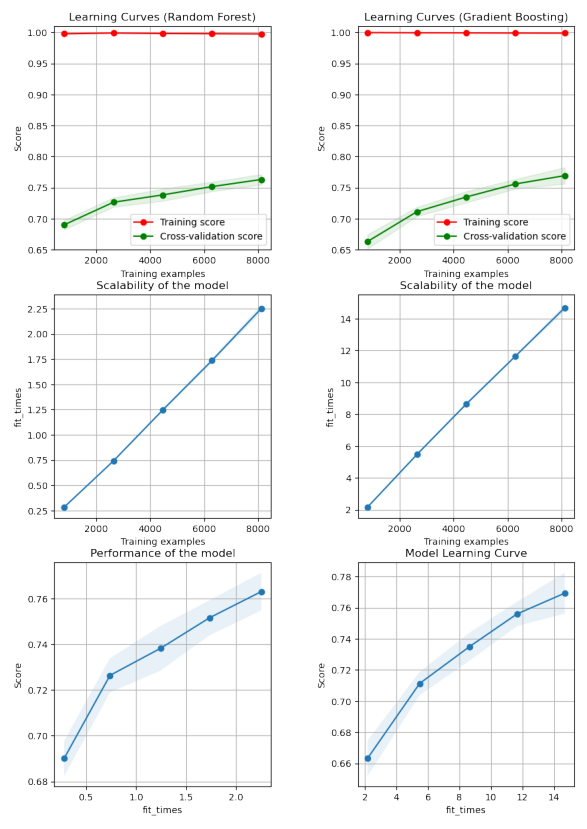

time: 174 ms (started: 2023-07-23 21:58:19 -07:00)


In [63]:
dpi=100
figure_filename='../reports/figures/figure_train_size_score_random_forest_classifier_gradient_boosting_classifier_dpi_'+str(dpi)+'_v'+filename_version+'.png'

figure_filename_exists=os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(60, 15))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))

    title=r"Learning Curves (Random Forest)"
    estimator=RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=5, n_estimators=200, random_state=200, min_samples_leaf=1, max_features='auto', criterion='gini', warm_start='False',)

    plt, learning_curve_random_forest_classifier=icr.plot_learning_curve(estimator=estimator, 
                                                                           title=title, 
                                                                           X=data_frame_collection['X_train'], 
                                                                           y=data_frame_collection['Y_train'].loc[:, 'Y'],
                                                                           filename=learning_curve_results_filename_collection['random_forest_classifier'],
                                                                           axes=axes[:, 0], 
                                                                           ylim=(0.65, 1.01), 
                                                                           cv=StratifiedKFold_5_splits, 
                                                                           n_jobs=4, 
                                                                           scoring="accuracy",
                                                                           train_sizes=np.linspace(0.1, 1.0, 5))


    title = r"Learning Curves (Gradient Boosting)"
    estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                           max_depth=9, 
                                           n_estimators = 250,
                                           random_state=200,
                                           max_features=None,
                                           verbose=0,
                                           max_leaf_nodes=None,
                                           warm_start=False,
                                           n_iter_no_change=None)

    plt, learning_curve_gradient_boosting_classifier=icr.plot_learning_curve(estimator=estimator, 
                                                                               title=title, 
                                                                               X=data_frame_collection['X_train'], 
                                                                               y=data_frame_collection['Y_train'].loc[:, 'Y'],
                                                                               filename=learning_curve_results_filename_collection['gradient_boosting_classifier'],
                                                                               axes=axes[:, 1], 
                                                                               ylim=(0.65, 1.01), 
                                                                               cv=StratifiedKFold_5_splits, 
                                                                               n_jobs=4,
                                                                               scoring="accuracy",
                                                                               train_sizes=np.linspace(0.1, 1.0, 5))
    
    plt.title('Model Learning Curve')

    fig.subplots_adjust(wspace=.4)

    plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show()

## Get Model Conversion Rate vs Pecentage of Conversions Captured Plot

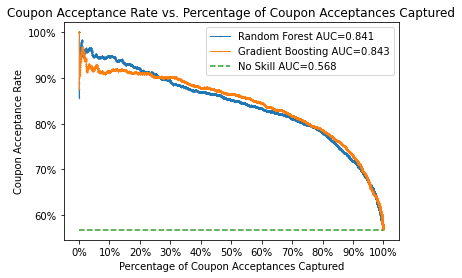

time: 183 ms (started: 2023-07-23 21:58:20 -07:00)


In [64]:
xlabel_string='Percentage of Coupon Acceptances Captured'
ylabel_string='Coupon Acceptance Rate'

filename = '../reports/figures/figure_precision_recall_curve_random_forest_gradient_boosting_metric_auc_v' + filename_version + '.png'
markersize=1
linewidth=1

#calculate precision-recall points
random_forest_classifier_precision_array, random_forest_classifier_recall_array, random_forest_classifier_decision_threshold_array = \
precision_recall_curve(y_true=data_frame_collection['Y_train'].loc[:, 'Y'], probas_pred=stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['random_forest_classifier'])


#calculate precision-recall curve auc
random_forest_classifier_auc = auc(random_forest_classifier_recall_array, random_forest_classifier_precision_array)

# plot the precision-recall curve
plt.plot(random_forest_classifier_recall_array, random_forest_classifier_precision_array, marker='.', markersize=markersize, linewidth=linewidth, label='Random Forest AUC=' + str(round(random_forest_classifier_auc, 3)))


#calculate precision-recall points
gradient_boosting_classifier_precision_array, gradient_boosting_classifier_recall_array, gradient_boosting_classifier_threshold_array = \
precision_recall_curve(y_true=data_frame_collection['Y_train'].loc[:, 'Y'], probas_pred=stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['gradient_boosting_classifier'])

#calculate precision-recall curve auc
gradient_boosting_classifier_auc = auc(gradient_boosting_classifier_recall_array, gradient_boosting_classifier_precision_array)

# plot the precision-recall curve
plt.plot(gradient_boosting_classifier_recall_array, gradient_boosting_classifier_precision_array, marker='.', markersize=markersize, linewidth=linewidth, label='Gradient Boosting AUC=' + str(round(gradient_boosting_classifier_auc, 3)))


#calculate no skill classifier curve
no_skill_classifier_auc = data_frame_collection['Y_train'].loc[data_frame_collection['Y_train'].loc[:, 'Y']==1, 'Y'].shape[0] / data_frame_collection['Y_train'].loc[:, 'Y'].shape[0]
plt.plot([0, 1], [no_skill_classifier_auc, no_skill_classifier_auc], linestyle='--', label='No Skill AUC='+str(round(no_skill_classifier_auc, 3)))

plt.xticks([.0, .1 ,.2, .3 ,.4, .5, .6 ,.7, .8, .9, 1 ])
plt.yticks([.6 ,.7, .8, .9, 1 ])
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().set_yticklabels(['{:.0f}%'.format(y*100) for y in plt.gca().get_yticks()])
plt.xlabel(xlabel_string)
plt.ylabel(ylabel_string)
plt.title(str(ylabel_string)+' vs. '+str(xlabel_string))
plt.legend()


#save it
plt.savefig(filename, bbox_inches='tight', dpi=100)

plt.show()

## Get Random Forest Classifier Decision Threshold, Precision, Recall DataFrame

In [65]:
#get data frame random forest decision threshold, precision, and recall
random_forest_classifier_decision_threshold_array = np.append(0, random_forest_classifier_decision_threshold_array)

df_random_forest_decision_threshold_precision_recall = pd.DataFrame({'random_forest_decision_threshold':random_forest_classifier_decision_threshold_array, 'random_forest_precision':random_forest_classifier_precision_array, 'random_forest_recall':random_forest_classifier_recall_array})
del random_forest_classifier_decision_threshold_array

#get random forest 90% precision decision threshold
random_forest_90_precision_estimated_recall=df_random_forest_decision_threshold_precision_recall.loc[df_random_forest_decision_threshold_precision_recall.loc[:, 'random_forest_precision']>=.9, :].head(1).loc[:, 'random_forest_recall'].values[0]

p(df_random_forest_decision_threshold_precision_recall)

(8701, 3)


random_forest_decision_threshold  random_forest_precision  \
0                             0.000000                 0.568763   
1                             0.034167                 0.568720   
2                             0.035000                 0.568777   
3                             0.036347                 0.568833   
4                             0.036667                 0.568889   
8696                          0.987500                 1.000000   
8697                          0.987708                 1.000000   
8698                          0.988750                 1.000000   
8699                          0.990833                 1.000000   
8700                          0.993750                 1.000000   

      random_forest_recall  
0                 1.000000  
1                 0.999826  
2                 0.999826  
3                 0.999826  
4                 0.999826  
8696              0.000694  
8697              0.000521  
8698              0.000347  
8699              0.000174  
8700              0.000000

time: 7.07 ms (started: 2023-07-23 21:58:20 -07:00)


## Get Gradient Boosting Classifier Decision Threshold, Precision, Recall DataFrame

In [66]:
#get data frame gradient boosting decision threshold, precision, and recall
gradient_boosting_classifier_threshold_array = np.append(0, gradient_boosting_classifier_threshold_array)

df_gradient_boosting_decision_threshold_precision_recall = pd.DataFrame({'gradient_boosting_decision_threshold':gradient_boosting_classifier_threshold_array, 'gradient_boosting_precision':gradient_boosting_classifier_precision_array, 'gradient_boosting_recall':gradient_boosting_classifier_recall_array})
del gradient_boosting_classifier_threshold_array

p(df_gradient_boosting_decision_threshold_precision_recall)

(10108, 3)


gradient_boosting_decision_threshold  gradient_boosting_precision  \
0                                  0.000000                     0.569494   
1                                  0.000004                     0.569451   
2                                  0.000004                     0.569508   
3                                  0.000004                     0.569564   
4                                  0.000005                     0.569620   
10103                              0.999999                     1.000000   
10104                              1.000000                     1.000000   
10105                              1.000000                     1.000000   
10106                              1.000000                     1.000000   
10107                              1.000000                     1.000000   

       gradient_boosting_recall  
0                      1.000000  
1                      0.999826  
2                      0.999826  
3                      0.999826  
4                      0.999826  
10103                  0.000694  
10104                  0.000521  
10105                  0.000347  
10106                  0.000174  
10107                  0.000000

time: 5.05 ms (started: 2023-07-23 21:58:20 -07:00)


## Get Random Forest Classifier Top 50 Features Bar Plot

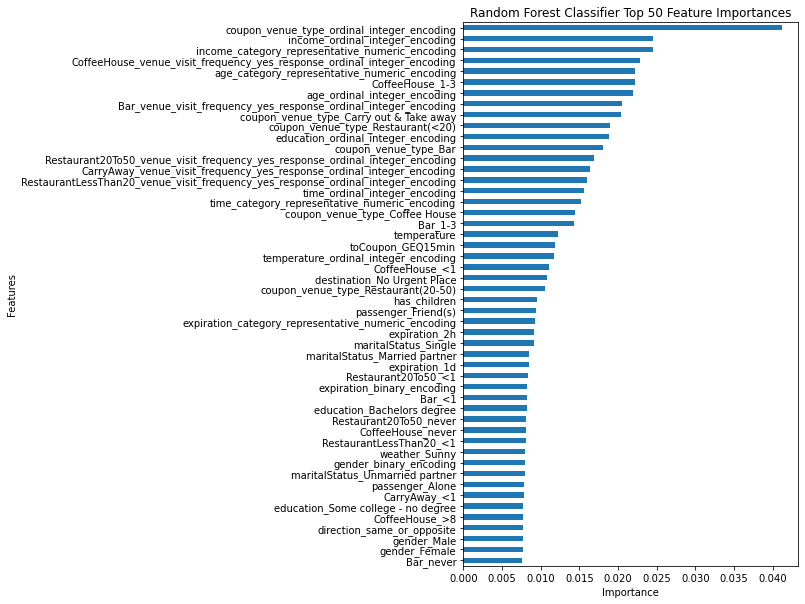

time: 1.03 s (started: 2023-07-23 21:58:20 -07:00)


In [67]:
#get feature importants plot
top_number_features = 50
figsize=(6, 10)
dpi=100
figure_filename = '../reports/figures/figure_random_forest_classifier_train_top_'+ str(top_number_features) +'_feature_importances_v' + filename_version + '.png'


plt.subplots(figsize=figsize)

feature_importances = best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.feature_importances_
series_random_forest_classifier_feature_importances = pd.Series(feature_importances, 
                                                                 index=best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.X_columns).sort_values(ascending=False)
series_random_forest_classifier_feature_importances[0:top_number_features].sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Classifier Top ' + str(top_number_features)   + ' Feature Importances');

plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show()

In [68]:
#get random forest top 50 features by importance
column_name_list_random_forest_classifier_top_50_by_feature_importance = series_random_forest_classifier_feature_importances[0:50].index.to_list()

column_name_list_random_forest_classifier_top_50_by_feature_importance_target = column_name_list_random_forest_classifier_top_50_by_feature_importance + ['Y']
del column_name_list_random_forest_classifier_top_50_by_feature_importance

time: 707 µs (started: 2023-07-23 21:58:21 -07:00)


## Get Random Forest Classifier Top 50 Features Correlation Heat Map

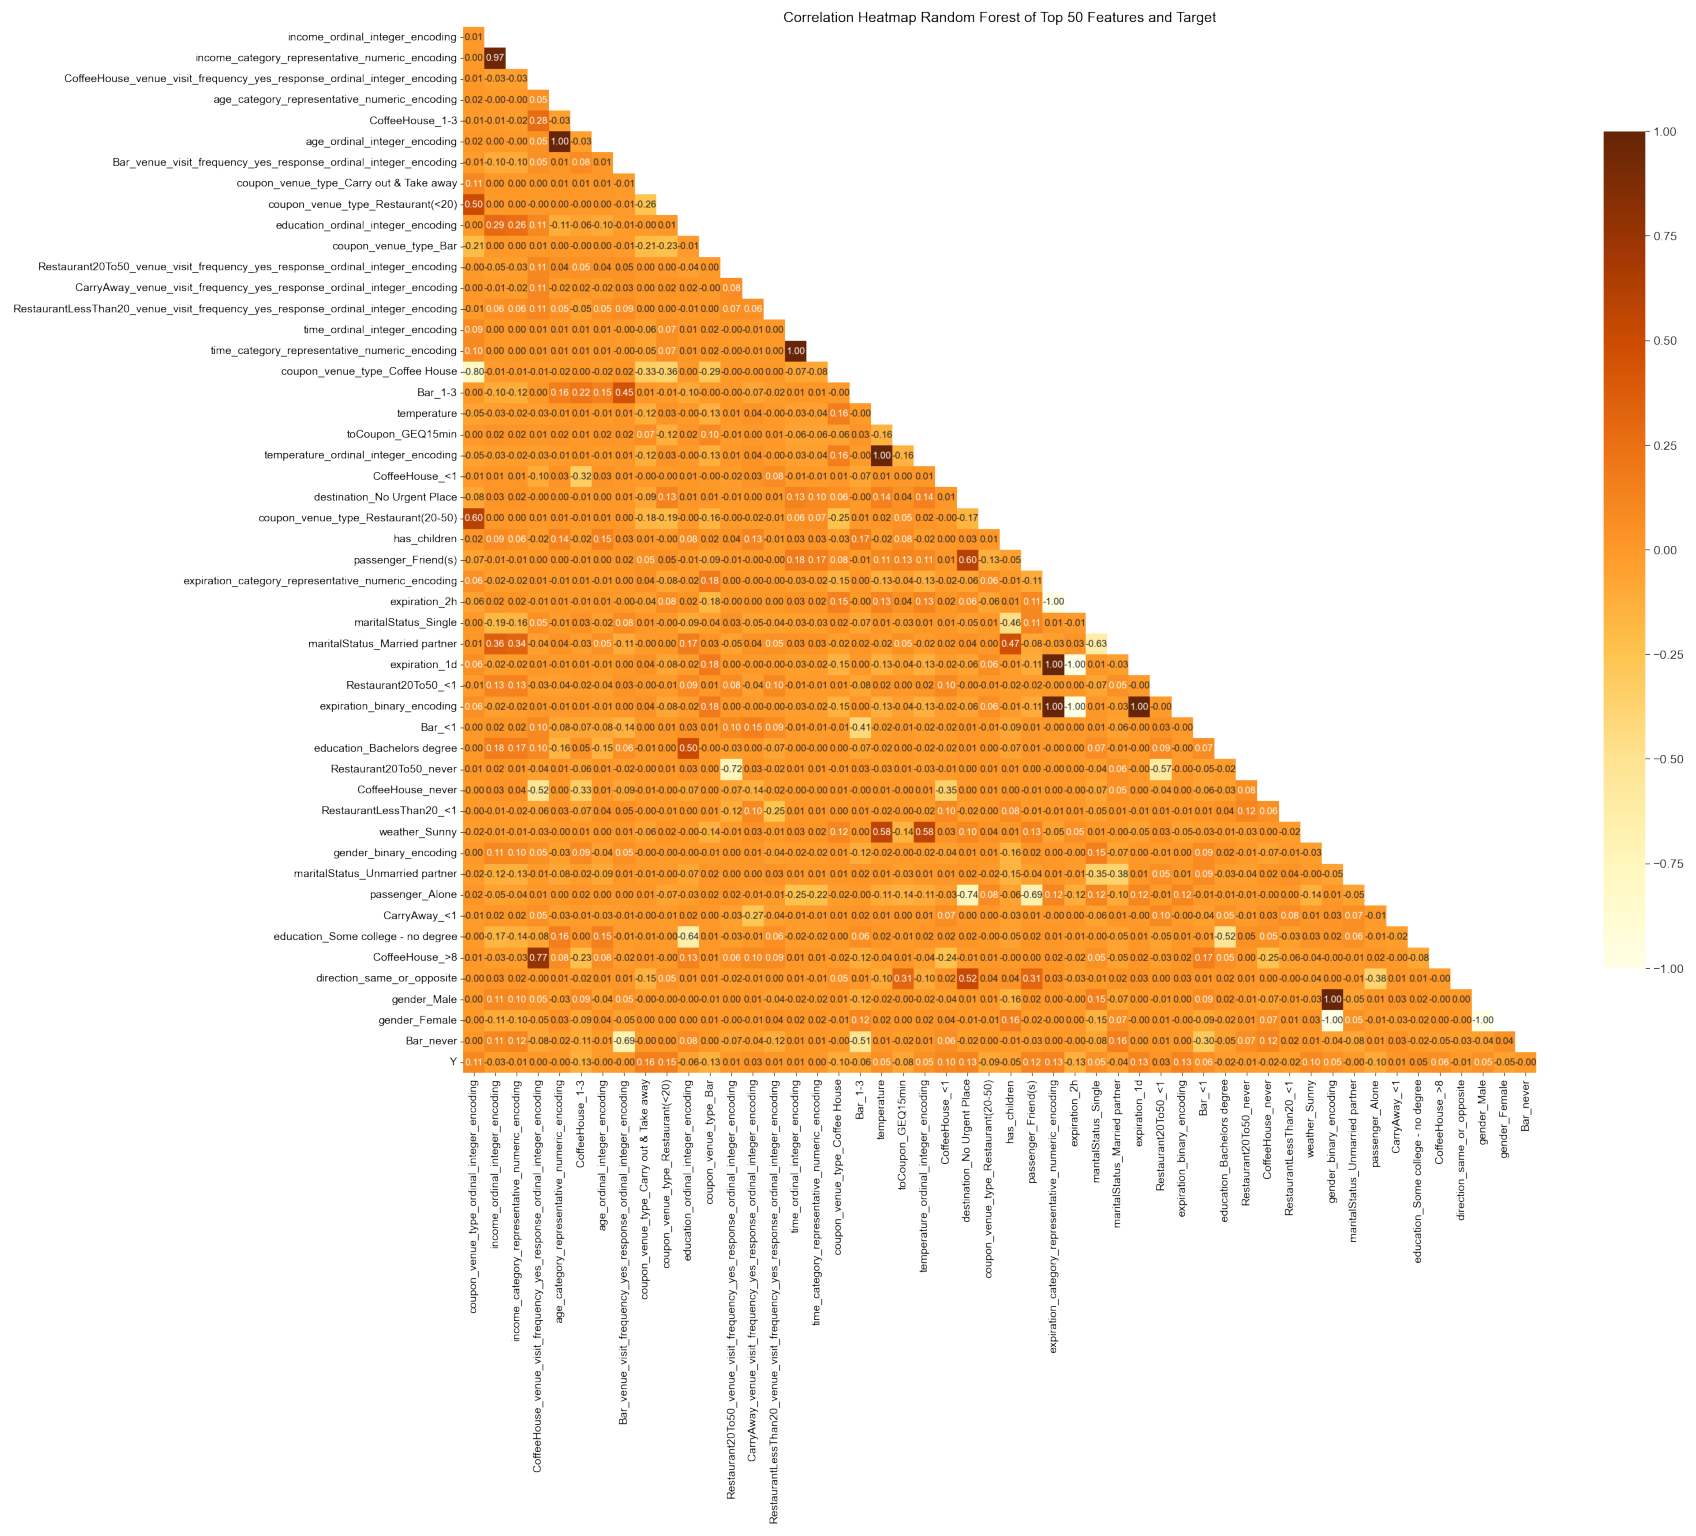

time: 901 ms (started: 2023-07-23 21:58:21 -07:00)


In [69]:
dpi=100
figure_filename = '../reports/figures/figure_correlation_heatmap_random_forest_classifier_train_top_50_and_target_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(35, 28))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    #correlation heatmap of top 50 features and target
    
    df_train = pd.concat([data_frame_collection['X_train'], data_frame_collection['Y_train']], axis=1)

    df_corr = df_train.loc[:, column_name_list_random_forest_classifier_top_50_by_feature_importance_target].corr()

    fig, ax = plt.subplots(figsize=(30, 24))

    mask = np.triu(np.ones_like(df_corr, dtype=bool))
    mask = mask[1:, :-1]

    corr = df_corr.iloc[1:,:-1].copy()

    sns.set(font_scale=1.4)
    sns.set_style("white")

    res = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='YlOrBr', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
    res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14, rotation=90)
    res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14, rotation=0)
    plt.title('Correlation Heatmap Random Forest of Top 50 Features and Target', fontsize=18)

    #save it
    plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show()

## Get Train DataFrame Random Forest Prediction Probability, Gradient Boosting Prediction Probability, Y Actual, Coupon Venue Type

In [70]:
feature_column_name_list = ['coupon_venue_type']

## Get Prediction Probabilities for Gradient Boosting, Prediction Probabilities for Random Forest, Y_actual, and coupon venue type
df_Y_train_random_forest_prediction_probability=stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['random_forest_classifier'].to_frame().rename(columns={1:'Y_train_random_forest_prediction_probability'}).reset_index(drop=True)
df_Y_train_gradient_boosting_prediction_probability=stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['gradient_boosting_classifier'].to_frame().rename(columns={1:'Y_train_gradient_boosting_prediction_probability'}).reset_index(drop=True)


df_y_train_model_name_prediction_probability_y_actual_coupon_venue_type = \
pd.concat([df_Y_train_random_forest_prediction_probability, 
           df_Y_train_gradient_boosting_prediction_probability, 
           data_frame_collection['Y_train'].reset_index(drop=True),
           df_collection['X_train'].loc[:, feature_column_name_list].reset_index(drop=True)], axis=1)

p(df_y_train_model_name_prediction_probability_y_actual_coupon_venue_type)

(10147, 4)


Y_train_random_forest_prediction_probability  \
0                                          0.772312   
1                                          0.711250   
2                                          0.403750   
3                                          0.824488   
4                                          0.710913   
10142                                      0.261250   
10143                                      0.652119   
10144                                      0.669310   
10145                                      0.911190   
10146                                      0.640171   

       Y_train_gradient_boosting_prediction_probability  Y  \
0                                              0.751593  1   
1                                              0.979490  1   
2                                              0.001341  0   
3                                              0.993639  1   
4                                              0.826168  1   
10142                                          0.577856  0   
10143                                          0.947631  0   
10144                                          0.991084  1   
10145                                          0.999991  1   
10146                                          0.938312  1   

           coupon_venue_type  
0               Coffee House  
1               Coffee House  
2      Carry out & Take away  
3               Coffee House  
4               Coffee House  
10142                    Bar  
10143                    Bar  
10144      Restaurant(20-50)  
10145           Coffee House  
10146           Coffee House

time: 6.88 ms (started: 2023-07-23 21:58:22 -07:00)


## Get DataFrame Model Prediction, Survey Prediction, Y Actual, Coupon Venue Type

In [71]:
# Get Random Forest Classifier Y Predicted from Y Prediction Probabilities and Decision Threshold .9 Precision Estimated
model_type='random_forest'
df_Y_train_random_forest_predicted = icr.get_model_predictions_from_prediction_probabilities_and_decision_threshold_proportion_metric_estimated(df=df_random_forest_decision_threshold_precision_recall, 
                                                                                                                                                model_proportion_precision=.9, 
                                                                                                                                                model_proportion_recall=None,
                                                                                                                                                model_precision_column_name=model_type+'_precision', 
                                                                                                                                                model_recall_column_name=model_type+'_recall',
                                                                                                                                                model_decision_threshold_column_name=model_type+'_decision_threshold',
                                                                                                                                                df_Y_train_test_model_prediction_probability=df_Y_train_random_forest_prediction_probability.iloc[:, 0],
                                                                                                                                                train_test='train',
                                                                                                                                                filename_version=filename_version)
df_Y_train_random_forest_predicted=df_Y_train_random_forest_predicted.rename(columns={'Y_train_predicted':'Y_train_'+str(model_type)+'_predicted'})


#get gradient boosting 80% recall estimate predictions
model_type = 'gradient_boosting'
model_proportion_precision=None
model_proportion_recall=.8

df_Y_train_gradient_boosting_predicted = icr.get_model_predictions_from_prediction_probabilities_and_decision_threshold_proportion_metric_estimated(df=df_gradient_boosting_decision_threshold_precision_recall,
                                                                                                                                                   model_proportion_precision=model_proportion_precision,
                                                                                                                                                   model_proportion_recall=model_proportion_recall,
                                                                                                                                                   model_precision_column_name=model_type+'_precision',
                                                                                                                                                   model_recall_column_name=model_type+'_recall',
                                                                                                                                                   model_decision_threshold_column_name=model_type+'_decision_threshold',
                                                                                                                                                   df_Y_train_test_model_prediction_probability=df_Y_train_gradient_boosting_prediction_probability.iloc[:, 0],
                                                                                                                                                   train_test='train',
                                                                                                                                                   filename_version=filename_version)
df_Y_train_gradient_boosting_predicted=df_Y_train_gradient_boosting_predicted.rename(columns={'Y_train_predicted':'Y_train_'+str(model_type)+'_predicted'})



data_fold_type='train'
number_of_predictions=data_frame_collection['X_'+data_fold_type].shape[0]


#get survey 27% recall estimate predictions
recall_estimated=random_forest_90_precision_estimated_recall
df_Y_train_survey_27_recall_estimate_predicted = icr.get_survey_coupon_recommendations_by_recall_estimate(number_of_predictions=number_of_predictions, recall_estimated=recall_estimated, random_state=200, train_test='train')

#get survey 80% recall estimate predictions
recall_estimated=.8
df_Y_train_survey_80_recall_estimate_predicted=icr.get_survey_coupon_recommendations_by_recall_estimate(number_of_predictions=number_of_predictions, recall_estimated=recall_estimated, random_state=200, train_test='train')

#get survey 100% recall estimate predictions
recall_estimated=1
df_Y_train_survey_100_recall_estimate_predicted=icr.get_survey_coupon_recommendations_by_recall_estimate(number_of_predictions=number_of_predictions, recall_estimated=recall_estimated, random_state=200, train_test='train')


### Get Data Frame Y Train Random Forest Predicted, Y Train Gradient Boosting Predicted, Y Train Survey Predicted, Y Actual, and Coupon Venue Type
feature_column_name_list = ['coupon_venue_type']

df_y_train_model_name_predicted_y_train_survey_recall_estimate_predicted_y_actual_coupon_venue_type = \
pd.concat([df_Y_train_random_forest_predicted,
           df_Y_train_gradient_boosting_predicted,
           df_Y_train_survey_27_recall_estimate_predicted,
           df_Y_train_survey_80_recall_estimate_predicted,
           df_Y_train_survey_100_recall_estimate_predicted,
           data_frame_collection['Y_train'].reset_index(drop=True),
           df_collection['X_train'].loc[:, feature_column_name_list].reset_index(drop=True)], axis=1)

p(df_y_train_model_name_predicted_y_train_survey_recall_estimate_predicted_y_actual_coupon_venue_type)

This file already exists.
This file already exists.
0.26870335011282764
0.7312966498871724
0.8
0.19999999999999996
1
0
(10147, 7)


Y_train_random_forest_predicted  Y_train_gradient_boosting_predicted  \
0                                    0                                    1   
1                                    0                                    1   
2                                    0                                    0   
3                                    0                                    1   
4                                    0                                    1   
10142                                0                                    0   
10143                                0                                    1   
10144                                0                                    1   
10145                                1                                    1   
10146                                0                                    1   

       Y_train_survey_27_recall_estimate_predicted  \
0                                                1   
1                                                0   
2                                                0   
3                                                0   
4                                                1   
10142                                            0   
10143                                            0   
10144                                            0   
10145                                            0   
10146                                            0   

       Y_train_survey_80_recall_estimate_predicted  \
0                                                1   
1                                                1   
2                                                1   
3                                                1   
4                                                1   
10142                                            1   
10143                                            1   
10144                                            0   
10145                                            1   
10146                                            0   

       Y_train_survey_100_recall_estimate_predicted  Y      coupon_venue_type  
0                                                 1  1           Coffee House  
1                                                 1  1           Coffee House  
2                                                 1  0  Carry out & Take away  
3                                                 1  1           Coffee House  
4                                                 1  1           Coffee House  
10142                                             1  0                    Bar  
10143                                             1  0                    Bar  
10144                                             1  1      Restaurant(20-50)  
10145                                             1  1           Coffee House  
10146                                             1  1           Coffee House

time: 19.8 ms (started: 2023-07-23 21:58:22 -07:00)


### Initialize Variables

In [72]:
multiple_index=icr.get_metric_multiple_index(proportion_or_percentage='proportion')

feature_column_name_filter_value_list_dictionary_key_list=['Overall', 'Coffee House', 'Bar', 'Takeout', 'Low-Cost Restaurant', 'Mid-Range Restaurant']
feature_column_name_filter_value_two_dimensional_list=[['Coffee House', 'Bar', 'Carry out & Take away', 'Restaurant(<20)', 'Restaurant(20-50)'], ['Coffee House'], ['Bar'], ['Carry out & Take away'], ['Restaurant(<20)'], ['Restaurant(20-50)']]

feature_column_name_filter_value_list_dictionary=dict(zip(feature_column_name_filter_value_list_dictionary_key_list, feature_column_name_filter_value_two_dimensional_list))

feature_column_name_filter='coupon_venue_type'
y_predicted_column_name_base_survey='Y_train_survey_100_recall_estimate_predicted'
venue_type_average_sale_dictionary={'Coffee House':[5.50], 'Bar':[15], 'Takeout':[15], 'Low-Cost Restaurant':[12], 'Mid-Range Restaurant':[35],}


time: 1.99 ms (started: 2023-07-23 21:58:22 -07:00)


### Get DataFrame's Coupon Venue Type Recommendation Cost Per Random Forest and Survey and Gradient Boosting and Survey Using 20% of Ad Revenue Principle

In [73]:
### Get Average Coupon Recommendation Cost Estimated (Per Coupon Venue Type) From Survey 100% Recall Metrics and Average Sale Estimated
column_name_y_predicted='Y_train_survey_100_recall_estimate_predicted'
column_name_y_actual='Y'

df_train_survey_100_recall_coupon_recommendation_cost_estimated_sale_estimated=\
icr.get_survey_or_model_average_coupon_recommendation_cost_estimated(df_y_train_model_name_predicted_y_train_survey_recall_estimate_predicted_y_actual_coupon_venue_type=df_y_train_model_name_predicted_y_train_survey_recall_estimate_predicted_y_actual_coupon_venue_type,
                                                                     column_name_y_predicted=column_name_y_predicted,
                                                                     column_name_y_actual=column_name_y_actual,
                                                                     feature_column_name_filter=feature_column_name_filter,
                                                                     feature_column_name_filter_value_two_dimensional_list=feature_column_name_filter_value_two_dimensional_list,
                                                                     feature_column_name_filter_value_list_dictionary_key_list=feature_column_name_filter_value_list_dictionary_key_list,
                                                                     venue_type_average_sale_dictionary=venue_type_average_sale_dictionary,
                                                                     model_survey='Survey')


### Get Average Coupon Recommendation Cost Estimated (Per Coupon Venue Type) From Random Forest 90% Conversion Rate Estimated Metrics and Average Sale Estimated
column_name_y_predicted='Y_train_random_forest_predicted'
column_name_y_actual='Y'

df_train_random_forest_coupon_recommendation_cost_estimated_sale_estimated=\
icr.get_survey_or_model_average_coupon_recommendation_cost_estimated(df_y_train_model_name_predicted_y_train_survey_recall_estimate_predicted_y_actual_coupon_venue_type=df_y_train_model_name_predicted_y_train_survey_recall_estimate_predicted_y_actual_coupon_venue_type,
                                                                     column_name_y_predicted=column_name_y_predicted,
                                                                     column_name_y_actual=column_name_y_actual,
                                                                     feature_column_name_filter=feature_column_name_filter,
                                                                     feature_column_name_filter_value_two_dimensional_list=feature_column_name_filter_value_two_dimensional_list,
                                                                     feature_column_name_filter_value_list_dictionary_key_list=feature_column_name_filter_value_list_dictionary_key_list,
                                                                     venue_type_average_sale_dictionary=venue_type_average_sale_dictionary,
                                                                     model_survey='Model')


### Get Average Coupon Recommendation Cost Estimated (Per Coupon Venue Type) From Gradient Boosting 80% Recall Estimated Metrics and Average Sale Estimated
column_name_y_predicted='Y_train_gradient_boosting_predicted'
column_name_y_actual='Y'


df_train_gradient_boosting_coupon_recommendation_cost_estimated_sale_estimated=\
icr.get_survey_or_model_average_coupon_recommendation_cost_estimated(df_y_train_model_name_predicted_y_train_survey_recall_estimate_predicted_y_actual_coupon_venue_type=df_y_train_model_name_predicted_y_train_survey_recall_estimate_predicted_y_actual_coupon_venue_type,
                                                                     column_name_y_predicted=column_name_y_predicted,
                                                                     column_name_y_actual=column_name_y_actual,
                                                                     feature_column_name_filter=feature_column_name_filter,
                                                                     feature_column_name_filter_value_two_dimensional_list=feature_column_name_filter_value_two_dimensional_list,
                                                                     feature_column_name_filter_value_list_dictionary_key_list=feature_column_name_filter_value_list_dictionary_key_list,
                                                                     venue_type_average_sale_dictionary=venue_type_average_sale_dictionary,
                                                                     model_survey='Model')




#get df_train_random_forest_29_precision_survey_100_recall_coupon_recommendation_cost_estimated_sale_estimated
df_train_random_forest_29_precision_survey_100_recall_coupon_recommendation_cost_estimated_sale_estimated=\
pd.concat([df_train_random_forest_coupon_recommendation_cost_estimated_sale_estimated,
           df_train_survey_100_recall_coupon_recommendation_cost_estimated_sale_estimated,],
          axis=0)


#get df_train_gradient_boosting_survey_100_recall_coupon_recommendation_cost_estimated_sale_estimated
df_train_gradient_boosting_80_recall_survey_100_recall_coupon_recommendation_cost_estimated_sale_estimated=\
pd.concat([df_train_gradient_boosting_coupon_recommendation_cost_estimated_sale_estimated,
           df_train_survey_100_recall_coupon_recommendation_cost_estimated_sale_estimated,],
          axis=0)

df_train_gradient_boosting_80_recall_survey_100_recall_coupon_recommendation_cost_estimated_sale_estimated

Overall  Coffee House  \
Model  Average Coupon Recommendation Cost Estimated      NaN      0.848469   
       Average Sale Estimated                            NaN      5.500000   
Survey Average Coupon Recommendation Cost Estimated      NaN      0.541538   
       Average Sale Estimated                            NaN      5.500000   

                                                           Bar    Takeout  \
Model  Average Coupon Recommendation Cost Estimated   2.223881   2.456336   
       Average Sale Estimated                        15.000000  15.000000   
Survey Average Coupon Recommendation Cost Estimated   1.244129   2.201155   
       Average Sale Estimated                        15.000000  15.000000   

                                                     Low-Cost Restaurant  \
Model  Average Coupon Recommendation Cost Estimated             1.976224   
       Average Sale Estimated                                  12.000000   
Survey Average Coupon Recommendation Cost Estimated             1.707282   
       Average Sale Estimated                                  12.000000   

                                                     Mid-Range Restaurant  
Model  Average Coupon Recommendation Cost Estimated              4.638037  
       Average Sale Estimated                                   35.000000  
Survey Average Coupon Recommendation Cost Estimated              3.081650  
       Average Sale Estimated                                   35.000000

time: 49 ms (started: 2023-07-23 21:58:22 -07:00)


### Get Train Random Forest 90% Conversion Rate Estimated Metrics (Per Coupon Venue Type) Table 

In [74]:
model_type='random_forest'
survey_number_recall_estimated_y_predicted_column_name='Y_train_survey_27_recall_estimate_predicted'
metrics_coupon_venue_type_list = []

for feature_column_name_filter_value_list_dictionary_key in feature_column_name_filter_value_list_dictionary.keys():
    
    metric_list=icr.get_model_and_survey_metrics(df=df_y_train_model_name_predicted_y_train_survey_recall_estimate_predicted_y_actual_coupon_venue_type,
                                                model_y_predicted_column_name='Y_train_'+model_type+'_predicted',
                                                survey_number_recall_estimated_y_predicted_column_name=survey_number_recall_estimated_y_predicted_column_name,
                                                y_predicted_column_name_base_survey=y_predicted_column_name_base_survey,
                                                y_actual_column_name='Y',
                                                feature_column_name_filter=feature_column_name_filter,
                                                feature_column_name_filter_value_list=feature_column_name_filter_value_list_dictionary[feature_column_name_filter_value_list_dictionary_key],
                                                metrics_column_name_list=None,)
    metrics_coupon_venue_type_list+=[metric_list]

df_train_random_forest_model_survey_metrics=\
pd.DataFrame(metrics_coupon_venue_type_list, 
             index=feature_column_name_filter_value_list_dictionary_key_list,
             columns=multiple_index[0:20]).T

df_train_random_forest_metrics=icr.calculate_and_add_model_survey_difference(df_train_random_forest_model_survey_metrics, multiple_index)

#add Venue Type Coupon Recommendation Cost Estimated, Sale Estimated
df_train_random_forest_metrics_coupon_recommendation_cost_estimated_sale_estimated=\
pd.concat([df_train_random_forest_metrics, df_train_random_forest_29_precision_survey_100_recall_coupon_recommendation_cost_estimated_sale_estimated], axis=0)


#get and add Ad Revenue, Ad Spend, ROAS, Profit, Spend, ROI
df_train_random_forest_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI=icr.get_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI(df=df_train_random_forest_metrics_coupon_recommendation_cost_estimated_sale_estimated)
del df_train_random_forest_metrics_coupon_recommendation_cost_estimated_sale_estimated

df_train_random_forest_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI



Overall  \
Model                   Conversion Rate                                                   0.900000   
                        Recall                                                            0.268703   
                        Proportion of Conversions                                         1.000000   
                        Conversions                                                    1548.000000   
                        Proportion of Coupons Recommended                                 1.000000   
                        Coupons Recommended                                            1720.000000   
                        Conversions to Base Survey Coupons Recommended Ratio              0.152557   
                        Conversions to Survey Conversions Ratio                           0.972362   
                        Coupons Recommended to Survey Coupons Recommended Ratio           0.623640   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio      0.169508   
Survey                  Conversion Rate                                                   0.577230   
                        Recall                                                            0.276341   
                        Proportion of Conversions                                         1.000000   
                        Conversions                                                    1592.000000   
                        Proportion of Coupons Recommended                                 1.000000   
                        Coupons Recommended                                            2758.000000   
                        Conversions to Base Survey Coupons Recommended Ratio              0.156894   
                        Conversions to Survey Conversions Ratio                           1.000000   
                        Coupons Recommended to Survey Coupons Recommended Ratio           1.000000   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio      0.271804   
Model-Survey Difference Conversion Rate                                                   0.322770   
                        Recall                                                           -0.007638   
                        Proportion of Conversions                                         0.000000   
                        Conversions                                                     -44.000000   
                        Proportion of Coupons Recommended                                 0.000000   
                        Coupons Recommended                                           -1038.000000   
                        Conversions to Base Survey Coupons Recommended Ratio             -0.004336   
                        Conversions to Survey Conversions Ratio                          -0.027638   
                        Coupons Recommended to Survey Coupons Recommended Ratio          -0.376360   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio     -0.102296   
Model                   Average Coupon Recommendation Cost Estimated                           NaN   
                        Average Sale Estimated                                                 NaN   
Survey                  Average Coupon Recommendation Cost Estimated                           NaN   
                        Average Sale Estimated                                                 NaN   
Model                   Ad Revenue                                                    18618.000000   
                        Ad Spend                                                       3723.600000   
Survey                  Ad Revenue                                                    21664.000000   
                        Ad Spend                                                       6839.257701   
Model-Survey Difference Ad Revenue                                                    -3046.000000   
           

time: 103 ms (started: 2023-07-23 21:58:22 -07:00)


### Get Train Random Forest 90% Conversion Rate Estimated 95% Confidence Interval Metrics (Per Coupon Venue Type) Table

In [75]:

model_type='random_forest'

### Get Train Random Forest 90% Conversion Rate Estimated 95% Confidence Interval Metrics (Per Coupon Venue Type) Table 
if st != 'yes':
    number_of_replicates=10000

quantile_lower_upper_list=[0.025, 0.975]

feature_column_name_filter='coupon_venue_type'
save_metric_replicates_feature_column_name_filter_value_list_dictionary_key_list=['Overall', 'Coffee House', 'Bar', 'Takeout', 'Low-Cost Restaurant', 'Mid-Range Restaurant']


random_forest_model_train_survey_number_confidence_interval_metric_collection={}
df_train_random_forest_90_precision_estimated_feature_filter_number_bootstrap_replicates_metrics_collection={}

for feature_column_name_filter_value_list_dictionary_key in feature_column_name_filter_value_list_dictionary_key_list:

    random_forest_model_train_survey_number_confidence_interval_metric_collection[feature_column_name_filter_value_list_dictionary_key],\
    df_train_random_forest_90_precision_estimated_feature_filter_number_bootstrap_replicates_metrics_collection[feature_column_name_filter_value_list_dictionary_key]=\
    icr.get_metric_confidence_interval_table_by_feature_column_name_filter_value_list_dictionary_key(df_y_train_test_model_name_predicted_y_train_test_survey_recall_estimate_predicted_y_actual_feature_column_name_filter=df_y_train_model_name_predicted_y_train_survey_recall_estimate_predicted_y_actual_coupon_venue_type,
                                                                                                     feature_column_name_filter=feature_column_name_filter,
                                                                                                     feature_column_name_filter_value_list_dictionary_key=feature_column_name_filter_value_list_dictionary_key,
                                                                                                     feature_column_name_filter_value_list_dictionary=feature_column_name_filter_value_list_dictionary,
                                                                                                     multiple_index=multiple_index,
                                                                                                     number_of_replicates=number_of_replicates,
                                                                                                     quantile_lower_upper_list=quantile_lower_upper_list,
                                                                                                     model_type=model_type,
                                                                                                     survey_number_recall_estimated_y_predicted_column_name=survey_number_recall_estimated_y_predicted_column_name,
                                                                                                     save_metric_replicates_feature_column_name_filter_value_list_dictionary_key_list=save_metric_replicates_feature_column_name_filter_value_list_dictionary_key_list,
                                                                                                     filename_version=filename_version,
                                                                                                     train_test='train',
                                                                                                     sample_size=2537)


df_random_forest_model_train_survey_number_confidence_interval_metric_feature_column_name_filter_value_sample_size_2537=\
icr.convert_collection_to_data_frame_and_drop_top_column_level(random_forest_model_train_survey_number_confidence_interval_metric_collection)

df_random_forest_model_train_survey_number_confidence_interval_metric_feature_column_name_filter_value_sample_size_2537

#mid-range restaurant conversions 95% confidence interval (100, 100) looks wrong.

This file already exists
This file already exists
This file already exists
This file already exists
This file already exists
This file already exists


95% Confidence Interval  \
                                                                                                     Overall   
Model                   Conversion Rate                                                       (87.1%, 92.8%)   
                        Recall                                                                (24.6%, 29.1%)   
                        Percentage of Conversions                                               (100%, 100%)   
                        Conversions                                                               (352, 422)   
                        Percentage of Coupons Recommended                                       (100%, 100%)   
                        Coupons Recommended                                                       (393, 467)   
                        Conversions to Base Survey Coupons Recommended Ratio                  (13.9%, 16.6%)   
                        Conversions to Survey Conversions Ratio                              (86.3%, 109.4%)   
                        Coupons Recommended to Survey Coupons Recommended Ratio               (56.0%, 69.2%)   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio          (15.5%, 18.4%)   
Survey                  Conversion Rate                                                       (54.0%, 61.5%)   
                        Recall                                                                (25.3%, 30.0%)   
                        Percentage of Conversions                                               (100%, 100%)   
                        Conversions                                                               (363, 434)   
                        Percentage of Coupons Recommended                                       (100%, 100%)   
                        Coupons Recommended                                                       (645, 733)   
                        Conversions to Base Survey Coupons Recommended Ratio                  (14.3%, 17.1%)   
                        Conversions to Survey Conversions Ratio                                 (100%, 100%)   
                        Coupons Recommended to Survey Coupons Recommended Ratio                 (100%, 100%)   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio          (25.5%, 28.9%)   
Model-Survey Difference Conversion Rate                                                       (27.9%, 36.6%)   
                        Recall                                                                 (-4.0%, 2.5%)   
                        Percentage of Conversions                                               (0.0%, 0.0%)   
                        Conversions                                                                (-58, 36)   
                        Percentage of Coupons Recommended                                       (0.0%, 0.0%)   
                        Coupons Recommended                                                     (-316, -203)   
                        Conversions to Base Survey Coupons Recommended Ratio                   (-2.3%, 1.4%)   
                        Conversions to Survey Conversions Ratio                               (-13.7%, 9.4%)   
                        Coupons Recommended to Survey Coupons Recommended Ratio             (-44.0%, -30.8%)   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio         (-12.5%, -8.0%)   

                                                                                                        \
                                                                                          Coffee House   
Model                   Conversion Rate                                                 (82.4%, 95.5%)   
                        Recall                                                          (15.6%, 23.4%)   
                        Percentage of Conversions                           

time: 1.6 s (started: 2023-07-23 21:58:22 -07:00)


### Get Train Gradient Boosting 80% Recall Estimated Metrics (Per Coupon Venue Type) Table

In [76]:
model_type='gradient_boosting'
survey_number_recall_estimated_y_predicted_column_name='Y_train_survey_80_recall_estimate_predicted'


metrics_coupon_venue_type_list = []

for feature_column_name_filter_value_list_dictionary_key in feature_column_name_filter_value_list_dictionary.keys():
    
    metric_list=icr.get_model_and_survey_metrics(df=df_y_train_model_name_predicted_y_train_survey_recall_estimate_predicted_y_actual_coupon_venue_type,
                                                 model_y_predicted_column_name='Y_train_'+model_type+'_predicted',
                                                 survey_number_recall_estimated_y_predicted_column_name=survey_number_recall_estimated_y_predicted_column_name,
                                                 y_predicted_column_name_base_survey=y_predicted_column_name_base_survey,
                                                 y_actual_column_name='Y',
                                                 feature_column_name_filter=feature_column_name_filter,
                                                 feature_column_name_filter_value_list=feature_column_name_filter_value_list_dictionary[feature_column_name_filter_value_list_dictionary_key],
                                                 metrics_column_name_list=None,)
    metrics_coupon_venue_type_list+=[metric_list]

df_train_gradient_boosting_model_survey_metrics=\
pd.DataFrame(metrics_coupon_venue_type_list, 
             index=feature_column_name_filter_value_list_dictionary_key_list, 
             columns=multiple_index[0:20]).T

df_train_gradient_boosting_metrics=icr.calculate_and_add_model_survey_difference(df_train_gradient_boosting_model_survey_metrics, multiple_index)

#add Venue Type Coupon Recommendation Cost Estimated, Sale Estimated
df_train_gradient_boosting_metrics_coupon_recommendation_cost_estimated_sale_estimated=pd.concat([df_train_gradient_boosting_metrics, df_train_gradient_boosting_80_recall_survey_100_recall_coupon_recommendation_cost_estimated_sale_estimated], axis=0)

#get and add Ad Revenue, Ad Spend, ROAS, Profit, Spend, ROI
df_train_gradient_boosting_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI=icr.get_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI(df=df_train_gradient_boosting_metrics_coupon_recommendation_cost_estimated_sale_estimated)
del df_train_gradient_boosting_metrics_coupon_recommendation_cost_estimated_sale_estimated


df_train_gradient_boosting_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI

Overall  \
Model                   Conversion Rate                                                   0.786737   
                        Recall                                                            0.801076   
                        Proportion of Conversions                                         1.000000   
                        Conversions                                                    4615.000000   
                        Proportion of Coupons Recommended                                 1.000000   
                        Coupons Recommended                                            5866.000000   
                        Conversions to Base Survey Coupons Recommended Ratio              0.454814   
                        Conversions to Survey Conversions Ratio                           0.997191   
                        Coupons Recommended to Survey Coupons Recommended Ratio           0.722414   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio      0.578102   
Survey                  Conversion Rate                                                   0.569951   
                        Recall                                                            0.803333   
                        Proportion of Conversions                                         1.000000   
                        Conversions                                                    4628.000000   
                        Proportion of Coupons Recommended                                 1.000000   
                        Coupons Recommended                                            8120.000000   
                        Conversions to Base Survey Coupons Recommended Ratio              0.456095   
                        Conversions to Survey Conversions Ratio                           1.000000   
                        Coupons Recommended to Survey Coupons Recommended Ratio           1.000000   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio      0.800237   
Model-Survey Difference Conversion Rate                                                   0.216786   
                        Recall                                                           -0.002257   
                        Proportion of Conversions                                         0.000000   
                        Conversions                                                     -13.000000   
                        Proportion of Coupons Recommended                                 0.000000   
                        Coupons Recommended                                           -2254.000000   
                        Conversions to Base Survey Coupons Recommended Ratio             -0.001281   
                        Conversions to Survey Conversions Ratio                          -0.002809   
                        Coupons Recommended to Survey Coupons Recommended Ratio          -0.277586   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio     -0.222135   
Model                   Average Coupon Recommendation Cost Estimated                           NaN   
                        Average Sale Estimated                                                 NaN   
Survey                  Average Coupon Recommendation Cost Estimated                           NaN   
                        Average Sale Estimated                                                 NaN   
Model                   Ad Revenue                                                    60218.000000   
                        Ad Spend                                                      12043.600000   
Survey                  Ad Revenue                                                    62111.000000   
                        Ad Spend                                                      16765.916704   
Model-Survey Difference Ad Revenue                                                    -1893.000000   
           

time: 103 ms (started: 2023-07-23 21:58:24 -07:00)


### Get Train Gradient Boosting 80% Conversion Rate Estimated 95% Confidence Interval Metrics (Per Coupon Venue Type) Table 

In [77]:
if st != 'yes':
    number_of_replicates=10000

quantile_lower_upper_list=[0.025, 0.975]

feature_column_name_filter='coupon_venue_type'
save_metric_replicates_feature_column_name_filter_value_list_dictionary_key_list=['Overall', 'Coffee House', 'Bar', 'Takeout', 'Low-Cost Restaurant', 'Mid-Range Restaurant']


gradient_boosting_model_train_survey_95_confidence_interval_metric_collection={}
df_train_gradient_boosting_80_recall_estimated_feature_filter_number_bootstrap_replicates_metrics_collection={}

for feature_column_name_filter_value_list_dictionary_key in feature_column_name_filter_value_list_dictionary_key_list:

    gradient_boosting_model_train_survey_95_confidence_interval_metric_collection[feature_column_name_filter_value_list_dictionary_key],\
    df_train_gradient_boosting_80_recall_estimated_feature_filter_number_bootstrap_replicates_metrics_collection[feature_column_name_filter_value_list_dictionary_key]=\
    icr.get_metric_confidence_interval_table_by_feature_column_name_filter_value_list_dictionary_key(df_y_train_test_model_name_predicted_y_train_test_survey_recall_estimate_predicted_y_actual_feature_column_name_filter=df_y_train_model_name_predicted_y_train_survey_recall_estimate_predicted_y_actual_coupon_venue_type,
                                                                                                     feature_column_name_filter=feature_column_name_filter,
                                                                                                     feature_column_name_filter_value_list_dictionary_key=feature_column_name_filter_value_list_dictionary_key,
                                                                                                     feature_column_name_filter_value_list_dictionary=feature_column_name_filter_value_list_dictionary,
                                                                                                     multiple_index=multiple_index,
                                                                                                     number_of_replicates=number_of_replicates,
                                                                                                     quantile_lower_upper_list=quantile_lower_upper_list,
                                                                                                     model_type=model_type,
                                                                                                     survey_number_recall_estimated_y_predicted_column_name=survey_number_recall_estimated_y_predicted_column_name,
                                                                                                     save_metric_replicates_feature_column_name_filter_value_list_dictionary_key_list=save_metric_replicates_feature_column_name_filter_value_list_dictionary_key_list,
                                                                                                     filename_version=filename_version,
                                                                                                     train_test='train',
                                                                                                     sample_size=2537)


df_gradient_boosting_model_train_survey_95_confidence_interval_metric_feature_column_name_filter_value=icr.convert_collection_to_data_frame_and_drop_top_column_level(gradient_boosting_model_train_survey_95_confidence_interval_metric_collection)

df_gradient_boosting_model_train_survey_95_confidence_interval_metric_feature_column_name_filter_value




This file already exists
This file already exists
This file already exists
This file already exists
This file already exists
This file already exists


95% Confidence Interval  \
                                                                                                     Overall   
Model                   Conversion Rate                                                       (76.5%, 80.8%)   
                        Recall                                                                (78.0%, 82.2%)   
                        Percentage of Conversions                                               (100%, 100%)   
                        Conversions                                                             (1105, 1203)   
                        Percentage of Coupons Recommended                                       (100%, 100%)   
                        Coupons Recommended                                                     (1418, 1516)   
                        Conversions to Base Survey Coupons Recommended Ratio                  (43.6%, 47.4%)   
                        Conversions to Survey Conversions Ratio                              (96.0%, 103.5%)   
                        Coupons Recommended to Survey Coupons Recommended Ratio               (69.5%, 75.1%)   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio          (55.9%, 59.8%)   
Survey                  Conversion Rate                                                       (54.8%, 59.2%)   
                        Recall                                                                (78.3%, 82.4%)   
                        Percentage of Conversions                                               (100%, 100%)   
                        Conversions                                                             (1108, 1207)   
                        Percentage of Coupons Recommended                                       (100%, 100%)   
                        Coupons Recommended                                                     (1991, 2069)   
                        Conversions to Base Survey Coupons Recommended Ratio                  (43.7%, 47.6%)   
                        Conversions to Survey Conversions Ratio                                 (100%, 100%)   
                        Coupons Recommended to Survey Coupons Recommended Ratio                 (100%, 100%)   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio          (78.5%, 81.6%)   
Model-Survey Difference Conversion Rate                                                       (19.7%, 23.7%)   
                        Recall                                                                 (-3.3%, 2.8%)   
                        Percentage of Conversions                                               (0.0%, 0.0%)   
                        Conversions                                                                (-47, 40)   
                        Percentage of Coupons Recommended                                       (0.0%, 0.0%)   
                        Coupons Recommended                                                     (-627, -500)   
                        Conversions to Base Survey Coupons Recommended Ratio                   (-1.9%, 1.6%)   
                        Conversions to Survey Conversions Ratio                                (-4.0%, 3.5%)   
                        Coupons Recommended to Survey Coupons Recommended Ratio             (-30.5%, -24.9%)   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio        (-24.7%, -19.7%)   

                                                                                                        \
                                                                                          Coffee House   
Model                   Conversion Rate                                                 (72.8%, 81.2%)   
                        Recall                                                          (71.2%, 79.6%)   
                        Percentage of Conversions                           

time: 1.61 s (started: 2023-07-23 21:58:24 -07:00)


<font size="5"><a id='[Modeling_Test_Results]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>


<font size="6"><a id='[Modeling_Test_Results]'>**Modeling Test Results**</a> </font>

### Get DataFrame Random Forest Prediction Probability, Gradient Boosting Prediction Probability, Y Actual, Coupon Venue Type

In [78]:
feature_column_name_list = ['coupon_venue_type']

## Get Prediction Probabilities for Gradient Boosting, Prediction Probabilities for Random Forest, Y_actual, and coupon venue type
Y_test_random_forest_prediction_probability_class0_class1_ndarray = best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.predict_proba(data_frame_collection['X_test'])
df_Y_test_random_forest_prediction_probability = pd.DataFrame(Y_test_random_forest_prediction_probability_class0_class1_ndarray).loc[:, 1]


Y_test_gradient_boosting_prediction_probability_class0_class1_ndarray = best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.predict_proba(data_frame_collection['X_test'])
df_Y_test_gradient_boosting_prediction_probability = pd.DataFrame(Y_test_gradient_boosting_prediction_probability_class0_class1_ndarray).loc[:, 1]


df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type = \
pd.concat([df_Y_test_random_forest_prediction_probability.to_frame().rename(columns={1:'Y_test_random_forest_prediction_probability'}), 
           df_Y_test_gradient_boosting_prediction_probability.to_frame().rename(columns={1:'Y_test_gradient_boosting_prediction_probability'}), 
           data_frame_collection['Y_test'].reset_index(drop=True),
           df_collection['X_test'].loc[:, feature_column_name_list].reset_index(drop=True)], axis=1)

p(df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type)


(2537, 4)


Y_test_random_forest_prediction_probability  \
0                                        0.107202   
1                                        0.053351   
2                                        0.457736   
3                                        0.186667   
4                                        0.593144   
2532                                     0.208086   
2533                                     0.522917   
2534                                     0.203686   
2535                                     0.655833   
2536                                     0.851667   

      Y_test_gradient_boosting_prediction_probability  Y  \
0                                            0.000190  0   
1                                            0.000020  0   
2                                            0.745344  0   
3                                            0.070547  0   
4                                            0.962529  1   
2532                                         0.991149  0   
2533                                         0.277567  1   
2534                                         0.000110  0   
2535                                         0.916642  1   
2536                                         0.996387  1   

          coupon_venue_type  
0              Coffee House  
1              Coffee House  
2              Coffee House  
3         Restaurant(20-50)  
4              Coffee House  
2532        Restaurant(<20)  
2533           Coffee House  
2534                    Bar  
2535  Carry out & Take away  
2536  Carry out & Take away

time: 134 ms (started: 2023-07-23 21:58:25 -07:00)


In [79]:
df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type.value_counts(['coupon_venue_type', 'Y']).to_frame().reset_index().rename(columns={0:'Count'})\
.merge(df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type.value_counts(['coupon_venue_type']).to_frame().reset_index().rename(columns={0:'Coupon Venue Type Count'}), 
on='coupon_venue_type')

coupon_venue_type  Y  Count  Coupon Venue Type Count
0           Coffee House  1    427                      811
1           Coffee House  0    384                      811
2        Restaurant(<20)  1    368                      534
3        Restaurant(<20)  0    166                      534
4  Carry out & Take away  1    363                      489
5  Carry out & Take away  0    126                      489
6                    Bar  0    243                      399
7                    Bar  1    156                      399
8      Restaurant(20-50)  0    169                      304
9      Restaurant(20-50)  1    135                      304

time: 8.95 ms (started: 2023-07-23 21:58:25 -07:00)


### Get Data Frame Y Test Random Forest Predicted, Y Test Gradient Boosting Predicted, Y Test Survey Predicted, Y Actual, and Coupon Venue Type

In [80]:
### Get Random Forest Classifier Y Predicted from Y Prediction Probabilities and Decision Threshold .9 Precision Estimated
model_type='random_forest'
df_Y_test_random_forest_predicted = icr.get_model_predictions_from_prediction_probabilities_and_decision_threshold_proportion_metric_estimated(df=df_random_forest_decision_threshold_precision_recall, 
                                                                                                                                               model_proportion_precision=.90, 
                                                                                                                                               model_proportion_recall=None,
                                                                                                                                               model_precision_column_name=model_type+'_precision', 
                                                                                                                                               model_recall_column_name=model_type+'_recall',
                                                                                                                                               model_decision_threshold_column_name=model_type+'_decision_threshold',
                                                                                                                                               df_Y_train_test_model_prediction_probability=df_Y_test_random_forest_prediction_probability,
                                                                                                                                               train_test='test',
                                                                                                                                               filename_version=filename_version)
df_Y_test_random_forest_predicted=df_Y_test_random_forest_predicted.rename(columns={'Y_test_predicted':'Y_test_'+str(model_type)+'_predicted'})


### Get Gradient Boosting Classifier Y Predicted from Y Prediction Probabilities and Decision Threshold .8 Recall Estimated
model_type = 'gradient_boosting'
model_proportion_precision=None
model_proportion_recall=.8

df_Y_test_gradient_boosting_predicted = icr.get_model_predictions_from_prediction_probabilities_and_decision_threshold_proportion_metric_estimated(df=df_gradient_boosting_decision_threshold_precision_recall,
                                                                                                                                                   model_proportion_precision=model_proportion_precision,
                                                                                                                                                   model_proportion_recall=model_proportion_recall,
                                                                                                                                                   model_precision_column_name=model_type+'_precision',
                                                                                                                                                   model_recall_column_name=model_type+'_recall',
                                                                                                                                                   model_decision_threshold_column_name=model_type+'_decision_threshold',
                                                                                                                                                   df_Y_train_test_model_prediction_probability=df_Y_test_gradient_boosting_prediction_probability,
                                                                                                                                                   train_test='test',
                                                                                                                                                   filename_version=filename_version)
df_Y_test_gradient_boosting_predicted=df_Y_test_gradient_boosting_predicted.rename(columns={'Y_test_predicted':'Y_test_'+str(model_type)+'_predicted'})




#initialize variables
data_fold_type='test'
number_of_predictions=data_frame_collection['X_'+data_fold_type].shape[0]


### Get Survey 27% Recall Predictions
recall_estimated=random_forest_90_precision_estimated_recall
df_Y_test_survey_27_recall_estimate_predicted=icr.get_survey_coupon_recommendations_by_recall_estimate(number_of_predictions=number_of_predictions, recall_estimated=recall_estimated, random_state=200)



### Get Survey 80% Recall Predictions
recall_estimated=.8
df_Y_test_survey_80_recall_estimate_predicted = icr.get_survey_coupon_recommendations_by_recall_estimate(number_of_predictions=number_of_predictions, recall_estimated=recall_estimated, random_state=200)


### Get Survey 100% Recall Predictions
recall_estimated=1
df_Y_test_survey_100_recall_estimate_predicted = icr.get_survey_coupon_recommendations_by_recall_estimate(number_of_predictions=number_of_predictions, recall_estimated=recall_estimated, random_state=200)




### Get Data Frame Y Test Random Forest Predicted, Y Test Gradient Boosting Predicted, Y Test Survey Predicted, Y Actual, and Coupon Venue Type
feature_column_name_list = ['coupon_venue_type']

df_y_test_model_name_predicted_y_test_survey_recall_estimate_predicted_y_actual_coupon_venue_type = \
pd.concat([df_Y_test_random_forest_predicted,
           df_Y_test_gradient_boosting_predicted,
           df_Y_test_survey_27_recall_estimate_predicted,
           df_Y_test_survey_80_recall_estimate_predicted,
           df_Y_test_survey_100_recall_estimate_predicted,
           data_frame_collection['Y_test'].reset_index(drop=True),
           df_collection['X_test'].loc[:, feature_column_name_list].reset_index(drop=True)], axis=1)

p(df_y_test_model_name_predicted_y_test_survey_recall_estimate_predicted_y_actual_coupon_venue_type)

This file already exists.
This file already exists.
0.26870335011282764
0.7312966498871724
0.8
0.19999999999999996
1
0
(2537, 7)


Y_test_random_forest_predicted  Y_test_gradient_boosting_predicted  \
0                                  0                                   0   
1                                  0                                   0   
2                                  0                                   1   
3                                  0                                   0   
4                                  0                                   1   
2532                               0                                   1   
2533                               0                                   0   
2534                               0                                   0   
2535                               0                                   1   
2536                               1                                   1   

      Y_test_survey_27_recall_estimate_predicted  \
0                                              1   
1                                              0   
2                                              0   
3                                              0   
4                                              1   
2532                                           0   
2533                                           0   
2534                                           0   
2535                                           0   
2536                                           0   

      Y_test_survey_80_recall_estimate_predicted  \
0                                              1   
1                                              1   
2                                              1   
3                                              1   
4                                              1   
2532                                           1   
2533                                           0   
2534                                           1   
2535                                           0   
2536                                           1   

      Y_test_survey_100_recall_estimate_predicted  Y      coupon_venue_type  
0                                               1  0           Coffee House  
1                                               1  0           Coffee House  
2                                               1  0           Coffee House  
3                                               1  0      Restaurant(20-50)  
4                                               1  1           Coffee House  
2532                                            1  0        Restaurant(<20)  
2533                                            1  1           Coffee House  
2534                                            1  0                    Bar  
2535                                            1  1  Carry out & Take away  
2536                                            1  1  Carry out & Take away

time: 19 ms (started: 2023-07-23 21:58:25 -07:00)


In [81]:
#intialize variables
multiple_index=icr.get_metric_multiple_index(proportion_or_percentage='proportion')

feature_column_name_filter_value_list_dictionary_key_list=['Overall', 'Coffee House', 'Bar', 'Takeout', 'Low-Cost Restaurant', 'Mid-Range Restaurant']
feature_column_name_filter_value_two_dimensional_list=[['Coffee House', 'Bar', 'Carry out & Take away', 'Restaurant(<20)', 'Restaurant(20-50)'], ['Coffee House'], ['Bar'], ['Carry out & Take away'], ['Restaurant(<20)'], ['Restaurant(20-50)']]

feature_column_name_filter_value_list_dictionary=\
dict(zip(feature_column_name_filter_value_list_dictionary_key_list,feature_column_name_filter_value_two_dimensional_list))

pdc(feature_column_name_filter_value_list_dictionary)


6


{'Overall': ['Coffee House',
  'Bar',
  'Carry out & Take away',
  'Restaurant(<20)',
  'Restaurant(20-50)'],
 'Coffee House': ['Coffee House'],
 'Bar': ['Bar'],
 'Takeout': ['Carry out & Take away'],
 'Low-Cost Restaurant': ['Restaurant(<20)'],
 'Mid-Range Restaurant': ['Restaurant(20-50)']}

time: 3.67 ms (started: 2023-07-23 21:58:25 -07:00)


In [82]:
feature_column_name_filter='coupon_venue_type'
y_predicted_column_name_base_survey='Y_test_survey_100_recall_estimate_predicted'

time: 557 µs (started: 2023-07-23 21:58:25 -07:00)


### Get Random Forest 90% Conversion Rate Estimated Metrics (Per Coupon Venue Type) Table 

In [83]:
model_type='random_forest'
survey_number_recall_estimated_y_predicted_column_name='Y_test_survey_27_recall_estimate_predicted'


metrics_coupon_venue_type_list = []

for feature_column_name_filter_value_list_dictionary_key in feature_column_name_filter_value_list_dictionary.keys():
    
    metric_list=icr.get_model_and_survey_metrics(df=df_y_test_model_name_predicted_y_test_survey_recall_estimate_predicted_y_actual_coupon_venue_type,
                                                model_y_predicted_column_name='Y_test_'+model_type+'_predicted',
                                                survey_number_recall_estimated_y_predicted_column_name=survey_number_recall_estimated_y_predicted_column_name,
                                                y_predicted_column_name_base_survey=y_predicted_column_name_base_survey,
                                                y_actual_column_name='Y',
                                                feature_column_name_filter=feature_column_name_filter,
                                                feature_column_name_filter_value_list=feature_column_name_filter_value_list_dictionary[feature_column_name_filter_value_list_dictionary_key],
                                                metrics_column_name_list=None,)
    metrics_coupon_venue_type_list+=[metric_list]

df_test_random_forest_model_survey_metrics=\
pd.DataFrame(metrics_coupon_venue_type_list, 
             index=feature_column_name_filter_value_list_dictionary_key_list,
             columns=multiple_index[0:20]).T

df_test_random_forest_metrics=icr.calculate_and_add_model_survey_difference(df_test_random_forest_model_survey_metrics, multiple_index)


#add Venue Type Coupon Recommendation Cost Estimated, Sale Estimated
df_test_random_forest_metrics_coupon_recommendation_cost_estimated_sale_estimated=pd.concat([df_test_random_forest_metrics, df_train_random_forest_29_precision_survey_100_recall_coupon_recommendation_cost_estimated_sale_estimated], axis=0)

#get and add Total Ad Spend, Total Revenue, ROAS
df_test_random_forest_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI=icr.get_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI(df=df_test_random_forest_metrics_coupon_recommendation_cost_estimated_sale_estimated)
del df_test_random_forest_metrics_coupon_recommendation_cost_estimated_sale_estimated

df_test_random_forest_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI


Overall  \
Model                   Conversion Rate                                                   0.906040   
                        Recall                                                            0.279503   
                        Proportion of Conversions                                         1.000000   
                        Conversions                                                     405.000000   
                        Proportion of Coupons Recommended                                 1.000000   
                        Coupons Recommended                                             447.000000   
                        Conversions to Base Survey Coupons Recommended Ratio              0.159637   
                        Conversions to Survey Conversions Ratio                           1.046512   
                        Coupons Recommended to Survey Coupons Recommended Ratio           0.646889   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio      0.176192   
Survey                  Conversion Rate                                                   0.560058   
                        Recall                                                            0.267081   
                        Proportion of Conversions                                         1.000000   
                        Conversions                                                     387.000000   
                        Proportion of Coupons Recommended                                 1.000000   
                        Coupons Recommended                                             691.000000   
                        Conversions to Base Survey Coupons Recommended Ratio              0.152542   
                        Conversions to Survey Conversions Ratio                           1.000000   
                        Coupons Recommended to Survey Coupons Recommended Ratio           1.000000   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio      0.272369   
Model-Survey Difference Conversion Rate                                                   0.345982   
                        Recall                                                            0.012422   
                        Proportion of Conversions                                         0.000000   
                        Conversions                                                      18.000000   
                        Proportion of Coupons Recommended                                 0.000000   
                        Coupons Recommended                                            -244.000000   
                        Conversions to Base Survey Coupons Recommended Ratio              0.007095   
                        Conversions to Survey Conversions Ratio                           0.046512   
                        Coupons Recommended to Survey Coupons Recommended Ratio          -0.353111   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio     -0.096177   
Model                   Average Coupon Recommendation Cost Estimated                           NaN   
                        Average Sale Estimated                                                 NaN   
Survey                  Average Coupon Recommendation Cost Estimated                           NaN   
                        Average Sale Estimated                                                 NaN   
Model                   Ad Revenue                                                     4874.000000   
                        Ad Spend                                                        962.269434   
Survey                  Ad Revenue                                                     5000.500000   
                        Ad Spend                                                       1626.872620   
Model-Survey Difference Ad Revenue                                                     -126.500000   
           

time: 79.4 ms (started: 2023-07-23 21:58:25 -07:00)


### Get Random Forest 90% Conversion Rate Estimated 95% Confidence Interval Metrics, Ad Revenue, Ad Spend, ROAS, Profit, Spend, and ROI (Per Coupon Venue Type) Table

In [84]:
######################################################################################################################################################################################################
# Get Random Forest 90% Conversion Rate Estimated 95% Confidence Interval Metrics (Per Coupon Venue Type) DataFrame (and calculate bootstrap)

filename_list=['df_test_random_forest_model_survey_95_confidence_interval_metric_feature_column_name_filter_value_v'+filename_version+'.pkl', \
               'df_random_forest_90_precision_estimated_feature_filter_number_bootstrap_replicates_metrics_collection_v'+filename_version+'.pkl']
model_type='random_forest'

df_readback=icr.return_processed_data_file_if_it_exists_v2(filename=filename_list[0], column_name_row_integer_location_list=[0, 1], index_column_integer_location_list=[0, 1])
if df_readback.empty == False:
    df_test_random_forest_model_survey_95_confidence_interval_metric_feature_column_name_filter_value=df_readback

else:
    quantile_lower_upper_list=[0.025, 0.975]
    feature_column_name_filter='coupon_venue_type'
    save_metric_replicates_feature_column_name_filter_value_list_dictionary_key_list=['Overall', 'Coffee House', 'Bar', 'Takeout', 'Low-Cost Restaurant', 'Mid-Range Restaurant']

    random_forest_model_survey_95_confidence_interval_metric_collection={}
    df_random_forest_90_precision_estimated_feature_filter_number_bootstrap_replicates_metrics_collection={}
    
    for feature_column_name_filter_value_list_dictionary_key in feature_column_name_filter_value_list_dictionary_key_list:

        random_forest_model_survey_95_confidence_interval_metric_collection[feature_column_name_filter_value_list_dictionary_key],\
        df_random_forest_90_precision_estimated_feature_filter_number_bootstrap_replicates_metrics_collection[feature_column_name_filter_value_list_dictionary_key]=\
        icr.get_metric_confidence_interval_table_by_feature_column_name_filter_value_list_dictionary_key(df_y_train_test_model_name_predicted_y_train_test_survey_recall_estimate_predicted_y_actual_feature_column_name_filter=df_y_test_model_name_predicted_y_test_survey_recall_estimate_predicted_y_actual_coupon_venue_type.copy(),
                                                                                                         feature_column_name_filter=feature_column_name_filter,
                                                                                                         feature_column_name_filter_value_list_dictionary_key=feature_column_name_filter_value_list_dictionary_key,
                                                                                                         feature_column_name_filter_value_list_dictionary=feature_column_name_filter_value_list_dictionary,
                                                                                                         multiple_index=multiple_index,
                                                                                                         number_of_replicates=number_of_replicates,
                                                                                                         quantile_lower_upper_list=quantile_lower_upper_list,
                                                                                                         model_type=model_type,
                                                                                                         survey_number_recall_estimated_y_predicted_column_name=survey_number_recall_estimated_y_predicted_column_name,
                                                                                                         save_metric_replicates_feature_column_name_filter_value_list_dictionary_key_list=save_metric_replicates_feature_column_name_filter_value_list_dictionary_key_list,
                                                                                                         filename_version=filename_version,
                                                                                                         sample_size=None)

    df_test_random_forest_model_survey_95_confidence_interval_metric_feature_column_name_filter_value=\
    icr.convert_collection_to_data_frame_and_drop_top_column_level(random_forest_model_survey_95_confidence_interval_metric_collection)
    
    #save it
    df_test_random_forest_model_survey_95_confidence_interval_metric_feature_column_name_filter_value=\
    icr.save_and_return_data_frame_v2(df_test_random_forest_model_survey_95_confidence_interval_metric_feature_column_name_filter_value, filename=filename_list[0])

    #save it
    df_random_forest_90_precision_estimated_feature_filter_number_bootstrap_replicates_metrics_collection=\
    icr.save_and_return_collection(df_random_forest_90_precision_estimated_feature_filter_number_bootstrap_replicates_metrics_collection, filename=filename_list[1])


######################################################################################################################################################################################################







######################################################################################################################################################################################################
#Get Random Forest 90% Conversion Rate Estimated 95% Confidence Interval Ad Revenue, Ad Spend, ROAS, Profit, Spend, and ROI (Per Coupon Venue Type) Table
filename='df_random_forest_95_confidence_interval_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_v'+filename_version+'.pkl'

df_readback=icr.return_processed_data_file_if_it_exists_v2(filename=filename, column_name_row_integer_location_list=[0, 1], index_column_integer_location_list=[0, 1])
if df_readback.empty == False:
    df_random_forest_95_confidence_interval_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI=df_readback
else:    
    #get Random Forest Model and Survey Coupon Recommendation Cost Estimated and Sale Estimated Replicate Collection by Venue Type
    df_random_forest_model_survey_coupon_recommendation_cost_estimated_sale_estimated_replicate_collection=\
    icr.get_model_survey_coupon_recommendation_cost_estimated_and_sale_estimated_replicate_collection_venue_type(df=df_train_random_forest_29_precision_survey_100_recall_coupon_recommendation_cost_estimated_sale_estimated, 
                                                                                                                 column_name_list=['Coffee House', 'Bar', 'Takeout', 'Low-Cost Restaurant', 'Mid-Range Restaurant'], 
                                                                                                                 column_name_drop_list=['Overall'],
                                                                                                                 number_of_replicates=number_of_replicates)
    
    
    #calculate 95% confidence interval for Ad Revenue, Ad Spend, ROAS, Profit, Spend, and ROI
    if st!='yes':
        number_of_replicates=10000


    df_random_forest_95_confidence_interval_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI=\
    icr.calculate_Overall_and_Coupon_Venue_Type_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_95_Confidence_Intervals_from_metric_replicates_and_append_to_metric_confidence_interval_table(
        df_model_name_model_survey_coupon_recommendation_cost_estimated_sale_estimated_replicate_collection=df_random_forest_model_survey_coupon_recommendation_cost_estimated_sale_estimated_replicate_collection,
        df_test_model_name_model_survey_95_confidence_interval_metric_feature_column_name_filter_value=df_test_random_forest_model_survey_95_confidence_interval_metric_feature_column_name_filter_value,
        test_model_name_metric_replicate_filename_collection=test_random_forest_metric_replicate_filename_collection,
        model_type=model_name,
        filename_version=filename_version,
        number_of_replicates=number_of_replicates,)


    #save it
    df_random_forest_95_confidence_interval_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI=\
    icr.save_and_return_data_frame_v2(df_random_forest_95_confidence_interval_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI, filename=filename)
######################################################################################################################################################################################################



df_random_forest_95_confidence_interval_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI


This file already exists
This file already exists


95% Confidence Interval  \
                                                                                                         Overall   
Model                   Conversion Rate                                                           (87.8%, 93.2%)   
                        Recall                                                                    (25.7%, 30.3%)   
                        Percentage of Conversions                                                   (100%, 100%)   
                        Conversions                                                                   (369, 441)   
                        Percentage of Coupons Recommended                                           (100%, 100%)   
                        Coupons Recommended                                                           (410, 485)   
                        Conversions to Base Survey Coupons Recommended Ratio                      (14.5%, 17.4%)   
                        Conversions to Survey Conversions Ratio                                  (92.9%, 118.0%)   
                        Coupons Recommended to Survey Coupons Recommended Ratio                   (58.1%, 71.9%)   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio              (16.2%, 19.1%)   
Survey                  Conversion Rate                                                           (52.4%, 59.7%)   
                        Recall                                                                    (24.5%, 29.0%)   
                        Percentage of Conversions                                                   (100%, 100%)   
                        Conversions                                                                   (352, 422)   
                        Percentage of Coupons Recommended                                           (100%, 100%)   
                        Coupons Recommended                                                           (647, 735)   
                        Conversions to Base Survey Coupons Recommended Ratio                      (13.9%, 16.6%)   
                        Conversions to Survey Conversions Ratio                                     (100%, 100%)   
                        Coupons Recommended to Survey Coupons Recommended Ratio                     (100%, 100%)   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio              (25.5%, 29.0%)   
Model-Survey Difference Conversion Rate                                                           (30.4%, 38.8%)   
                        Recall                                                                     (-2.0%, 4.5%)   
                        Percentage of Conversions                                                   (0.0%, 0.0%)   
                        Conversions                                                                    (-29, 65)   
                        Percentage of Coupons Recommended                                           (0.0%, 0.0%)   
                        Coupons Recommended                                                         (-302, -185)   
                        Conversions to Base Survey Coupons Recommended Ratio                       (-1.1%, 2.6%)   
                        Conversions to Survey Conversions Ratio                                   (-7.1%, 18.0%)   
                        Coupons Recommended to Survey Coupons Recommended Ratio                 (-41.9%, -28.1%)   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio             (-11.9%, -7.3%)   
Model                   Ad Revenue                                                         (\$4410.49, \$5348.0)   
                        Ad Spend                                                           (\$875.96, \$1049.24)   
Survey                  Ad Revenue                                                        (\$4462.99, \$5564.01)   
                        Ad Sp

time: 22.6 ms (started: 2023-07-23 21:58:26 -07:00)


### Get Random Forest 90% Precision Estimated Metric, Ad Revenue, Ad Spend, ROAS, Profit, Spend, and ROI Replicates Collection: Overall

In [85]:
model_type='random_forest'
number_metric='90_precision'

df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall=\
icr.combine_model_metric_replicates_and_ad_revenue_ad_spend_roas_profit_spend_roi_replicates(model_type=model_type,
                                                                                             number_metric=number_metric,
                                                                                             filename_version=filename_version)

This file already exists.
time: 684 ms (started: 2023-07-23 21:58:26 -07:00)


### Get Random Forest 90% Precision Estimated Metric Quantiles from Random Forest Metric Replicates: Overall

In [86]:
row_index_tuple_list=[('Model', 'Conversion Rate'), 
                      ('Model', 'Recall'),
                      ('Model-Survey Difference', 'Conversion Rate'),
                      ('Model', 'Ad Revenue'),
                      ('Model-Survey Difference', 'Ad Revenue'),
                      ('Model', 'Ad Spend'),
                      ('Model-Survey Difference', 'Ad Spend'),
                      ('Model', 'ROAS'),
                      ('Model-Survey Difference', 'ROAS'),
                      ('Model', 'ROI 2000'),
                      ('Model-Survey Difference', 'ROI 2000')]

multiply_by_100_tuple_list=[('Model', 'Conversion Rate'),
                            ('Model-Survey Difference', 'Conversion Rate'),]

random_forest_model_metric_replicate_quantile_series_collection_overall={}
for row_index_tuple in row_index_tuple_list:
    
    if row_index_tuple in multiply_by_100_tuple_list:
        random_forest_model_metric_replicate_quantile_series_collection_overall[row_index_tuple]=\
        df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_index_tuple,:].quantile(q=[0,.1,.9,1])*100
    else:
        random_forest_model_metric_replicate_quantile_series_collection_overall[row_index_tuple]=\
        df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_index_tuple,:].quantile(q=[0,.1,.9,1])


time: 15.3 ms (started: 2023-07-23 21:58:26 -07:00)


### Get Random Forest 90% Precision Metric, Metric, Ad Revenue, Ad Spend, and ROAS, Replicates Collection: Coupon Venue Type

In [87]:
df_test_random_forest_10000_metric_replicates_Ad_Revenue_Ad_Spend_ROAS_replicates_collection=\
rpp('df_test_random_forest_10000_metric_replicates_Ad_Revenue_Ad_Spend_ROAS_replicates_collection_coupon_venue_type_v4dot3.pkl')


time: 14.2 ms (started: 2023-07-23 21:58:26 -07:00)


### Get Random Forest 90% Precision Estimated Metric Quantiles from Random Forest Metric Replicates: Coupon Venue Type

In [88]:
row_index_tuple_list=[('Model', 'Conversion Rate'), 
                      ('Model-Survey Difference', 'Conversion Rate'),
                      ('Model', 'Ad Revenue'),
                      ('Model-Survey Difference', 'Ad Revenue'),
                      ('Model', 'Ad Spend'),
                      ('Model-Survey Difference', 'Ad Spend'),
                      ('Model', 'ROAS'),
                      ('Model-Survey Difference', 'ROAS'),]

multiply_by_100_tuple_list=[('Model', 'Conversion Rate'),
                            ('Model-Survey Difference', 'Conversion Rate'),]

coupon_venue_type_list=['Coffee House', 'Takeout', 'Low-Cost Restaurant', 'Mid-Range Restaurant', 'Bar']


random_forest_model_metric_replicate_quantile_series_collection={}
for coupon_venue_type in coupon_venue_type_list:
    if row_index_tuple in multiply_by_100_tuple_list:
        random_forest_model_metric_replicate_quantile_series_collection[coupon_venue_type]=\
        {row_index_tuple:df_test_random_forest_10000_metric_replicates_Ad_Revenue_Ad_Spend_ROAS_replicates_collection[coupon_venue_type].loc[row_index_tuple,:].quantile(q=[0,.1,.9,1])*100
         for row_index_tuple in row_index_tuple_list}
    else:
        random_forest_model_metric_replicate_quantile_series_collection[coupon_venue_type]=\
        {row_index_tuple:df_test_random_forest_10000_metric_replicates_Ad_Revenue_Ad_Spend_ROAS_replicates_collection[coupon_venue_type].loc[row_index_tuple,:].quantile(q=[0,.1,.9,1])
         for row_index_tuple in row_index_tuple_list}

random_forest_model_metric_replicate_quantile_series_collection['Coffee House'][('Model-Survey Difference', 'ROAS')]


0.0     97.677705
0.1    170.437496
0.9    231.005771
1.0    289.450148
Name: (Model-Survey Difference, ROAS), dtype: float64

time: 62.4 ms (started: 2023-07-23 21:58:26 -07:00)


In [89]:
def format_percentage(value, tick_position):
    'The two args are the value and tick position'
    return f'{value*100:.0f}%'

def format_percentage_without_multiplier(value, tick_position):
    'The two args are the value and tick position'
    return f'{value:.0f}%'

def usd_format(value, tick_position):
    if (value < 1000) and (value >= 0):
        return f'${value:.0f}'
    elif (value < 0) and (value > -1000):
        return '-${:.0f}'.format(abs(value))
    elif (value >= 1000):
        return f'${value:,.0f}'
    elif (value <= -1000):
        return "-${:,.0f}".format(abs(value))

time: 1.15 ms (started: 2023-07-23 21:58:26 -07:00)


In [90]:
multiindex_object=pd.MultiIndex.from_tuples((('90% Confidence Interval', 'lower limit'),('90% Confidence Interval', 'upper limit')))

pilot_campaign_model_roas_uplift_90_percent_confidence_interval_dictionary=\
{coupon_venue_type:(random_forest_model_metric_replicate_quantile_series_collection[coupon_venue_type][('Model-Survey Difference', 'ROAS')][.1], random_forest_model_metric_replicate_quantile_series_collection[coupon_venue_type][('Model-Survey Difference', 'ROAS')][1])
 for coupon_venue_type in coupon_venue_type_list}

df_random_forest_roas_uplift_90_percent_confidence_interval=\
pd.DataFrame(pilot_campaign_model_roas_uplift_90_percent_confidence_interval_dictionary)

df_random_forest_roas_uplift_90_percent_confidence_interval.index=multiindex_object

df_random_forest_roas_uplift_90_percent_confidence_interval=\
df_random_forest_roas_uplift_90_percent_confidence_interval.T

df_random_forest_roas_uplift_90_percent_confidence_interval

90% Confidence Interval            
                                 lower limit upper limit
Coffee House                      170.437496  289.450148
Takeout                            70.465187  194.376305
Low-Cost Restaurant               105.154252  220.155957
Mid-Range Restaurant              230.263158  398.293030
Bar                               292.050691  504.536290

time: 7.52 ms (started: 2023-07-23 21:58:26 -07:00)


### Get Pilot Campaign Expected Conversion Rate Distribution

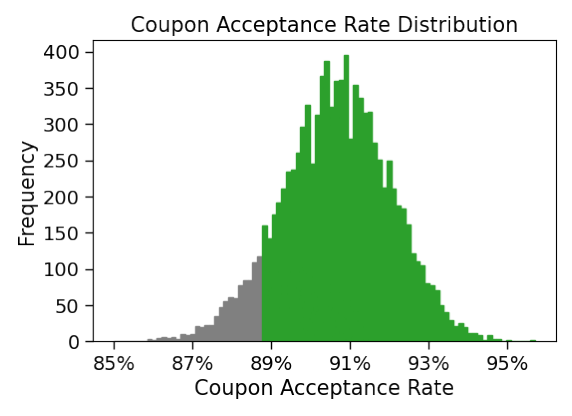

(88.86132347411957, 95.67307692307692)

time: 80.2 ms (started: 2023-07-23 21:58:26 -07:00)


In [91]:
model_type='random_forest'
row_name_tuple=('Model', 'Conversion Rate')
xlabel_string='Coupon Acceptance Rate'
ylabel_string='Frequency'
title_string='Coupon Acceptance Rate Distribution'
xaxis_interval=.02

dpi=100
figure_filename = '../reports/figures/figure_'+model_type+'_classifier_'+xlabel_string.lower().replace(' ', '_')+'_overall_90_percent_confidence_dpi_'+str(dpi)+'_v'+filename_version+'.png'

number_of_bins = 88
bin_number_color_split=31

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(10, 8))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    figsize=(6,4)

    
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)    
    ax.xaxis.set_major_formatter(FuncFormatter(format_percentage))
    
    plt.xticks(np.arange(min(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:]), 
                         max(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:])+1, 
                         xaxis_interval))


    bin_count_array, bin_array, patches = ax.hist(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:],
                                                  linewidth=1,
                                                  bins=number_of_bins,
                                                  rwidth=1,
                                                  alpha=1,
                                                  edgecolor='green',)

    for i in range(0,bin_number_color_split):
        patches[i].set_facecolor('gray')
        patches[i].set_edgecolor('gray')
    for i in range(bin_number_color_split,len(patches)):    
        patches[i].set_facecolor('tab:green')
        patches[i].set_edgecolor('tab:green')

    plt.tick_params(axis='both', which='both', bottom=True, left=True, direction='out', length=6, width=1,)
    
    plt.xlabel(xlabel_string, fontsize=15)
    plt.ylabel(ylabel_string, fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(title_string, fontsize=15);
    

    plt.savefig(figure_filename, bbox_inches='tight', dpi=100)

plt.show()


(random_forest_model_metric_replicate_quantile_series_collection_overall[('Model', 'Conversion Rate')][.1], random_forest_model_metric_replicate_quantile_series_collection_overall[('Model', 'Conversion Rate')][1])


### Get Pilot Campaign Expected Conversion Rate Uplift Distribution

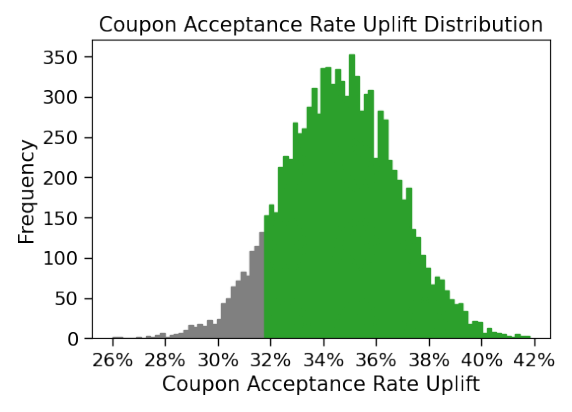

(31.825432739857934, 41.78305835149251)

time: 75.3 ms (started: 2023-07-23 21:58:26 -07:00)


In [92]:
model_type='random_forest'
row_name_tuple=('Model-Survey Difference', 'Conversion Rate')
xlabel_string='Coupon Acceptance Rate Uplift'
ylabel_string='Frequency'
title_string='Coupon Acceptance Rate Uplift Distribution'
xaxis_interval=.02


dpi=100
figure_filename='../reports/figures/figure_'+model_type+'_classifier_'+xlabel_string.lower().replace(' ', '_')+'_overall_90_percent_confidence_dpi_'+str(dpi)+'_v'+filename_version+'.png'

number_of_bins = 88
bin_number_color_split=32

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(10, 8))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    figsize=(6,4)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    ax.xaxis.set_major_formatter(FuncFormatter(format_percentage))
    
    plt.xticks(np.arange(min(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:]), 
                         max(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:])+1, 
                         xaxis_interval))
    
    bin_count_array, bin_array, patches = ax.hist(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:],
                                                  linewidth=1,
                                                  bins=number_of_bins,
                                                  rwidth=1,
                                                  alpha=1,
                                                  edgecolor='green',)

    for i in range(0,bin_number_color_split):
        patches[i].set_facecolor('gray')
        patches[i].set_edgecolor('gray')
    for i in range(bin_number_color_split,len(patches)):    
        patches[i].set_facecolor('tab:green')
        patches[i].set_edgecolor('tab:green')

    plt.tick_params(axis='both', which='both', bottom=True, left=True, direction='out', length=6, width=1,)
    plt.xlabel(xlabel_string, fontsize=15)
    plt.ylabel(ylabel_string, fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(title_string, fontsize=15);

    plt.savefig(figure_filename, bbox_inches='tight', dpi=100)

plt.show()

(random_forest_model_metric_replicate_quantile_series_collection_overall[('Model-Survey Difference', 'Conversion Rate')][.1], random_forest_model_metric_replicate_quantile_series_collection_overall[('Model-Survey Difference', 'Conversion Rate')][1])


### Get Pilot Campaign Expected Percentage of Coupon Acceptances Captured Distribution

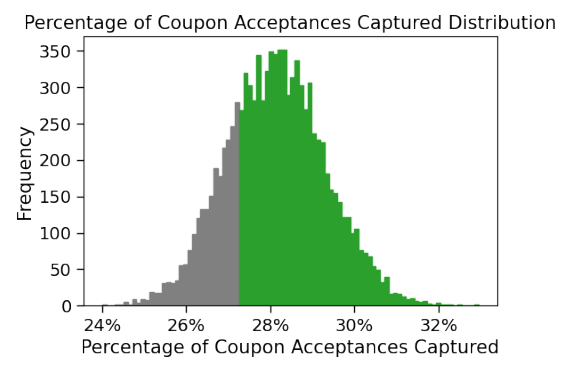

(0.26425553786324807, 0.3276566757493188)

time: 70.5 ms (started: 2023-07-23 21:58:27 -07:00)


In [93]:
model_type='random_forest'
row_name_tuple=('Model', 'Recall')
xlabel_string='Percentage of Coupon Acceptances Captured'
ylabel_string='Frequency'
title_string='Percentage of Coupon Acceptances Captured Distribution'
xaxis_interval=.02


dpi=100
figure_filename='../reports/figures/figure_'+model_type+'_classifier_'+xlabel_string.lower().replace(' ', '_')+'_overall_90_percent_confidence_dpi_'+str(dpi)+'_v'+filename_version+'.png'

number_of_bins = 88
bin_number_color_split=32

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(10, 8))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    figsize=(6,4)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    ax.xaxis.set_major_formatter(FuncFormatter(format_percentage))
    
    plt.xticks(np.arange(min(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:]), 
                         max(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:])+1, 
                         xaxis_interval))
    
    bin_count_array, bin_array, patches = ax.hist(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:],
                                                  linewidth=1,
                                                  bins=number_of_bins,
                                                  rwidth=1,
                                                  alpha=1,
                                                  edgecolor='green',)

    for i in range(0,bin_number_color_split):
        patches[i].set_facecolor('gray')
        patches[i].set_edgecolor('gray')
    for i in range(bin_number_color_split,len(patches)):    
        patches[i].set_facecolor('tab:green')
        patches[i].set_edgecolor('tab:green')

    plt.tick_params(axis='both', which='both', bottom=True, left=True, direction='out', length=6, width=1,)
    plt.xlabel(xlabel_string, fontsize=15)
    plt.ylabel(ylabel_string, fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(title_string, fontsize=15);

    plt.savefig(figure_filename, bbox_inches='tight', dpi=100)

plt.show()

(random_forest_model_metric_replicate_quantile_series_collection_overall[('Model', 'Recall')][.1], random_forest_model_metric_replicate_quantile_series_collection_overall[('Model', 'Recall')][1])


### Get Pilot Campaign Expected Ad Revenue Distribution

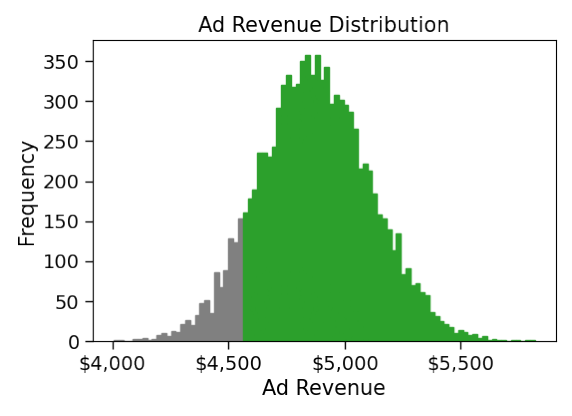

(4568.45, 5818.5)

time: 72.8 ms (started: 2023-07-23 21:58:27 -07:00)


In [94]:
#revenue 90% confidence interval


model_type='random_forest'
row_name_tuple=('Model', 'Ad Revenue')
xlabel_string='Ad Revenue'
ylabel_string='Frequency'
title_string='Ad Revenue Distribution'
xaxis_interval=500
round_to_nearest=500

dpi=100
figure_filename='../reports/figures/figure_'+model_type+'_classifier_'+xlabel_string.lower().replace(' ', '_')+'_overall_90_percent_confidence_dpi_'+str(dpi)+'_v'+filename_version+'.png'

number_of_bins = 88
bin_number_color_split=27

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(10, 8))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    figsize=(6,4)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    
    ax.xaxis.set_major_formatter(FuncFormatter(usd_format))
    plt.xticks(np.arange(round(min(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:])/round_to_nearest)*round_to_nearest, 
                         round(max(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:])/round_to_nearest)*round_to_nearest+1, 
                         xaxis_interval))
    
    bin_count_array, bin_array, patches = ax.hist(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:],
                                                  linewidth=1,
                                                  bins=number_of_bins,
                                                  rwidth=1,
                                                  alpha=1,
                                                  edgecolor='green',)

    for i in range(0,bin_number_color_split):
        patches[i].set_facecolor('gray')
        patches[i].set_edgecolor('gray')
    for i in range(bin_number_color_split,len(patches)):    
        patches[i].set_facecolor('tab:green')
        patches[i].set_edgecolor('tab:green')

    plt.tick_params(axis='both', which='both', bottom=True, left=True, direction='out', length=6, width=1,)
    plt.xlabel(xlabel_string, fontsize=15)
    plt.ylabel(ylabel_string, fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(title_string, fontsize=15);

    plt.savefig(figure_filename, bbox_inches='tight', dpi=100)

plt.show()


(random_forest_model_metric_replicate_quantile_series_collection_overall[('Model', 'Ad Revenue')][.1], random_forest_model_metric_replicate_quantile_series_collection_overall[('Model', 'Ad Revenue')][1])

### Get Pilot Campaign Estimated ROAS Distribution

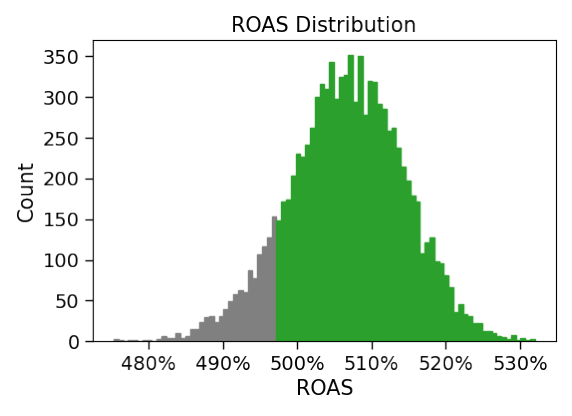

(181.33783599369275, 252.37496977458187)

time: 74 ms (started: 2023-07-23 21:58:27 -07:00)


In [95]:
#roas 90% confidence interval

model_type='random_forest'
row_name_tuple=('Model', 'ROAS')
xlabel_string='ROAS'
ylabel_string='Count'
title_string='ROAS Distribution'

xaxis_interval=10
round_to_nearest=10

dpi=100
figure_filename='../reports/figures/figure_'+model_type+'_classifier_'+xlabel_string.lower().replace(' ', '_')+'_overall_90_percent_confidence_dpi_'+str(dpi)+'_v'+filename_version+'.png'

number_of_bins = 88
bin_number_color_split=34

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(10, 8))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    figsize=(6,4)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    
    ax.xaxis.set_major_formatter(FuncFormatter(format_percentage_without_multiplier))
    plt.xticks(np.arange(round(min(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:])/round_to_nearest)*round_to_nearest, 
                         round(max(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:])/round_to_nearest)*round_to_nearest+1, 
                         xaxis_interval))
    
    bin_count_array, bin_array, patches = ax.hist(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:],
                                                  linewidth=1,
                                                  bins=number_of_bins,
                                                  rwidth=1,
                                                  alpha=1,
                                                  edgecolor='green',)

    for i in range(0,bin_number_color_split):
        patches[i].set_facecolor('gray')
        patches[i].set_edgecolor('gray')
    for i in range(bin_number_color_split,len(patches)):    
        patches[i].set_facecolor('tab:green')
        patches[i].set_edgecolor('tab:green')

    plt.tick_params(axis='both', which='both', bottom=True, left=True, direction='out', length=6, width=1,)
    plt.xlabel(xlabel_string, fontsize=15)
    plt.ylabel(ylabel_string, fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(title_string, fontsize=15);

    plt.savefig(figure_filename, bbox_inches='tight', dpi=100)

plt.show()


(random_forest_model_metric_replicate_quantile_series_collection_overall[('Model-Survey Difference', 'ROAS')][.1], random_forest_model_metric_replicate_quantile_series_collection_overall[('Model-Survey Difference', 'ROAS')][1])


### Get Pilot Campaign Estimated ROAS Uplift Distribution

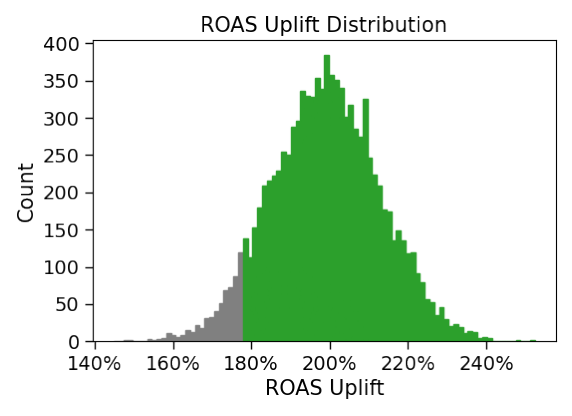

(181.33783599369275, 252.37496977458187)

time: 67 ms (started: 2023-07-23 21:58:27 -07:00)


In [96]:
#roas uplift 90% confidence interval

model_type='random_forest'
row_name_tuple=('Model-Survey Difference', 'ROAS')
xlabel_string='ROAS Uplift'
ylabel_string='Count'
title_string='ROAS Uplift Distribution'

xaxis_interval=20
round_to_nearest=20



dpi=100
figure_filename='../reports/figures/figure_'+model_type+'_classifier_'+xlabel_string.lower().replace(' ', '_')+'_overall_90_percent_confidence_dpi_'+str(dpi)+'_v'+filename_version+'.png'

number_of_bins = 88
bin_number_color_split=27

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(10, 8))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    figsize=(6,4)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    ax.xaxis.set_major_formatter(FuncFormatter(format_percentage_without_multiplier))
    plt.xticks(np.arange(round(min(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:])/round_to_nearest)*round_to_nearest, 
                         round(max(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:])/round_to_nearest)*round_to_nearest+1, 
                         xaxis_interval))
    
    bin_count_array, bin_array, patches = ax.hist(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:],
                                                  linewidth=1,
                                                  bins=number_of_bins,
                                                  rwidth=1,
                                                  alpha=1,
                                                  edgecolor='green',)

    for i in range(0,bin_number_color_split):
        patches[i].set_facecolor('gray')
        patches[i].set_edgecolor('gray')
    for i in range(bin_number_color_split,len(patches)):    
        patches[i].set_facecolor('tab:green')
        patches[i].set_edgecolor('tab:green')

    plt.tick_params(axis='both', which='both', bottom=True, left=True, direction='out', length=6, width=1,)
    plt.xlabel(xlabel_string, fontsize=15)
    plt.ylabel(ylabel_string, fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(title_string, fontsize=15);

    plt.savefig(figure_filename, bbox_inches='tight', dpi=100)

plt.show()


(random_forest_model_metric_replicate_quantile_series_collection_overall[row_name_tuple][.1],
 random_forest_model_metric_replicate_quantile_series_collection_overall[row_name_tuple][1])

### Get Pilot Campaign Estimated ROAS Uplift Distribution: Low-Cost Restaurant

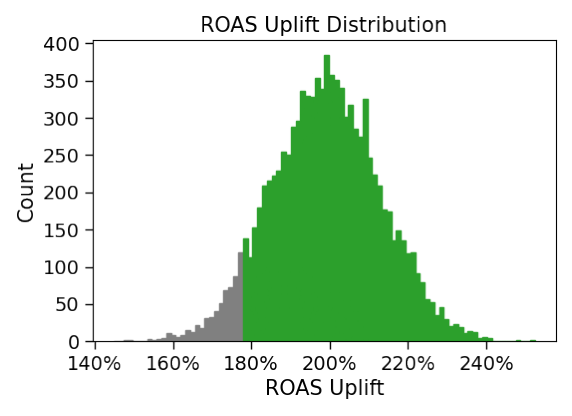

(181.33783599369275, 252.37496977458187)

time: 69.1 ms (started: 2023-07-23 21:58:27 -07:00)


In [97]:
#roas uplift 90% confidence interval per low-cost restaurant

model_type='random_forest'
row_name_tuple=('Model-Survey Difference', 'ROAS')
xlabel_string='ROAS Uplift'
ylabel_string='Count'
title_string='ROAS Uplift Distribution'

xaxis_interval=20
round_to_nearest=20



dpi=100
figure_filename='../reports/figures/figure_'+model_type+'_classifier_'+xlabel_string.lower().replace(' ', '_')+'_overall_90_percent_confidence_dpi_'+str(dpi)+'_v'+filename_version+'.png'

number_of_bins = 88
bin_number_color_split=27

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(10, 8))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    figsize=(6,4)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    ax.xaxis.set_major_formatter(FuncFormatter(format_percentage_without_multiplier))
    plt.xticks(np.arange(round(min(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:])/round_to_nearest)*round_to_nearest, 
                         round(max(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:])/round_to_nearest)*round_to_nearest+1, 
                         xaxis_interval))
    
    bin_count_array, bin_array, patches = ax.hist(df_test_random_forest_90_precision_estimated_10000_metric_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_replicates_overall.loc[row_name_tuple,:],
                                                  linewidth=1,
                                                  bins=number_of_bins,
                                                  rwidth=1,
                                                  alpha=1,
                                                  edgecolor='green',)

    for i in range(0,bin_number_color_split):
        patches[i].set_facecolor('gray')
        patches[i].set_edgecolor('gray')
    for i in range(bin_number_color_split,len(patches)):    
        patches[i].set_facecolor('tab:green')
        patches[i].set_edgecolor('tab:green')

    plt.tick_params(axis='both', which='both', bottom=True, left=True, direction='out', length=6, width=1,)
    plt.xlabel(xlabel_string, fontsize=15)
    plt.ylabel(ylabel_string, fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(title_string, fontsize=15);

    plt.savefig(figure_filename, bbox_inches='tight', dpi=100)

plt.show()


(random_forest_model_metric_replicate_quantile_series_collection_overall[row_name_tuple][.1],
 random_forest_model_metric_replicate_quantile_series_collection_overall[row_name_tuple][1])

In [98]:
model_type='gradient_boosting'
survey_number_recall_estimated_y_predicted_column_name='Y_test_survey_80_recall_estimate_predicted'


metrics_coupon_venue_type_list=[]

for feature_column_name_filter_value_list_dictionary_key in feature_column_name_filter_value_list_dictionary.keys():
    
    metric_list=icr.get_model_and_survey_metrics(df=df_y_test_model_name_predicted_y_test_survey_recall_estimate_predicted_y_actual_coupon_venue_type.copy(),
                                                 model_y_predicted_column_name='Y_test_'+model_type+'_predicted',
                                                 survey_number_recall_estimated_y_predicted_column_name=survey_number_recall_estimated_y_predicted_column_name,
                                                 y_predicted_column_name_base_survey=y_predicted_column_name_base_survey,
                                                 y_actual_column_name='Y',
                                                 feature_column_name_filter=feature_column_name_filter,
                                                 feature_column_name_filter_value_list=feature_column_name_filter_value_list_dictionary[feature_column_name_filter_value_list_dictionary_key],
                                                 metrics_column_name_list=None,)
    metrics_coupon_venue_type_list+=[metric_list]

df_test_gradient_boosting_model_survey_metrics=\
pd.DataFrame(metrics_coupon_venue_type_list, 
             index=feature_column_name_filter_value_list_dictionary_key_list,
             columns=multiple_index[0:20]).T

df_test_gradient_boosting_metrics=icr.calculate_and_add_model_survey_difference(df_test_gradient_boosting_model_survey_metrics, multiple_index)

#add Venue Type Coupon Recommendation Cost Estimated, Sale Estimated
df_test_gradient_boosting_metrics_coupon_recommendation_cost_estimated_sale_estimated=pd.concat([df_test_gradient_boosting_metrics, df_train_gradient_boosting_80_recall_survey_100_recall_coupon_recommendation_cost_estimated_sale_estimated], axis=0)
df_test_gradient_boosting_metrics_coupon_recommendation_cost_estimated_sale_estimated



#get and add Total Ad Spend, Total Revenue, ROAS
df_test_gradient_boosting_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI=icr.get_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI(df=df_test_gradient_boosting_metrics_coupon_recommendation_cost_estimated_sale_estimated)

del df_test_gradient_boosting_metrics_coupon_recommendation_cost_estimated_sale_estimated
df_test_gradient_boosting_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI

Overall  \
Model                   Conversion Rate                                                   0.798764   
                        Recall                                                            0.802622   
                        Proportion of Conversions                                         1.000000   
                        Conversions                                                    1163.000000   
                        Proportion of Coupons Recommended                                 1.000000   
                        Coupons Recommended                                            1456.000000   
                        Conversions to Base Survey Coupons Recommended Ratio              0.458415   
                        Conversions to Survey Conversions Ratio                           1.019281   
                        Coupons Recommended to Survey Coupons Recommended Ratio           0.722222   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio      0.573906   
Survey                  Conversion Rate                                                   0.565972   
                        Recall                                                            0.787440   
                        Proportion of Conversions                                         1.000000   
                        Conversions                                                    1141.000000   
                        Proportion of Coupons Recommended                                 1.000000   
                        Coupons Recommended                                            2016.000000   
                        Conversions to Base Survey Coupons Recommended Ratio              0.449744   
                        Conversions to Survey Conversions Ratio                           1.000000   
                        Coupons Recommended to Survey Coupons Recommended Ratio           1.000000   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio      0.794639   
Model-Survey Difference Conversion Rate                                                   0.232792   
                        Recall                                                            0.015183   
                        Proportion of Conversions                                         0.000000   
                        Conversions                                                      22.000000   
                        Proportion of Coupons Recommended                                 0.000000   
                        Coupons Recommended                                            -560.000000   
                        Conversions to Base Survey Coupons Recommended Ratio              0.008672   
                        Conversions to Survey Conversions Ratio                           0.019281   
                        Coupons Recommended to Survey Coupons Recommended Ratio          -0.277778   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio     -0.220733   
Model                   Average Coupon Recommendation Cost Estimated                           NaN   
                        Average Sale Estimated                                                 NaN   
Survey                  Average Coupon Recommendation Cost Estimated                           NaN   
                        Average Sale Estimated                                                 NaN   
Model                   Ad Revenue                                                    14926.000000   
                        Ad Spend                                                       2970.843315   
Survey                  Ad Revenue                                                    15473.000000   
                        Ad Spend                                                       4215.483585   
Model-Survey Difference Ad Revenue                                                     -547.000000   
           

time: 72.6 ms (started: 2023-07-23 21:58:27 -07:00)


In [99]:
########################################################################################################################################################################################################
filename='df_test_gradient_boosting_model_survey_95_confidence_interval_metric_feature_column_name_filter_value_v'+filename_version+'.pkl'

df_readback=icr.return_processed_data_file_if_it_exists_v2(filename=filename, column_name_row_integer_location_list=[0, 1], index_column_integer_location_list=[0, 1])
if df_readback.empty == False:
    df_test_gradient_boosting_model_survey_95_confidence_interval_metric_feature_column_name_filter_value=df_readback
else:
    
    model_type='gradient_boosting'
    survey_number_recall_estimated_y_predicted_column_name='Y_test_survey_80_recall_estimate_predicted'

    if st != 'yes':
        number_of_replicates=10000

    quantile_lower_upper_list=[0.025, 0.975]

    feature_column_name_filter='coupon_venue_type'

    save_metric_replicates_feature_column_name_filter_value_list_dictionary_key_list=['Overall', 'Coffee House', 'Bar', 'Takeout', 'Low-Cost Restaurant', 'Mid-Range Restaurant']

    gradient_boosting_model_survey_95_confidence_interval_metric_collection={}
    df_gradient_boosting_80_recall_estimated_feature_filter_number_bootstrap_replicates_metrics_collection={}

    for feature_column_name_filter_value_list_dictionary_key in feature_column_name_filter_value_list_dictionary_key_list:

        gradient_boosting_model_survey_95_confidence_interval_metric_collection[feature_column_name_filter_value_list_dictionary_key],\
        df_gradient_boosting_80_recall_estimated_feature_filter_number_bootstrap_replicates_metrics_collection[feature_column_name_filter_value_list_dictionary_key]=\
        icr.get_metric_confidence_interval_table_by_feature_column_name_filter_value_list_dictionary_key(df_y_train_test_model_name_predicted_y_train_test_survey_recall_estimate_predicted_y_actual_feature_column_name_filter=df_y_test_model_name_predicted_y_test_survey_recall_estimate_predicted_y_actual_coupon_venue_type.copy(),
                                                                                            feature_column_name_filter=feature_column_name_filter,
                                                                                            feature_column_name_filter_value_list_dictionary_key=feature_column_name_filter_value_list_dictionary_key,
                                                                                            feature_column_name_filter_value_list_dictionary=feature_column_name_filter_value_list_dictionary,
                                                                                            multiple_index=multiple_index,
                                                                                            number_of_replicates=number_of_replicates,
                                                                                            quantile_lower_upper_list=quantile_lower_upper_list,
                                                                                            model_type=model_type,
                                                                                            survey_number_recall_estimated_y_predicted_column_name=survey_number_recall_estimated_y_predicted_column_name,
                                                                                            save_metric_replicates_feature_column_name_filter_value_list_dictionary_key_list=save_metric_replicates_feature_column_name_filter_value_list_dictionary_key_list,
                                                                                            filename_version=filename_version,
                                                                                            sample_size=None)

    df_test_gradient_boosting_model_survey_95_confidence_interval_metric_feature_column_name_filter_value=\
    icr.convert_collection_to_data_frame_and_drop_top_column_level(gradient_boosting_model_survey_95_confidence_interval_metric_collection)
    
    

    #save it
    df_test_gradient_boosting_model_survey_95_confidence_interval_metric_feature_column_name_filter_value=\
    icr.save_and_return_data_frame_v2(df_test_gradient_boosting_model_survey_95_confidence_interval_metric_feature_column_name_filter_value, filename=filename)

    
    filename='df_gradient_boosting_80_recall_estimated_feature_filter_number_bootstrap_replicates_metrics_collection_v'+filename_version+'.pkl'
    #save it
    df_gradient_boosting_80_recall_estimated_feature_filter_number_bootstrap_replicates_metrics_collection=\
    icr.save_and_return_collection(df_gradient_boosting_80_recall_estimated_feature_filter_number_bootstrap_replicates_metrics_collection, filename=filename)

    
########################################################################################################################################################################################################





########################################################################################################################################################################################################
### Get Gradient Boosting 80% Recall Estimated 95% Confidence Interval Ad Revenue, Ad Spend, ROAS, Profit, Spend, and ROI (Per Coupon Venue Type) Table
filename='df_gradient_boosting_95_confidence_interval_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_v'+filename_version+'.pkl'

df_readback=icr.return_processed_data_file_if_it_exists_v2(filename=filename, column_name_row_integer_location_list=[0, 1], index_column_integer_location_list=[0, 1])
if df_readback.empty == False:
    df_gradient_boosting_95_confidence_interval_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI=df_readback
else:
    #get Random Forest Model and Survey Coupon Recommendation Cost Estimated and Sale Estimated Replicate Collection by Venue Type
    df_gradient_boosting_model_survey_coupon_recommendation_cost_estimated_sale_estimated_replicate_collection=\
    icr.get_model_survey_coupon_recommendation_cost_estimated_and_sale_estimated_replicate_collection_venue_type(df=df_train_gradient_boosting_80_recall_survey_100_recall_coupon_recommendation_cost_estimated_sale_estimated, 
                                                                                                             column_name_list=['Coffee House', 'Bar', 'Takeout', 'Low-Cost Restaurant', 'Mid-Range Restaurant'], 
                                                                                                             column_name_drop_list=['Overall'],
                                                                                                             number_of_replicates=number_of_replicates)


    #get filename list of gradient boosting metric replicates by venue type
    column_name_list=['Coffee House', 'Bar', 'Takeout', 'Low-Cost Restaurant', 'Mid-Range Restaurant']
    model_name='gradient_boosting'

    test_gradient_boosting_metric_replicate_filename_collection={}
    for column_name in column_name_list:
        test_gradient_boosting_metric_replicate_filename_collection[column_name]='df_test_'+str(model_name)+'_number_metric_estimated_'+str(number_of_replicates)+'_metric_replicates_from_'+str(number_of_replicates)+'_nonparametric_subsamples_'+str(column_name.lower().replace(' ','_'))+'_4dot3.csv'
        print(test_gradient_boosting_metric_replicate_filename_collection[column_name])



    #calculate 95% confidence interval for Ad Revenue, Ad Spend, ROAS, Profit, Spend and ROI
    if st!='yes':
        number_of_replicates=10000

    df_gradient_boosting_95_confidence_interval_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI=\
    icr.calculate_Overall_and_Coupon_Venue_Type_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI_95_Confidence_Intervals_from_metric_replicates_and_append_to_metric_confidence_interval_table(
        df_model_name_model_survey_coupon_recommendation_cost_estimated_sale_estimated_replicate_collection=df_gradient_boosting_model_survey_coupon_recommendation_cost_estimated_sale_estimated_replicate_collection,
        df_test_model_name_model_survey_95_confidence_interval_metric_feature_column_name_filter_value=df_test_gradient_boosting_model_survey_95_confidence_interval_metric_feature_column_name_filter_value,
        test_model_name_metric_replicate_filename_collection=test_gradient_boosting_metric_replicate_filename_collection,
        model_type=model_name,
        filename_version=filename_version,
        number_of_replicates=number_of_replicates)
    
    #save it
    df_gradient_boosting_95_confidence_interval_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI=\
    icr.save_and_return_data_frame_v2(df_gradient_boosting_95_confidence_interval_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI, filename=filename)

    

df_gradient_boosting_95_confidence_interval_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI
########################################################################################################################################################################################################



This file already exists
This file already exists


95% Confidence Interval  \
                                                                                                       Overall   
Model                   Conversion Rate                                                         (77.8%, 81.9%)   
                        Recall                                                                  (78.2%, 82.3%)   
                        Percentage of Conversions                                                 (100%, 100%)   
                        Conversions                                                               (1115, 1213)   
                        Percentage of Coupons Recommended                                         (100%, 100%)   
                        Coupons Recommended                                                       (1407, 1505)   
                        Conversions to Base Survey Coupons Recommended Ratio                    (43.9%, 47.8%)   
                        Conversions to Survey Conversions Ratio                                (98.3%, 105.7%)   
                        Coupons Recommended to Survey Coupons Recommended Ratio                 (69.4%, 75.1%)   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio            (55.5%, 59.3%)   
Survey                  Conversion Rate                                                         (54.5%, 58.7%)   
                        Recall                                                                  (76.6%, 80.8%)   
                        Percentage of Conversions                                                 (100%, 100%)   
                        Conversions                                                               (1093, 1190)   
                        Percentage of Coupons Recommended                                         (100%, 100%)   
                        Coupons Recommended                                                       (1976, 2055)   
                        Conversions to Base Survey Coupons Recommended Ratio                    (43.1%, 46.9%)   
                        Conversions to Survey Conversions Ratio                                   (100%, 100%)   
                        Coupons Recommended to Survey Coupons Recommended Ratio                   (100%, 100%)   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio            (77.9%, 81.0%)   
Model-Survey Difference Conversion Rate                                                         (21.3%, 25.2%)   
                        Recall                                                                   (-1.4%, 4.4%)   
                        Percentage of Conversions                                                 (0.0%, 0.0%)   
                        Conversions                                                                  (-20, 64)   
                        Percentage of Coupons Recommended                                         (0.0%, 0.0%)   
                        Coupons Recommended                                                       (-624, -497)   
                        Conversions to Base Survey Coupons Recommended Ratio                     (-0.8%, 2.5%)   
                        Conversions to Survey Conversions Ratio                                  (-1.7%, 5.7%)   
                        Coupons Recommended to Survey Coupons Recommended Ratio               (-30.6%, -24.9%)   
                        Coupons Recommended to Base Survey Coupons Recommended Ratio          (-24.6%, -19.6%)   
Model                   Ad Revenue                                                    (\$14132.98, \$15725.56)   
                        Ad Spend                                                        (\$2846.93, \$3098.58)   
Survey                  Ad Revenue                                                    (\$14602.48, \$16338.54)   
                        Ad Spend                                                        (\$4083.8

time: 28.1 ms (started: 2023-07-23 21:58:27 -07:00)


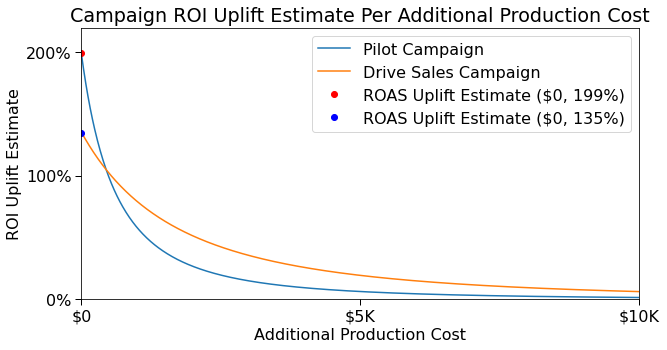

time: 152 ms (started: 2023-07-23 21:58:27 -07:00)


In [100]:
model_types='random_forest_gradient_boosting'
xlabel_string='Additional Production Cost'
ylabel_string='ROI Uplift Estimate'
title_string='Campaign '+str(ylabel_string)+' Per '+str(xlabel_string)

figure_filename='../reports/figures/figure_'+str(model_types)+'_'+title_string.replace(' ','_').lower()+'_v'+filename_version+'.png'


#get pilot campaign model ad revenue and ad spend,
pilot_campaign_model_ad_revenue=df_test_random_forest_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI.loc[('Model', 'Ad Revenue'), 'Overall']
pilot_campaign_model_ad_spend=df_test_random_forest_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI.loc[('Model', 'Ad Spend'), 'Overall']

#get pilot campaig survey ad revenue and ad spend
pilot_campaign_survey_ad_revenue=df_test_random_forest_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI.loc[('Survey', 'Ad Revenue'), 'Overall']
pilot_campaign_survey_ad_spend=df_test_random_forest_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI.loc[('Survey', 'Ad Spend'), 'Overall']

#get drive sales campaign model ad revenue and ad spend
drive_sales_campaign_model_ad_revenue=df_test_gradient_boosting_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI.loc[('Model', 'Ad Revenue'), 'Overall']
drive_sales_campaign_model_ad_spend=df_test_gradient_boosting_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI.loc[('Model', 'Ad Spend'), 'Overall']

#get drive sales campaign survey ad revenue and ad spend
drive_sales_campaign_survey_ad_revenue=df_test_gradient_boosting_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI.loc[('Survey', 'Ad Revenue'), 'Overall']
drive_sales_campaign_survey_ad_spend=df_test_gradient_boosting_metrics_Ad_Revenue_Ad_Spend_ROAS_Profit_Spend_ROI.loc[('Survey', 'Ad Spend'), 'Overall']

#additional production cost values
additional_production_cost = np.linspace(0, 10000, 1000)




#calculate pilot campaign model/survey roi per addtional production cost values
pilot_campaign_model_roi=icr.get_campaign_roi_from_ad_revenue_ad_spend_additional_production_cost(ad_revenue=pilot_campaign_model_ad_revenue, ad_spend=pilot_campaign_model_ad_spend, additional_production_cost=additional_production_cost)
pilot_campaign_survey_roi=icr.get_campaign_roi_from_ad_revenue_ad_spend_additional_production_cost(ad_revenue=pilot_campaign_survey_ad_revenue, ad_spend=pilot_campaign_survey_ad_spend, additional_production_cost=additional_production_cost)

#calculate pilot campaign roi uplift
pilot_campaign_model_survey_difference_roi=pilot_campaign_model_roi-pilot_campaign_survey_roi


#calculate drive sales campaign model/survey roi per addtional production cost values
drive_sales_campaign_model_roi=icr.get_campaign_roi_from_ad_revenue_ad_spend_additional_production_cost(ad_revenue=drive_sales_campaign_model_ad_revenue, ad_spend=drive_sales_campaign_model_ad_spend, additional_production_cost=additional_production_cost)
drive_sales_campaign_survey_roi=icr.get_campaign_roi_from_ad_revenue_ad_spend_additional_production_cost(ad_revenue=drive_sales_campaign_survey_ad_revenue, ad_spend=drive_sales_campaign_survey_ad_spend, additional_production_cost=additional_production_cost)

#calculate drive sales campaign model roi uplift
drive_sales_campaign_model_survey_difference_roi=drive_sales_campaign_model_roi-drive_sales_campaign_survey_roi


plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))


#plot pilot campaign and drive sales campaign curves
axes.plot(additional_production_cost, pilot_campaign_model_survey_difference_roi*100, label='Pilot Campaign')
axes.plot(additional_production_cost, drive_sales_campaign_model_survey_difference_roi*100, label='Drive Sales Campaign')


pilot_campaign_ROAS_two_tuple=(int(additional_production_cost[0]), int(pilot_campaign_model_survey_difference_roi[0]*100))
drive_sales_campaign_ROAS_two_tuple=(int(additional_production_cost[0]), int(drive_sales_campaign_model_survey_difference_roi[0]*100))
axes.plot(0, pilot_campaign_ROAS_two_tuple[1], 'ro', label=f'ROAS Uplift Estimate (${pilot_campaign_ROAS_two_tuple[0]}, {pilot_campaign_ROAS_two_tuple[1]}%)')
axes.plot(0, drive_sales_campaign_ROAS_two_tuple[1], 'bo', label=f'ROAS Uplift Estimate (${drive_sales_campaign_ROAS_two_tuple[0]}, {drive_sales_campaign_ROAS_two_tuple[1]}%)')




axes.set_xlabel(xlabel_string)
axes.set_ylabel(ylabel_string)
axes.set_title(title_string)
axes.xaxis.set_major_formatter('${x:1.0f}')
axes.yaxis.set_major_formatter(mtick.PercentFormatter())
#axes.legend(['Pilot Campaign','Drive Sales Campaign',])
axes.legend()

# axes.set_yticklabels([])
# axes.set_xticklabels([])
axes.tick_params(axis='both', which='both', bottom=True, left=True, direction='out', length=6, width=1,)
#axes.tick_params(left=True, bottom=True)
axes.set_xlim(-0,10000)
axes.set_ylim(-0,220)

axes.set_xticks([0, 5000, 10000,])
axes.set_yticks([0, 100, 200,])
axes.set_xticklabels(['$0', '$5K', '$10K',])
axes.set_yticklabels(['0%', '100%', '200%',])
#axes.tick_params(axis='both', which='both', length=0)


#save it
plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show() # Show the plot



In [101]:
%watermark -a "Paul Jacob" -d -t -v -p numpy,pandas -g

Author: Paul Jacob

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.2.0

numpy : 1.21.5
pandas: 1.4.2

Git hash: c9816b4f561f33f107611082b7a101bdb24d66f5

time: 63.9 ms (started: 2023-07-23 21:58:27 -07:00)
